In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

from keras.layers import concatenate
from tensorflow.keras.models import Model

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.optimizer_v2.adam import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

In [5]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### Load Data

In [6]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [7]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

# CHOOSE THE IMAGE SIZE 75 for 75x75 pixels, 128 for 128x128 pixels, 256 for 256x256 pixels
img_size = 75

filename_B = '00-images/ER-img/out-img' + str(img_size) + '/'
filename_B1 = '00-images/AC-img/out-img' + str(img_size) + '/'
filename_B2 = '00-images/CNNS-img/out-img' + str(img_size) + '/'
filename_B3 = '00-images/RN-img/out-img' + str(img_size) + '/'
filename_B4 = '00-images/WALL-img/out-img' + str(img_size) + '/'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = '00-images/mDM' + str(mDM) + 'GeV-img/out-img' + str(img_size) + '/'

##### Load the h5

In [8]:
# OPEN THE SAVED FILE TO CHECK IT
from PIL import Image

print('\n Background Events shape: ')
    
for i in range(1):
    img = Image.open( filefolder + filename_B + 'ER' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('ER ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B1 + 'AC' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('AC ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B2 + 'CNNS' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('CNNS ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B3 + 'RN' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('RN ', data.shape)
    
for i in range(1):
    img = Image.open( filefolder + filename_B4 + 'WALL' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('WALL ', data.shape)
    
    
print('\n Signal Events shape:')
for i in range(1):
    img = Image.open( filefolder + filename_S + 'WP' + str(i) + '.png' )
    data = np.asarray( img, dtype="int32" )
    print('WIMP ', data.shape)


 Background Events shape: 
ER  (75, 75, 4)
AC  (75, 75, 4)
CNNS  (75, 75, 4)
RN  (75, 75, 4)
WALL  (75, 75, 4)

 Signal Events shape:
WIMP  (75, 75, 4)


In [9]:
################
# ALL THE DATA #
################

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 15000


NUM_DAT_AC = round(num_data*f_AC)
NUM_DAT_CNNS = max(2, round(num_data*f_CNNS))
NUM_DAT_RN = round(num_data*f_RN)
NUM_DAT_WALL = round(num_data*f_WALL)

NUM_DAT_ER = num_data - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )



# load the indeces that are OK (with both S1 and S2 signals)
index_B = np.loadtxt(filefolder + '00-images/ER-img/ok-index.txt').astype(int)
index_B1 = np.loadtxt(filefolder + '00-images/AC-img/ok-index.txt').astype(int)
index_B2 = np.loadtxt(filefolder + '00-images/CNNS-img/ok-index.txt').astype(int)
index_B3 = np.loadtxt(filefolder + '00-images/RN-img/ok-index.txt').astype(int)
index_B4 = np.loadtxt(filefolder + '00-images/WALL-img/ok-index.txt').astype(int)

index_S = np.loadtxt(filefolder + '00-images/mDM' + str(mDM) + 'GeV-img/ok-index.txt').astype(int)



##############
# BACKGROUND #
##############

file_path_B = []

for path_it in range(NUM_DAT_ER):
    file_path_B.append( filefolder + filename_B + 'ER' + str(index_B[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B0 = [imageio.imread(jj) for jj in file_path_B]
images_B0 = np.asarray(images_B0)



file_path_B1 = []

for path_it in range(NUM_DAT_AC):
    file_path_B1.append( filefolder + filename_B1 + 'AC' + str(index_B1[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B1 = [imageio.imread(jj) for jj in file_path_B1]
images_B1 = np.asarray(images_B1)



file_path_B2 = []

for path_it in range(NUM_DAT_CNNS):
    file_path_B2.append( filefolder + filename_B2 + 'CNNS' + str(index_B2[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B2 = [imageio.imread(jj) for jj in file_path_B2]
images_B2 = np.asarray(images_B2)



file_path_B3 = []

for path_it in range(NUM_DAT_RN):
    file_path_B3.append( filefolder + filename_B3 + 'RN' + str(index_B3[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B3 = [imageio.imread(jj) for jj in file_path_B3]
images_B3 = np.asarray(images_B3)



file_path_B4 = []

for path_it in range(NUM_DAT_WALL):
    file_path_B4.append( filefolder + filename_B4 + 'WALL' + str(index_B4[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_B4 = [imageio.imread(jj) for jj in file_path_B4]
images_B4 = np.asarray(images_B4)



# Concatenate all background contributions
images_B = np.concatenate([images_B0, images_B1, images_B2, images_B3, images_B4])





##########
# SIGNAL #
##########

file_path_S = []

for path_it in range(num_data):
    file_path_S.append( filefolder + filename_S + 'WP' + str(index_S[path_it]) + '.png' )

# Load the images and convert to a numpy array
images_S = [imageio.imread(jj) for jj in file_path_S]
images_S = np.asarray(images_S)




# LABELS
labels_B = np.zeros(len(images_B))
labels_S = np.ones(len(images_S))


print('images_B.shape: ', images_B.shape)
print('images_S.shape: ', images_S.shape)
print('labels_B.shape: ', labels_B.shape)
print('labels_S.shape: ', labels_S.shape)




# CONCATENATE INTO A SINGLE DATASET
images = np.concatenate([images_B, images_S])
del images_B
del images_S

labels = np.concatenate([labels_B,labels_S])
del labels_B
del labels_S



print('\nimages.shape: ', images.shape)
print('labels.shape: ', labels.shape)

# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
print('image_size: ', image_size)

# Scale images so values are between 0 and 1
images = images / 255

n_images = images.shape[0]

images_B.shape:  (5000, 75, 75, 4)
images_S.shape:  (5000, 75, 75, 4)
labels_B.shape:  (5000,)
labels_S.shape:  (5000,)

images.shape:  (10000, 75, 75, 4)
labels.shape:  (10000,)
image_size:  [75 75  4]


##### Load the compressed features

In [10]:
###############
# BACKGROUNDS # 
###############

B_pbot_ER = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop_ER = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1_ER = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2_ER = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot_ER.shape: ', B_pbot_ER.shape)
print('B_ptop_ER.shape: ', B_ptop_ER.shape)
print('B_ppeakS1_ER.shape :', B_ppeakS1_ER.shape)
print('B_ppeakS2_ER.shape: ', B_ppeakS2_ER.shape)


B_pbot_AC = np.loadtxt(filefolder + 'AC/pbot.txt')
B_ptop_AC = np.loadtxt(filefolder + 'AC/ptop.txt')
B_ppeakS1_AC = np.loadtxt(filefolder + 'AC/ppeakS1.txt')
B_ppeakS2_AC = np.loadtxt(filefolder + 'AC/ppeakS2.txt')

print('\nB_pbot_AC.shape: ', B_pbot_AC.shape)
print('B_ptop_AC.shape: ', B_ptop_AC.shape)
print('B_ppeakS1_AC.shape :', B_ppeakS1_AC.shape)
print('B_ppeakS2_AC.shape: ', B_ppeakS2_AC.shape)


B_pbot_CNNS = np.loadtxt(filefolder + 'CNNS/pbot.txt')
B_ptop_CNNS = np.loadtxt(filefolder + 'CNNS/ptop.txt')
B_ppeakS1_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS1.txt')
B_ppeakS2_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS2.txt')

print('\nB_pbot_CNNS.shape: ', B_pbot_CNNS.shape)
print('B_ptop_CNNS.shape: ', B_ptop_CNNS.shape)
print('B_ppeakS1_CNNS.shape :', B_ppeakS1_CNNS.shape)
print('B_ppeakS2_CNNS.shape: ', B_ppeakS2_CNNS.shape)


B_pbot_RN = np.loadtxt(filefolder + 'RN/pbot.txt')
B_ptop_RN = np.loadtxt(filefolder + 'RN/ptop.txt')
B_ppeakS1_RN = np.loadtxt(filefolder + 'RN/ppeakS1.txt')
B_ppeakS2_RN = np.loadtxt(filefolder + 'RN/ppeakS2.txt')

print('\nB_pbot_RN.shape: ', B_pbot_RN.shape)
print('B_ptop_RN.shape: ', B_ptop_RN.shape)
print('B_ppeakS1_RN.shape :', B_ppeakS1_RN.shape)
print('B_ppeakS2_RN.shape: ', B_ppeakS2_RN.shape)


B_pbot_WALL = np.loadtxt(filefolder + 'WALL/pbot.txt')
B_ptop_WALL = np.loadtxt(filefolder + 'WALL/ptop.txt')
B_ppeakS1_WALL = np.loadtxt(filefolder + 'WALL/ppeakS1.txt')
B_ppeakS2_WALL = np.loadtxt(filefolder + 'WALL/ppeakS2.txt')

print('\nB_pbot_WALL.shape: ', B_pbot_WALL.shape)
print('B_ptop_WALL.shape: ', B_ptop_WALL.shape)
print('B_ppeakS1_WALL.shape :', B_ppeakS1_WALL.shape)
print('B_ppeakS2_WALL.shape: ', B_ppeakS2_WALL.shape)


##########
# SIGNAL #
##########

S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot_ER.shape:  (35549,)
B_ptop_ER.shape:  (35549,)
B_ppeakS1_ER.shape : (35549, 8)
B_ppeakS2_ER.shape:  (35549, 8)

B_pbot_AC.shape:  (3998,)
B_ptop_AC.shape:  (3998,)
B_ppeakS1_AC.shape : (3998, 8)
B_ppeakS2_AC.shape:  (3998, 8)

B_pbot_CNNS.shape:  (99,)
B_ptop_CNNS.shape:  (99,)
B_ppeakS1_CNNS.shape : (99, 8)
B_ppeakS2_CNNS.shape:  (99, 8)

B_pbot_RN.shape:  (2610,)
B_ptop_RN.shape:  (2610,)
B_ppeakS1_RN.shape : (2610, 8)
B_ppeakS2_RN.shape:  (2610, 8)

B_pbot_WALL.shape:  (4642,)
B_ptop_WALL.shape:  (4642,)
B_ppeakS1_WALL.shape : (4642, 8)
B_ppeakS2_WALL.shape:  (4642, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)



B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 8)
B_ppeakS2.shape:  (5000, 8)

S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 8)
S_ppeakS2.shape:  (5000, 8)


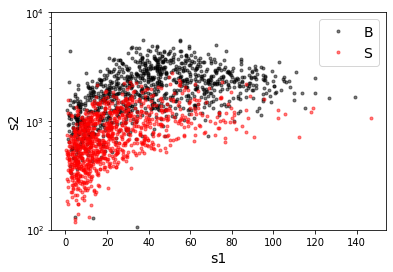

B_pdiffT.shape:  (5000,)
S_pdiffT.shape:  (5000,)


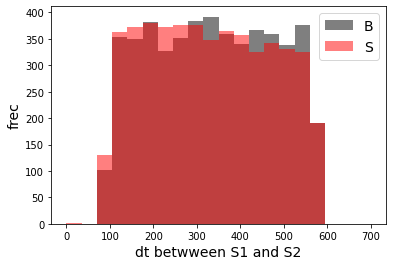

In [11]:

# CONCATENATE THE BACKGROUNDS
B_pbot = np.concatenate([B_pbot_ER[:NUM_DAT_ER], B_pbot_AC[:NUM_DAT_AC], B_pbot_CNNS[:NUM_DAT_CNNS], B_pbot_RN[:NUM_DAT_RN], B_pbot_WALL[:NUM_DAT_WALL]])
B_ptop = np.concatenate([B_ptop_ER[:NUM_DAT_ER], B_ptop_AC[:NUM_DAT_AC], B_ptop_CNNS[:NUM_DAT_CNNS], B_ptop_RN[:NUM_DAT_RN], B_ptop_WALL[:NUM_DAT_WALL]])
B_ppeakS1 = np.concatenate([B_ppeakS1_ER[:NUM_DAT_ER], B_ppeakS1_AC[:NUM_DAT_AC], B_ppeakS1_CNNS[:NUM_DAT_CNNS], B_ppeakS1_RN[:NUM_DAT_RN], B_ppeakS1_WALL[:NUM_DAT_WALL]])
B_ppeakS2 = np.concatenate([B_ppeakS2_ER[:NUM_DAT_ER], B_ppeakS2_AC[:NUM_DAT_AC], B_ppeakS2_CNNS[:NUM_DAT_CNNS], B_ppeakS2_RN[:NUM_DAT_RN], B_ppeakS2_WALL[:NUM_DAT_WALL]])

print('\nB_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


rnd = 100

B_pbot_plot, B_ptop_plot = shuffle(B_pbot, B_ptop, random_state=rnd)
S_pbot_plot, S_ptop_plot = shuffle(S_pbot, S_ptop, random_state=rnd)

plt.plot(B_pbot_plot[:1000], B_ptop_plot[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot_plot[:1000], S_ptop_plot[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()



# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [12]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 7)
B_ppeakS2.shape:  (5000, 7)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 7)
S_ppeakS2.shape:  (5000, 7)


## 1. No compressed features

In [13]:
X_mon = images

print('X_mon.shape: ', X_mon.shape)


# labels
y_mon = labels


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon.shape:  (10000, 75, 75, 4)

X_mon_train :  (6375, 75, 75, 4)
y_mon_train :  (6375,)
X_mon_val :  (1125, 75, 75, 4)
y_mon_val :  (1125,)
X_mon_test :  (2500, 75, 75, 4)
y_mon_test :  (2500,)



### XGBoost

In [14]:
# reshape to train XGBoost ( ALL CHANNELS )

X_mon_train_1D = np.reshape(X_mon_train, (len(X_mon_train), X_mon_train.shape[1]*X_mon_train.shape[2]*X_mon_train.shape[3]) )

X_mon_val_1D = np.reshape(X_mon_val, (len(X_mon_val), X_mon_val.shape[1]*X_mon_val.shape[2]*X_mon_val.shape[3]) )

X_mon_test_1D = np.reshape(X_mon_test, (len(X_mon_test), X_mon_test.shape[1]*X_mon_test.shape[2]*X_mon_test.shape[3]) )

print('X_mon_train_1D.shape: ', X_mon_train_1D.shape)
print('X_mon_val_1D.shape: ', X_mon_val_1D.shape)
print('X_mon_test_1D.shape: ', X_mon_test_1D.shape)

X_mon_train_1D.shape:  (6375, 22500)
X_mon_val_1D.shape:  (1125, 22500)
X_mon_test_1D.shape:  (2500, 22500)


In [15]:
# reshape to train XGBoost ( A SINGLE CHANNEL )

channel = 0

X_mon_train_1D = np.reshape(X_mon_train[:,:,:,channel], (len(X_mon_train), X_mon_train.shape[1]*X_mon_train.shape[2]) )

X_mon_val_1D = np.reshape(X_mon_val[:,:,:,channel], (len(X_mon_val), X_mon_val.shape[1]*X_mon_val.shape[2]) )

X_mon_test_1D = np.reshape(X_mon_test[:,:,:,channel], (len(X_mon_test), X_mon_test.shape[1]*X_mon_test.shape[2]) )

print('X_mon_train_1D.shape: ', X_mon_train_1D.shape)
print('X_mon_val_1D.shape: ', X_mon_val_1D.shape)
print('X_mon_test_1D.shape: ', X_mon_test_1D.shape)

X_mon_train_1D.shape:  (6375, 5625)
X_mon_val_1D.shape:  (1125, 5625)
X_mon_test_1D.shape:  (2500, 5625)


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68873	validation_1-logloss:0.68922
[1]	validation_0-logloss:0.68439	validation_1-logloss:0.68539
[2]	validation_0-logloss:0.68018	validation_1-logloss:0.68157
[3]	validation_0-logloss:0.67599	validation_1-logloss:0.67791
[4]	validation_0-logloss:0.67190	validation_1-logloss:0.67434
[5]	validation_0-logloss:0.66790	validation_1-logloss:0.67073
[6]	validation_0-logloss:0.66394	validation_1-logloss:0.66734
[7]	validation_0-logloss:0.66006	validation_1-logloss:0.66395
[8]	validation_0-logloss:0.65624	validation_1-logloss:0.66056
[9]	validation_0-logloss:0.65238	validation_1-logloss:0.65728
[10]	validation_0-logloss:0.64867	validation_1-logloss:0.65406
[11]	validation_0-logloss:0.64498	validation_1-logloss:0.65094
[12]	validation_0-logloss:0.64142	validation_1-logloss:0.64793
[13]	validation_0-logloss:0.63786	validation_1-logloss:0.64494
[14]	validation_0-logloss:0.63432	validation_1-logloss:0.64192
[15]	validation_0-logloss:0.63086	validation_1-logloss:0.63900
[1

[130]	validation_0-logloss:0.41324	validation_1-logloss:0.47890
[131]	validation_0-logloss:0.41221	validation_1-logloss:0.47832
[132]	validation_0-logloss:0.41113	validation_1-logloss:0.47765
[133]	validation_0-logloss:0.41007	validation_1-logloss:0.47701
[134]	validation_0-logloss:0.40908	validation_1-logloss:0.47654
[135]	validation_0-logloss:0.40808	validation_1-logloss:0.47593
[136]	validation_0-logloss:0.40712	validation_1-logloss:0.47530
[137]	validation_0-logloss:0.40607	validation_1-logloss:0.47472
[138]	validation_0-logloss:0.40508	validation_1-logloss:0.47420
[139]	validation_0-logloss:0.40411	validation_1-logloss:0.47363
[140]	validation_0-logloss:0.40312	validation_1-logloss:0.47310
[141]	validation_0-logloss:0.40218	validation_1-logloss:0.47276
[142]	validation_0-logloss:0.40114	validation_1-logloss:0.47220
[143]	validation_0-logloss:0.40021	validation_1-logloss:0.47176
[144]	validation_0-logloss:0.39919	validation_1-logloss:0.47120
[145]	validation_0-logloss:0.39821	valid

[259]	validation_0-logloss:0.31445	validation_1-logloss:0.43767
[260]	validation_0-logloss:0.31381	validation_1-logloss:0.43752
[261]	validation_0-logloss:0.31333	validation_1-logloss:0.43726
[262]	validation_0-logloss:0.31274	validation_1-logloss:0.43705
[263]	validation_0-logloss:0.31221	validation_1-logloss:0.43690
[264]	validation_0-logloss:0.31173	validation_1-logloss:0.43680
[265]	validation_0-logloss:0.31116	validation_1-logloss:0.43677
[266]	validation_0-logloss:0.31060	validation_1-logloss:0.43669
[267]	validation_0-logloss:0.31005	validation_1-logloss:0.43647
[268]	validation_0-logloss:0.30956	validation_1-logloss:0.43628
[269]	validation_0-logloss:0.30909	validation_1-logloss:0.43618
[270]	validation_0-logloss:0.30851	validation_1-logloss:0.43613
[271]	validation_0-logloss:0.30790	validation_1-logloss:0.43604
[272]	validation_0-logloss:0.30736	validation_1-logloss:0.43587
[273]	validation_0-logloss:0.30682	validation_1-logloss:0.43576
[274]	validation_0-logloss:0.30635	valid

[388]	validation_0-logloss:0.25430	validation_1-logloss:0.42459
[389]	validation_0-logloss:0.25384	validation_1-logloss:0.42442
[390]	validation_0-logloss:0.25345	validation_1-logloss:0.42454
[391]	validation_0-logloss:0.25303	validation_1-logloss:0.42436
[392]	validation_0-logloss:0.25268	validation_1-logloss:0.42423
[393]	validation_0-logloss:0.25228	validation_1-logloss:0.42419
[394]	validation_0-logloss:0.25186	validation_1-logloss:0.42411
[395]	validation_0-logloss:0.25145	validation_1-logloss:0.42396
[396]	validation_0-logloss:0.25104	validation_1-logloss:0.42374
[397]	validation_0-logloss:0.25072	validation_1-logloss:0.42358
[398]	validation_0-logloss:0.25035	validation_1-logloss:0.42356
[399]	validation_0-logloss:0.24996	validation_1-logloss:0.42359
[400]	validation_0-logloss:0.24955	validation_1-logloss:0.42343
[401]	validation_0-logloss:0.24914	validation_1-logloss:0.42340
[402]	validation_0-logloss:0.24876	validation_1-logloss:0.42334
[403]	validation_0-logloss:0.24841	valid

[517]	validation_0-logloss:0.21108	validation_1-logloss:0.41581
[518]	validation_0-logloss:0.21090	validation_1-logloss:0.41577
[519]	validation_0-logloss:0.21061	validation_1-logloss:0.41579
[520]	validation_0-logloss:0.21032	validation_1-logloss:0.41575
[521]	validation_0-logloss:0.21012	validation_1-logloss:0.41570
[522]	validation_0-logloss:0.20986	validation_1-logloss:0.41562
[523]	validation_0-logloss:0.20959	validation_1-logloss:0.41563
[524]	validation_0-logloss:0.20930	validation_1-logloss:0.41566
[525]	validation_0-logloss:0.20911	validation_1-logloss:0.41555
[526]	validation_0-logloss:0.20885	validation_1-logloss:0.41552
[527]	validation_0-logloss:0.20860	validation_1-logloss:0.41551
[528]	validation_0-logloss:0.20831	validation_1-logloss:0.41539
[529]	validation_0-logloss:0.20811	validation_1-logloss:0.41535
[530]	validation_0-logloss:0.20784	validation_1-logloss:0.41531
[531]	validation_0-logloss:0.20750	validation_1-logloss:0.41523
[532]	validation_0-logloss:0.20724	valid

[646]	validation_0-logloss:0.18079	validation_1-logloss:0.41165
[647]	validation_0-logloss:0.18063	validation_1-logloss:0.41168
[648]	validation_0-logloss:0.18043	validation_1-logloss:0.41167
[649]	validation_0-logloss:0.18019	validation_1-logloss:0.41163
[650]	validation_0-logloss:0.18004	validation_1-logloss:0.41155
[651]	validation_0-logloss:0.17985	validation_1-logloss:0.41162
[652]	validation_0-logloss:0.17961	validation_1-logloss:0.41163
[653]	validation_0-logloss:0.17948	validation_1-logloss:0.41165
[654]	validation_0-logloss:0.17933	validation_1-logloss:0.41161
[655]	validation_0-logloss:0.17919	validation_1-logloss:0.41166
[656]	validation_0-logloss:0.17897	validation_1-logloss:0.41159
[657]	validation_0-logloss:0.17875	validation_1-logloss:0.41157
[658]	validation_0-logloss:0.17850	validation_1-logloss:0.41167
[659]	validation_0-logloss:0.17828	validation_1-logloss:0.41163
[660]	validation_0-logloss:0.17808	validation_1-logloss:0.41169
[661]	validation_0-logloss:0.17786	valid

[775]	validation_0-logloss:0.15674	validation_1-logloss:0.41028
[776]	validation_0-logloss:0.15653	validation_1-logloss:0.41015
[777]	validation_0-logloss:0.15637	validation_1-logloss:0.41018
[778]	validation_0-logloss:0.15625	validation_1-logloss:0.41023
[779]	validation_0-logloss:0.15614	validation_1-logloss:0.41017
[780]	validation_0-logloss:0.15594	validation_1-logloss:0.41017
[781]	validation_0-logloss:0.15572	validation_1-logloss:0.41021
[782]	validation_0-logloss:0.15551	validation_1-logloss:0.41020
[783]	validation_0-logloss:0.15537	validation_1-logloss:0.41016
[784]	validation_0-logloss:0.15518	validation_1-logloss:0.41017
[785]	validation_0-logloss:0.15498	validation_1-logloss:0.41010
[786]	validation_0-logloss:0.15483	validation_1-logloss:0.41007
[787]	validation_0-logloss:0.15467	validation_1-logloss:0.41000
[788]	validation_0-logloss:0.15455	validation_1-logloss:0.41002
[789]	validation_0-logloss:0.15436	validation_1-logloss:0.40999
[790]	validation_0-logloss:0.15415	valid

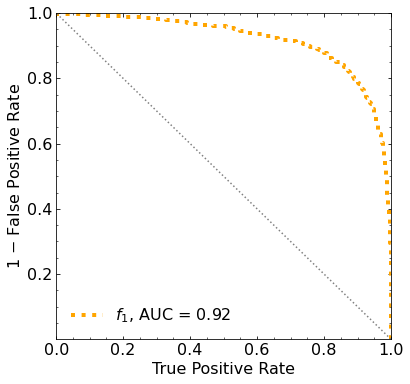

Classification score:


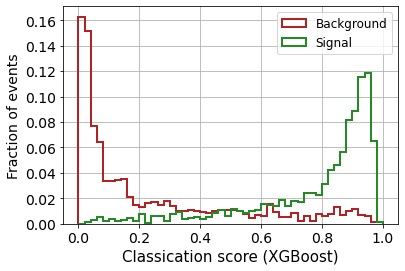


 ROC-AUC =  0.9186013459529223


In [16]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_1D,y_mon_train,eval_set=[(X_mon_train_1D, y_mon_train), (X_mon_val_1D, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_1D).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [30]:
# all channels
np.savetxt('rocs/roc_images.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9165219818490975


In [17]:
# channel 0
np.savetxt('rocs/roc_images.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9186013459529223


In [24]:
# channel 1
np.savetxt('rocs/roc_images.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9129611988609592


In [27]:
# channel 2
np.savetxt('rocs/roc_images.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9161974013070288


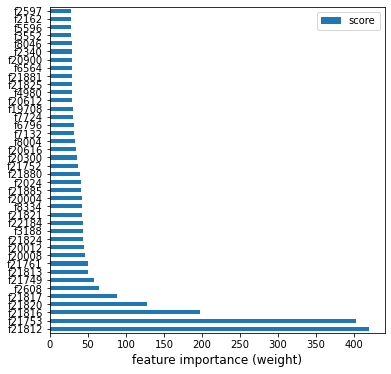

In [32]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN
lots of tests, the best is:

Dense layers: 1-4-8-16-32-64-128-256, 

Activation: LeakyReLu

##### Activation Leaky ReLu

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 16)                90016     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 68        
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)               

50/50 [==============================] - 0s 2ms/step - loss: 0.5024 - accuracy: 0.7672 - val_loss: 0.4888 - val_accuracy: 0.7751
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.7745 - val_loss: 0.4773 - val_accuracy: 0.7778
Epoch 108/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4932 - accuracy: 0.7780 - val_loss: 0.4625 - val_accuracy: 0.7938
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4812 - accuracy: 0.7830 - val_loss: 0.5112 - val_accuracy: 0.7707
Epoch 110/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5062 - accuracy: 0.7545 - val_loss: 0.4684 - val_accuracy: 0.7849
Epoch 111/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4699 - accuracy: 0.7790 - val_loss: 0.4705 - val_accuracy: 0.7920
Epoch 112/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4997 - accuracy: 0.7634 - val_loss: 0.5130 - val_accuracy: 0.7476
Epoch 1

Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4684 - accuracy: 0.7997 - val_loss: 0.4958 - val_accuracy: 0.7627
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4970 - accuracy: 0.7709 - val_loss: 0.4640 - val_accuracy: 0.7840
Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4820 - accuracy: 0.7713 - val_loss: 0.4486 - val_accuracy: 0.8080
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.7927 - val_loss: 0.4977 - val_accuracy: 0.7742
Epoch 167/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4750 - accuracy: 0.7825 - val_loss: 0.4568 - val_accuracy: 0.7858
Epoch 168/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.7775 - val_loss: 0.4519 - val_accuracy: 0.7849
Epoch 169/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4729 - accuracy: 0.7929 - val_loss: 0.4511 - val_accuracy:

Epoch 220/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.7673 - val_loss: 0.4747 - val_accuracy: 0.7653
Epoch 221/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4831 - accuracy: 0.7708 - val_loss: 0.4831 - val_accuracy: 0.7902
Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4900 - accuracy: 0.7698 - val_loss: 0.4621 - val_accuracy: 0.7840
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4557 - accuracy: 0.7976 - val_loss: 0.4329 - val_accuracy: 0.8107
Epoch 224/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7977 - val_loss: 0.4308 - val_accuracy: 0.8062
Epoch 225/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.7936 - val_loss: 0.4496 - val_accuracy: 0.7680
Epoch 226/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7983 - val_loss: 0.4472 - val_accuracy:

Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4661 - accuracy: 0.7857 - val_loss: 0.4468 - val_accuracy: 0.8018
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4565 - accuracy: 0.7963 - val_loss: 0.4317 - val_accuracy: 0.8116
Epoch 279/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4413 - accuracy: 0.8064 - val_loss: 0.4403 - val_accuracy: 0.8027
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4540 - accuracy: 0.8120 - val_loss: 0.4282 - val_accuracy: 0.8062
Epoch 281/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4414 - accuracy: 0.7989 - val_loss: 0.4262 - val_accuracy: 0.8098
Epoch 282/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.8045 - val_loss: 0.4791 - val_accuracy: 0.7476
Epoch 283/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4780 - accuracy: 0.7847 - val_loss: 0.4500 - val_accuracy:

Epoch 334/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.8160 - val_loss: 0.4250 - val_accuracy: 0.8062
Epoch 335/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4415 - accuracy: 0.8103 - val_loss: 0.4337 - val_accuracy: 0.8151
Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.8227 - val_loss: 0.4612 - val_accuracy: 0.8053
Epoch 337/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.8165 - val_loss: 0.4303 - val_accuracy: 0.8124
Epoch 338/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4466 - accuracy: 0.8072 - val_loss: 0.4260 - val_accuracy: 0.8107
Epoch 339/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.8119 - val_loss: 0.4377 - val_accuracy: 0.7920
Epoch 340/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.8135 - val_loss: 0.4239 - val_accuracy:

Epoch 391/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4261 - accuracy: 0.8184 - val_loss: 0.4306 - val_accuracy: 0.8089
Epoch 392/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4622 - accuracy: 0.7909 - val_loss: 0.4664 - val_accuracy: 0.7822
Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4317 - accuracy: 0.8134 - val_loss: 0.4228 - val_accuracy: 0.8089
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.8294 - val_loss: 0.4278 - val_accuracy: 0.8044
Epoch 395/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.8210 - val_loss: 0.4263 - val_accuracy: 0.8124
Epoch 396/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4216 - accuracy: 0.8206 - val_loss: 0.4244 - val_accuracy: 0.8098
Epoch 397/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4258 - accuracy: 0.8138 - val_loss: 0.4281 - val_accuracy:

Epoch 448/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8261 - val_loss: 0.4210 - val_accuracy: 0.8196
Epoch 449/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.8167 - val_loss: 0.4244 - val_accuracy: 0.8080
Epoch 450/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.8104 - val_loss: 0.4447 - val_accuracy: 0.7920
Epoch 451/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 0.8055 - val_loss: 0.4204 - val_accuracy: 0.8178
Epoch 452/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.8197 - val_loss: 0.4328 - val_accuracy: 0.8089
Epoch 453/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8069 - val_loss: 0.4477 - val_accuracy: 0.8009
Epoch 454/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4210 - accuracy: 0.8262 - val_loss: 0.4323 - val_accuracy:

Epoch 505/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4116 - accuracy: 0.8241 - val_loss: 0.4371 - val_accuracy: 0.8116
Epoch 506/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4187 - accuracy: 0.8331 - val_loss: 0.4370 - val_accuracy: 0.7947
Epoch 507/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4279 - accuracy: 0.8108 - val_loss: 0.4273 - val_accuracy: 0.8080
Epoch 508/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.8143 - val_loss: 0.5005 - val_accuracy: 0.7236
Epoch 509/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4433 - accuracy: 0.8076 - val_loss: 0.4415 - val_accuracy: 0.8027
Epoch 510/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.8247 - val_loss: 0.4268 - val_accuracy: 0.8018
Epoch 511/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.8147 - val_loss: 0.4188 - val_accuracy:

Epoch 562/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8199 - val_loss: 0.4514 - val_accuracy: 0.7902
Epoch 563/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.8227 - val_loss: 0.4334 - val_accuracy: 0.8116
Epoch 564/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4380 - accuracy: 0.8037 - val_loss: 0.4181 - val_accuracy: 0.8204
Epoch 565/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.8239 - val_loss: 0.4171 - val_accuracy: 0.8196
Epoch 566/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4189 - accuracy: 0.8238 - val_loss: 0.4467 - val_accuracy: 0.8178
Epoch 567/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.8208 - val_loss: 0.4576 - val_accuracy: 0.8187
Epoch 568/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.8256 - val_loss: 0.4596 - val_accuracy:

Epoch 619/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4182 - accuracy: 0.8199 - val_loss: 0.4396 - val_accuracy: 0.7964
Epoch 620/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4136 - accuracy: 0.8318 - val_loss: 0.4740 - val_accuracy: 0.8133
Epoch 621/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.8377 - val_loss: 0.4154 - val_accuracy: 0.8249
Epoch 622/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4055 - accuracy: 0.8367 - val_loss: 0.4367 - val_accuracy: 0.8027
Epoch 623/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.8189 - val_loss: 0.4355 - val_accuracy: 0.7902
Epoch 624/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4139 - accuracy: 0.8358 - val_loss: 0.4214 - val_accuracy: 0.8080
Epoch 625/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4125 - accuracy: 0.8229 - val_loss: 0.4193 - val_accuracy:

Epoch 676/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4044 - accuracy: 0.8296 - val_loss: 0.4230 - val_accuracy: 0.8053
Epoch 677/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4156 - accuracy: 0.8254 - val_loss: 0.4312 - val_accuracy: 0.8178
Epoch 678/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4292 - accuracy: 0.8213 - val_loss: 0.4385 - val_accuracy: 0.7938
Epoch 679/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.8445 - val_loss: 0.4188 - val_accuracy: 0.8169
Epoch 680/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4013 - accuracy: 0.8352 - val_loss: 0.4324 - val_accuracy: 0.7938
Epoch 681/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4110 - accuracy: 0.8276 - val_loss: 0.4353 - val_accuracy: 0.7938
Epoch 682/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4041 - accuracy: 0.8350 - val_loss: 0.4202 - val_accuracy:

Epoch 733/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.8043 - val_loss: 0.4404 - val_accuracy: 0.7822
Epoch 734/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.8060 - val_loss: 0.4129 - val_accuracy: 0.8240
Epoch 735/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4254 - accuracy: 0.8255 - val_loss: 0.4466 - val_accuracy: 0.7769
Epoch 736/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4141 - accuracy: 0.8325 - val_loss: 0.4174 - val_accuracy: 0.8196
Epoch 737/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4184 - accuracy: 0.8274 - val_loss: 0.4268 - val_accuracy: 0.8222
Epoch 738/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8220 - val_loss: 0.4244 - val_accuracy: 0.8169
Epoch 739/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4041 - accuracy: 0.8275 - val_loss: 0.4387 - val_accuracy:

Epoch 790/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3983 - accuracy: 0.8391 - val_loss: 0.4213 - val_accuracy: 0.8204
Epoch 791/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4000 - accuracy: 0.8310 - val_loss: 0.4254 - val_accuracy: 0.8213
Epoch 792/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.8287 - val_loss: 0.4438 - val_accuracy: 0.8169
Epoch 793/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3890 - accuracy: 0.8447 - val_loss: 0.4223 - val_accuracy: 0.8213
Epoch 794/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8207 - val_loss: 0.4300 - val_accuracy: 0.7893
Epoch 795/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4241 - accuracy: 0.8197 - val_loss: 0.4238 - val_accuracy: 0.8151
Epoch 796/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8242 - val_loss: 0.4267 - val_accuracy:

Epoch 847/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.8415 - val_loss: 0.4125 - val_accuracy: 0.8213
Epoch 848/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4124 - accuracy: 0.8316 - val_loss: 0.4520 - val_accuracy: 0.7964
Epoch 849/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8418 - val_loss: 0.4303 - val_accuracy: 0.8249
Epoch 850/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3878 - accuracy: 0.8445 - val_loss: 0.4310 - val_accuracy: 0.8196
Epoch 851/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.8203 - val_loss: 0.4222 - val_accuracy: 0.8089
Epoch 852/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3951 - accuracy: 0.8371 - val_loss: 0.4177 - val_accuracy: 0.8258
Epoch 853/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8165 - val_loss: 0.4452 - val_accuracy:

Epoch 904/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.8226 - val_loss: 0.4308 - val_accuracy: 0.8027
Epoch 905/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4120 - accuracy: 0.8275 - val_loss: 0.4326 - val_accuracy: 0.8124
Epoch 906/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3869 - accuracy: 0.8369 - val_loss: 0.4117 - val_accuracy: 0.8258
Epoch 907/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8372 - val_loss: 0.4180 - val_accuracy: 0.8267
Epoch 908/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3862 - accuracy: 0.8395 - val_loss: 0.4235 - val_accuracy: 0.8240
Epoch 909/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8407 - val_loss: 0.4595 - val_accuracy: 0.7902
Epoch 910/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4120 - accuracy: 0.8264 - val_loss: 0.4321 - val_accuracy:

Epoch 961/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8354 - val_loss: 0.4142 - val_accuracy: 0.8213
Epoch 962/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3745 - accuracy: 0.8460 - val_loss: 0.4277 - val_accuracy: 0.8169
Epoch 963/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3789 - accuracy: 0.8456 - val_loss: 0.4462 - val_accuracy: 0.8213
Epoch 964/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3883 - accuracy: 0.8424 - val_loss: 0.4261 - val_accuracy: 0.7991
Epoch 965/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8292 - val_loss: 0.4186 - val_accuracy: 0.8089
Epoch 966/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3881 - accuracy: 0.8416 - val_loss: 0.4107 - val_accuracy: 0.8196
Epoch 967/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3782 - accuracy: 0.8493 - val_loss: 0.4154 - val_accuracy:

Epoch 1018/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4000 - accuracy: 0.8342 - val_loss: 0.4527 - val_accuracy: 0.7822
Epoch 1019/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4136 - accuracy: 0.8262 - val_loss: 0.4249 - val_accuracy: 0.8062
Epoch 1020/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.8351 - val_loss: 0.4752 - val_accuracy: 0.8196
Epoch 1021/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3900 - accuracy: 0.8491 - val_loss: 0.4604 - val_accuracy: 0.8196
Epoch 1022/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3925 - accuracy: 0.8373 - val_loss: 0.4281 - val_accuracy: 0.8222
Epoch 1023/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3915 - accuracy: 0.8404 - val_loss: 0.4287 - val_accuracy: 0.8062
Epoch 1024/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3759 - accuracy: 0.8424 - val_loss: 0.4391 - val_ac

50/50 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8538 - val_loss: 0.4161 - val_accuracy: 0.8204
Epoch 1131/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.8430 - val_loss: 0.4491 - val_accuracy: 0.8178
Epoch 1132/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3865 - accuracy: 0.8434 - val_loss: 0.4612 - val_accuracy: 0.8231
Epoch 1133/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3889 - accuracy: 0.8342 - val_loss: 0.4715 - val_accuracy: 0.8258
Epoch 1134/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.8355 - val_loss: 0.4576 - val_accuracy: 0.7778
Epoch 1135/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4168 - accuracy: 0.8172 - val_loss: 0.4150 - val_accuracy: 0.8151
Epoch 1136/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3899 - accuracy: 0.8353 - val_loss: 0.4142 - val_accuracy: 0.8249
E

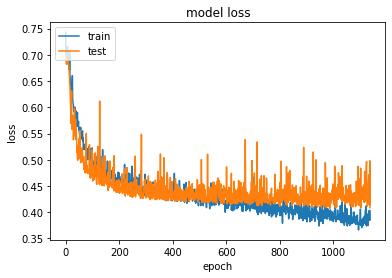

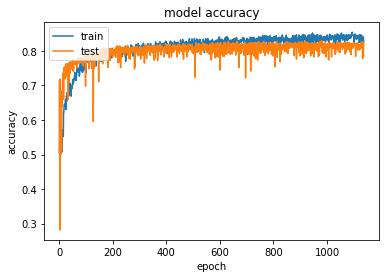

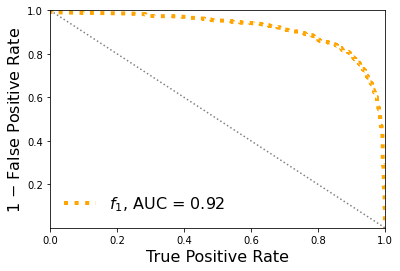

Classification score:


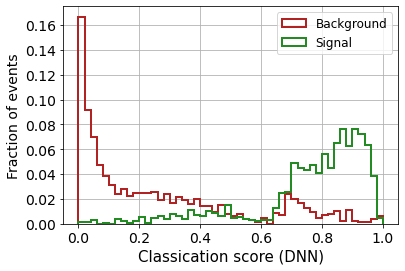


 ROC-AUC =  0.915486461086186


In [55]:

# define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [56]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.915486461086186


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                180032    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                

50/50 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.7927 - val_loss: 0.4676 - val_accuracy: 0.7733
Epoch 104/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4821 - accuracy: 0.7822 - val_loss: 0.4667 - val_accuracy: 0.7964
Epoch 105/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.7870 - val_loss: 0.4890 - val_accuracy: 0.7716
Epoch 106/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4585 - accuracy: 0.7939 - val_loss: 0.4469 - val_accuracy: 0.7884
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.7925 - val_loss: 0.4588 - val_accuracy: 0.8000
Epoch 108/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4597 - accuracy: 0.8011 - val_loss: 0.4509 - val_accuracy: 0.8009
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4900 - accuracy: 0.7786 - val_loss: 0.4439 - val_accuracy: 0.7796
Epoch 1

Epoch 160/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4562 - accuracy: 0.7999 - val_loss: 0.4331 - val_accuracy: 0.7964
Epoch 161/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.8054 - val_loss: 0.4311 - val_accuracy: 0.8124
Epoch 162/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4443 - accuracy: 0.8021 - val_loss: 0.4317 - val_accuracy: 0.8018
Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4501 - accuracy: 0.8086 - val_loss: 0.4441 - val_accuracy: 0.7867
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4447 - accuracy: 0.8078 - val_loss: 0.4254 - val_accuracy: 0.8098
Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4648 - accuracy: 0.7881 - val_loss: 0.4334 - val_accuracy: 0.8044
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.8185 - val_loss: 0.4335 - val_accuracy:

Epoch 217/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4182 - accuracy: 0.8217 - val_loss: 0.4264 - val_accuracy: 0.8080
Epoch 218/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.8238 - val_loss: 0.4388 - val_accuracy: 0.8000
Epoch 219/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4226 - accuracy: 0.8152 - val_loss: 0.4317 - val_accuracy: 0.8098
Epoch 220/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.8083 - val_loss: 0.4680 - val_accuracy: 0.7920
Epoch 221/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.7915 - val_loss: 0.4224 - val_accuracy: 0.8160
Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4246 - accuracy: 0.8077 - val_loss: 0.4225 - val_accuracy: 0.8124
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.8077 - val_loss: 0.4128 - val_accuracy:

Epoch 274/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.8159 - val_loss: 0.4196 - val_accuracy: 0.8213
Epoch 275/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4184 - accuracy: 0.8317 - val_loss: 0.4135 - val_accuracy: 0.8196
Epoch 276/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3963 - accuracy: 0.8362 - val_loss: 0.4129 - val_accuracy: 0.8231
Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8240 - val_loss: 0.4320 - val_accuracy: 0.8098
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4236 - accuracy: 0.8130 - val_loss: 0.4247 - val_accuracy: 0.8107
Epoch 279/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4148 - accuracy: 0.8281 - val_loss: 0.4302 - val_accuracy: 0.8133
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4055 - accuracy: 0.8292 - val_loss: 0.4350 - val_accuracy:

Epoch 331/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4536 - accuracy: 0.8041 - val_loss: 0.4324 - val_accuracy: 0.8089
Epoch 332/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8250 - val_loss: 0.4415 - val_accuracy: 0.8151
Epoch 333/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4675 - accuracy: 0.7826 - val_loss: 0.4317 - val_accuracy: 0.8080
Epoch 334/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.8124 - val_loss: 0.4146 - val_accuracy: 0.8160
Epoch 335/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8288 - val_loss: 0.4144 - val_accuracy: 0.8178
Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4112 - accuracy: 0.8284 - val_loss: 0.4139 - val_accuracy: 0.8160
Epoch 337/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4052 - accuracy: 0.8281 - val_loss: 0.4244 - val_accuracy:

Epoch 388/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4019 - accuracy: 0.8337 - val_loss: 0.4388 - val_accuracy: 0.8142
Epoch 389/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3992 - accuracy: 0.8375 - val_loss: 0.4093 - val_accuracy: 0.8293
Epoch 390/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4096 - accuracy: 0.8286 - val_loss: 0.4142 - val_accuracy: 0.8204
Epoch 391/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4407 - accuracy: 0.8032 - val_loss: 0.4122 - val_accuracy: 0.8133
Epoch 392/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3915 - accuracy: 0.8369 - val_loss: 0.4098 - val_accuracy: 0.8142
Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8333 - val_loss: 0.4108 - val_accuracy: 0.8213
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3910 - accuracy: 0.8397 - val_loss: 0.4176 - val_accuracy:

Epoch 445/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4046 - accuracy: 0.8260 - val_loss: 0.4217 - val_accuracy: 0.8160
Epoch 446/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4224 - accuracy: 0.8167 - val_loss: 0.4157 - val_accuracy: 0.8116
Epoch 447/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.8107 - val_loss: 0.4641 - val_accuracy: 0.7982
Epoch 448/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8227 - val_loss: 0.4212 - val_accuracy: 0.8222
Epoch 449/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4028 - accuracy: 0.8266 - val_loss: 0.4047 - val_accuracy: 0.8142
Epoch 450/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3955 - accuracy: 0.8352 - val_loss: 0.4155 - val_accuracy: 0.8151
Epoch 451/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3927 - accuracy: 0.8333 - val_loss: 0.4355 - val_accuracy:

Epoch 502/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4048 - accuracy: 0.8250 - val_loss: 0.4098 - val_accuracy: 0.8293
Epoch 503/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3973 - accuracy: 0.8345 - val_loss: 0.4122 - val_accuracy: 0.8187
Epoch 504/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3888 - accuracy: 0.8352 - val_loss: 0.4318 - val_accuracy: 0.7920
Epoch 505/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8230 - val_loss: 0.4064 - val_accuracy: 0.8249
Epoch 506/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.8091 - val_loss: 0.4298 - val_accuracy: 0.8124
Epoch 507/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8370 - val_loss: 0.4211 - val_accuracy: 0.8222
Epoch 508/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3849 - accuracy: 0.8332 - val_loss: 0.4064 - val_accuracy:

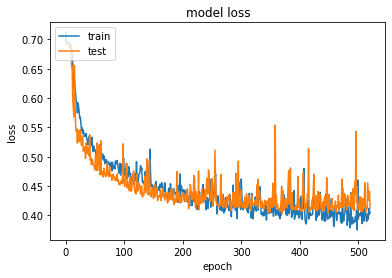

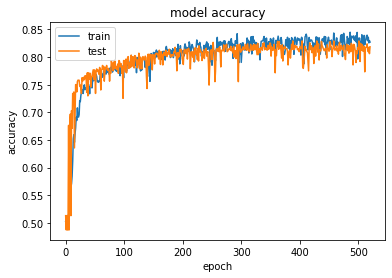

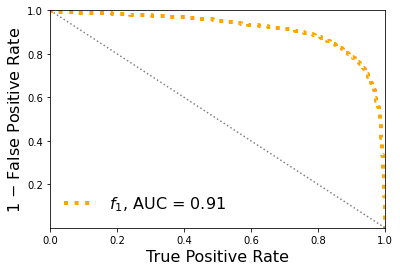

Classification score:


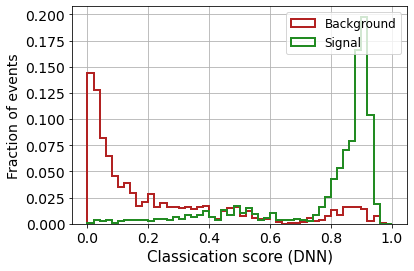


 ROC-AUC =  0.9148945977505992


In [37]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [38]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9148945977505992


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                360064    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)               

Epoch 44/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5266 - accuracy: 0.7607 - val_loss: 0.4822 - val_accuracy: 0.7724
Epoch 45/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5127 - accuracy: 0.7564 - val_loss: 0.4850 - val_accuracy: 0.7733
Epoch 46/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5093 - accuracy: 0.7623 - val_loss: 0.5294 - val_accuracy: 0.7253
Epoch 47/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5359 - accuracy: 0.7350 - val_loss: 0.4777 - val_accuracy: 0.7724
Epoch 48/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5009 - accuracy: 0.7766 - val_loss: 0.4899 - val_accuracy: 0.7573
Epoch 49/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5180 - accuracy: 0.7564 - val_loss: 0.4819 - val_accuracy: 0.7760
Epoch 50/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7692 - val_loss: 0.4922 - val_accuracy: 0.7724

Epoch 158/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4799 - accuracy: 0.7761 - val_loss: 0.4363 - val_accuracy: 0.7956
Epoch 159/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4484 - accuracy: 0.7938 - val_loss: 0.4473 - val_accuracy: 0.7902
Epoch 160/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4413 - accuracy: 0.8131 - val_loss: 0.4328 - val_accuracy: 0.8089
Epoch 161/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4321 - accuracy: 0.8246 - val_loss: 0.4313 - val_accuracy: 0.8027
Epoch 162/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.8134 - val_loss: 0.4329 - val_accuracy: 0.8018
Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.7961 - val_loss: 0.4400 - val_accuracy: 0.7973
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4498 - accuracy: 0.8131 - val_loss: 0.4542 - val_accuracy:

Epoch 215/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8278 - val_loss: 0.4684 - val_accuracy: 0.7858
Epoch 216/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.7982 - val_loss: 0.4296 - val_accuracy: 0.7991
Epoch 217/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4246 - accuracy: 0.8241 - val_loss: 0.4636 - val_accuracy: 0.8044
Epoch 218/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4577 - accuracy: 0.8023 - val_loss: 0.4282 - val_accuracy: 0.8116
Epoch 219/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4322 - accuracy: 0.8165 - val_loss: 0.4263 - val_accuracy: 0.8009
Epoch 220/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4310 - accuracy: 0.8123 - val_loss: 0.4345 - val_accuracy: 0.8036
Epoch 221/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4240 - accuracy: 0.8175 - val_loss: 0.4869 - val_accuracy:

Epoch 272/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8131 - val_loss: 0.4848 - val_accuracy: 0.7778
Epoch 273/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4500 - accuracy: 0.8017 - val_loss: 0.4455 - val_accuracy: 0.7991
Epoch 274/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4193 - accuracy: 0.8184 - val_loss: 0.4141 - val_accuracy: 0.8178
Epoch 275/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4264 - accuracy: 0.8156 - val_loss: 0.4069 - val_accuracy: 0.8231
Epoch 276/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3980 - accuracy: 0.8355 - val_loss: 0.4135 - val_accuracy: 0.8204
Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4194 - accuracy: 0.8212 - val_loss: 0.4519 - val_accuracy: 0.7991
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.8109 - val_loss: 0.4150 - val_accuracy:

Epoch 329/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3974 - accuracy: 0.8425 - val_loss: 0.4249 - val_accuracy: 0.7991
Epoch 330/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4286 - accuracy: 0.8181 - val_loss: 0.4393 - val_accuracy: 0.8071
Epoch 331/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4026 - accuracy: 0.8300 - val_loss: 0.4216 - val_accuracy: 0.8089
Epoch 332/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4465 - accuracy: 0.8103 - val_loss: 0.4272 - val_accuracy: 0.8169
Epoch 333/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4151 - accuracy: 0.8266 - val_loss: 0.4130 - val_accuracy: 0.8169
Epoch 334/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4203 - accuracy: 0.8238 - val_loss: 0.4194 - val_accuracy: 0.8160
Epoch 335/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4177 - accuracy: 0.8262 - val_loss: 0.4291 - val_accuracy:

Epoch 386/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4029 - accuracy: 0.8310 - val_loss: 0.4280 - val_accuracy: 0.8204
Epoch 387/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8300 - val_loss: 0.4283 - val_accuracy: 0.8071
Epoch 388/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4211 - accuracy: 0.8173 - val_loss: 0.4513 - val_accuracy: 0.8160
Epoch 389/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8332 - val_loss: 0.4412 - val_accuracy: 0.8036
Epoch 390/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4383 - accuracy: 0.8088 - val_loss: 0.4260 - val_accuracy: 0.8053
Epoch 391/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8299 - val_loss: 0.4186 - val_accuracy: 0.8196
Epoch 392/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4140 - accuracy: 0.8248 - val_loss: 0.4406 - val_accuracy:

Epoch 443/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3949 - accuracy: 0.8337 - val_loss: 0.4232 - val_accuracy: 0.8062
Epoch 444/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4368 - accuracy: 0.8099 - val_loss: 0.4258 - val_accuracy: 0.8116
Epoch 445/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3940 - accuracy: 0.8389 - val_loss: 0.4145 - val_accuracy: 0.8204
Epoch 446/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3881 - accuracy: 0.8310 - val_loss: 0.4176 - val_accuracy: 0.8080
Epoch 447/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3976 - accuracy: 0.8364 - val_loss: 0.4201 - val_accuracy: 0.8204
Epoch 448/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3966 - accuracy: 0.8355 - val_loss: 0.4233 - val_accuracy: 0.8044
Epoch 449/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.8288 - val_loss: 0.4140 - val_accuracy:

Epoch 500/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 0.8169 - val_loss: 0.4157 - val_accuracy: 0.8151
Epoch 501/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4215 - accuracy: 0.8240 - val_loss: 0.4128 - val_accuracy: 0.8142
Epoch 502/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4062 - accuracy: 0.8251 - val_loss: 0.4466 - val_accuracy: 0.8071
Epoch 503/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3978 - accuracy: 0.8389 - val_loss: 0.4047 - val_accuracy: 0.8231
Epoch 504/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4107 - accuracy: 0.8356 - val_loss: 0.4088 - val_accuracy: 0.8187
Epoch 505/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3987 - accuracy: 0.8396 - val_loss: 0.4148 - val_accuracy: 0.8204
Epoch 506/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4044 - accuracy: 0.8288 - val_loss: 0.4163 - val_accuracy:

Epoch 557/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3916 - accuracy: 0.8388 - val_loss: 0.4197 - val_accuracy: 0.8160
Epoch 558/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3991 - accuracy: 0.8400 - val_loss: 0.4094 - val_accuracy: 0.8160
Epoch 559/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8268 - val_loss: 0.4083 - val_accuracy: 0.8160
Epoch 560/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3930 - accuracy: 0.8395 - val_loss: 0.4110 - val_accuracy: 0.8276
Epoch 561/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4070 - accuracy: 0.8319 - val_loss: 0.4392 - val_accuracy: 0.8044
Epoch 562/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3872 - accuracy: 0.8400 - val_loss: 0.4098 - val_accuracy: 0.8204
Epoch 563/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4048 - accuracy: 0.8285 - val_loss: 0.4244 - val_accuracy:

Epoch 614/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4136 - accuracy: 0.8232 - val_loss: 0.4046 - val_accuracy: 0.8231
Epoch 615/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4000 - accuracy: 0.8273 - val_loss: 0.4346 - val_accuracy: 0.8151
Epoch 616/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8201 - val_loss: 0.4795 - val_accuracy: 0.8044
Epoch 617/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3921 - accuracy: 0.8358 - val_loss: 0.4328 - val_accuracy: 0.7929
Epoch 618/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3817 - accuracy: 0.8418 - val_loss: 0.4319 - val_accuracy: 0.8080
Epoch 619/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4094 - accuracy: 0.8268 - val_loss: 0.4296 - val_accuracy: 0.8142
Epoch 620/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4193 - accuracy: 0.8175 - val_loss: 0.4238 - val_accuracy:

Epoch 671/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3988 - accuracy: 0.8262 - val_loss: 0.4014 - val_accuracy: 0.8284
Epoch 672/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4384 - accuracy: 0.8078 - val_loss: 0.4300 - val_accuracy: 0.8044
Epoch 673/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8262 - val_loss: 0.4243 - val_accuracy: 0.8018
Epoch 674/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3935 - accuracy: 0.8307 - val_loss: 0.4050 - val_accuracy: 0.8196
Epoch 675/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3807 - accuracy: 0.8431 - val_loss: 0.4586 - val_accuracy: 0.7867
Epoch 676/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4179 - accuracy: 0.8269 - val_loss: 0.4242 - val_accuracy: 0.8187
Epoch 677/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3595 - accuracy: 0.8489 - val_loss: 0.4046 - val_accuracy:

Epoch 728/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3909 - accuracy: 0.8303 - val_loss: 0.4150 - val_accuracy: 0.8116
Epoch 729/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4073 - accuracy: 0.8295 - val_loss: 0.4186 - val_accuracy: 0.8124
Epoch 730/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3861 - accuracy: 0.8409 - val_loss: 0.4155 - val_accuracy: 0.8062
Epoch 731/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3529 - accuracy: 0.8510 - val_loss: 0.4595 - val_accuracy: 0.8124
Epoch 732/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3927 - accuracy: 0.8377 - val_loss: 0.4280 - val_accuracy: 0.8222
Epoch 733/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3635 - accuracy: 0.8462 - val_loss: 0.3985 - val_accuracy: 0.8231
Epoch 734/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3833 - accuracy: 0.8285 - val_loss: 0.4274 - val_accuracy:

Epoch 785/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3800 - accuracy: 0.8464 - val_loss: 0.4311 - val_accuracy: 0.8009
Epoch 786/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3640 - accuracy: 0.8386 - val_loss: 0.4148 - val_accuracy: 0.8089
Epoch 787/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.8388 - val_loss: 0.4045 - val_accuracy: 0.8222
Epoch 788/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3753 - accuracy: 0.8385 - val_loss: 0.4022 - val_accuracy: 0.8098
Epoch 789/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3629 - accuracy: 0.8459 - val_loss: 0.3985 - val_accuracy: 0.8240
Epoch 790/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4011 - accuracy: 0.8257 - val_loss: 0.4259 - val_accuracy: 0.8080
Epoch 791/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3685 - accuracy: 0.8416 - val_loss: 0.4204 - val_accuracy:

Epoch 842/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3615 - accuracy: 0.8454 - val_loss: 0.4417 - val_accuracy: 0.8124
Epoch 843/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3884 - accuracy: 0.8372 - val_loss: 0.4444 - val_accuracy: 0.7822
Epoch 844/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3778 - accuracy: 0.8351 - val_loss: 0.4195 - val_accuracy: 0.8142
Epoch 845/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3722 - accuracy: 0.8449 - val_loss: 0.4104 - val_accuracy: 0.8178
Epoch 846/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3703 - accuracy: 0.8446 - val_loss: 0.4015 - val_accuracy: 0.8187
Epoch 847/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8431 - val_loss: 0.6086 - val_accuracy: 0.7271
Epoch 848/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4131 - accuracy: 0.8261 - val_loss: 0.4169 - val_accuracy:

Epoch 899/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8474 - val_loss: 0.3984 - val_accuracy: 0.8249
Epoch 900/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3618 - accuracy: 0.8445 - val_loss: 0.4118 - val_accuracy: 0.8187
Epoch 901/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3570 - accuracy: 0.8485 - val_loss: 0.4134 - val_accuracy: 0.8231
Epoch 902/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.8352 - val_loss: 0.4208 - val_accuracy: 0.8160
Epoch 903/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8493 - val_loss: 0.4034 - val_accuracy: 0.8196
Epoch 904/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.8335 - val_loss: 0.4227 - val_accuracy: 0.8258
Epoch 905/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3325 - accuracy: 0.8637 - val_loss: 0.4191 - val_accuracy:

Epoch 956/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8410 - val_loss: 0.4105 - val_accuracy: 0.8178
Epoch 957/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3572 - accuracy: 0.8518 - val_loss: 0.4157 - val_accuracy: 0.8178
Epoch 958/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3869 - accuracy: 0.8346 - val_loss: 0.4399 - val_accuracy: 0.8222
Epoch 959/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3735 - accuracy: 0.8380 - val_loss: 0.4044 - val_accuracy: 0.8222
Epoch 960/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3675 - accuracy: 0.8439 - val_loss: 0.4281 - val_accuracy: 0.8249
Epoch 961/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8331 - val_loss: 0.4067 - val_accuracy: 0.8187
Epoch 962/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3725 - accuracy: 0.8413 - val_loss: 0.4163 - val_accuracy:

Epoch 1013/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3621 - accuracy: 0.8480 - val_loss: 0.4172 - val_accuracy: 0.8231
Epoch 1014/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3540 - accuracy: 0.8531 - val_loss: 0.4054 - val_accuracy: 0.8231
Epoch 1015/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3458 - accuracy: 0.8538 - val_loss: 0.4945 - val_accuracy: 0.8080
Epoch 1016/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3585 - accuracy: 0.8465 - val_loss: 0.4082 - val_accuracy: 0.8240
Epoch 1017/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3476 - accuracy: 0.8529 - val_loss: 0.3990 - val_accuracy: 0.8240
Epoch 1018/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3484 - accuracy: 0.8505 - val_loss: 0.4298 - val_accuracy: 0.8151
Epoch 1019/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3593 - accuracy: 0.8497 - val_loss: 0.4125 - val_ac

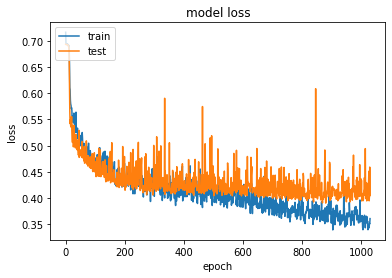

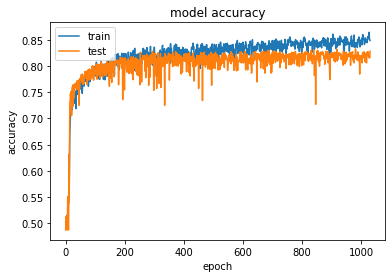

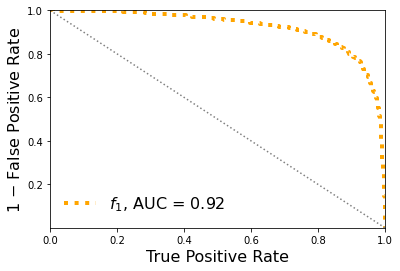

Classification score:


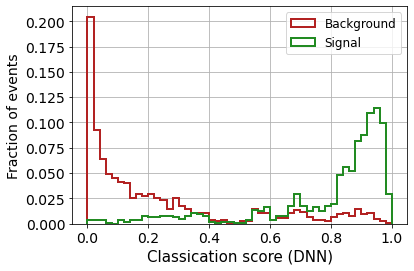


 ROC-AUC =  0.921815141458218


In [39]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [40]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.921815141458218


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               720128    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)               

50/50 [==============================] - 0s 4ms/step - loss: 0.5721 - accuracy: 0.7130 - val_loss: 0.5789 - val_accuracy: 0.6844
Epoch 42/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.6227 - accuracy: 0.6656 - val_loss: 0.5385 - val_accuracy: 0.7644
Epoch 43/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.5718 - accuracy: 0.7052 - val_loss: 0.5078 - val_accuracy: 0.7618
Epoch 44/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.5804 - accuracy: 0.7058 - val_loss: 0.5229 - val_accuracy: 0.7440
Epoch 45/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.5689 - accuracy: 0.7136 - val_loss: 0.5434 - val_accuracy: 0.7236
Epoch 46/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.5600 - accuracy: 0.7301 - val_loss: 0.5395 - val_accuracy: 0.7467
Epoch 47/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.5625 - accuracy: 0.7220 - val_loss: 0.5132 - val_accuracy: 0.7582
Epoch 48/1500

50/50 [==============================] - 0s 4ms/step - loss: 0.4595 - accuracy: 0.7998 - val_loss: 0.4446 - val_accuracy: 0.7982
Epoch 156/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4724 - accuracy: 0.7867 - val_loss: 0.4989 - val_accuracy: 0.7902
Epoch 157/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.5013 - accuracy: 0.7726 - val_loss: 0.4987 - val_accuracy: 0.7378
Epoch 158/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4987 - accuracy: 0.7683 - val_loss: 0.4687 - val_accuracy: 0.7716
Epoch 159/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4649 - accuracy: 0.7878 - val_loss: 0.4421 - val_accuracy: 0.8044
Epoch 160/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4569 - accuracy: 0.8009 - val_loss: 0.4420 - val_accuracy: 0.8036
Epoch 161/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4646 - accuracy: 0.7920 - val_loss: 0.4697 - val_accuracy: 0.7716
Epoch 1

Epoch 212/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4399 - accuracy: 0.8089 - val_loss: 0.4225 - val_accuracy: 0.8062
Epoch 213/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4509 - accuracy: 0.8044 - val_loss: 0.4329 - val_accuracy: 0.7964
Epoch 214/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4450 - accuracy: 0.8145 - val_loss: 0.4219 - val_accuracy: 0.8124
Epoch 215/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4231 - accuracy: 0.8229 - val_loss: 0.4551 - val_accuracy: 0.7893
Epoch 216/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4591 - accuracy: 0.7990 - val_loss: 0.4785 - val_accuracy: 0.7991
Epoch 217/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.8039 - val_loss: 0.4294 - val_accuracy: 0.8044
Epoch 218/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4409 - accuracy: 0.8200 - val_loss: 0.4287 - val_accuracy:

Epoch 269/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4263 - accuracy: 0.8220 - val_loss: 0.4189 - val_accuracy: 0.8142
Epoch 270/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4169 - accuracy: 0.8217 - val_loss: 0.4290 - val_accuracy: 0.8080
Epoch 271/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4213 - accuracy: 0.8209 - val_loss: 0.4190 - val_accuracy: 0.8116
Epoch 272/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4347 - accuracy: 0.8134 - val_loss: 0.4315 - val_accuracy: 0.8098
Epoch 273/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4251 - accuracy: 0.8231 - val_loss: 0.4186 - val_accuracy: 0.8107
Epoch 274/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4251 - accuracy: 0.8258 - val_loss: 0.4350 - val_accuracy: 0.8018
Epoch 275/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4168 - accuracy: 0.8168 - val_loss: 0.4196 - val_accuracy:

Epoch 326/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4095 - accuracy: 0.8286 - val_loss: 0.4109 - val_accuracy: 0.8142
Epoch 327/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4356 - accuracy: 0.8154 - val_loss: 0.4402 - val_accuracy: 0.7884
Epoch 328/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4371 - accuracy: 0.8134 - val_loss: 0.4325 - val_accuracy: 0.7991
Epoch 329/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4249 - accuracy: 0.8200 - val_loss: 0.4238 - val_accuracy: 0.8116
Epoch 330/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4186 - accuracy: 0.8175 - val_loss: 0.4478 - val_accuracy: 0.7991
Epoch 331/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4322 - accuracy: 0.8089 - val_loss: 0.4450 - val_accuracy: 0.7982
Epoch 332/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4563 - accuracy: 0.8017 - val_loss: 0.4751 - val_accuracy:

Epoch 383/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3988 - accuracy: 0.8291 - val_loss: 0.4067 - val_accuracy: 0.8116
Epoch 384/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3948 - accuracy: 0.8318 - val_loss: 0.4048 - val_accuracy: 0.8133
Epoch 385/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3946 - accuracy: 0.8360 - val_loss: 0.4170 - val_accuracy: 0.8098
Epoch 386/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3902 - accuracy: 0.8314 - val_loss: 0.4300 - val_accuracy: 0.8009
Epoch 387/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.8193 - val_loss: 0.4387 - val_accuracy: 0.8036
Epoch 388/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4347 - accuracy: 0.8094 - val_loss: 0.4496 - val_accuracy: 0.8098
Epoch 389/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4511 - accuracy: 0.8011 - val_loss: 0.4575 - val_accuracy:

Epoch 440/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3840 - accuracy: 0.8405 - val_loss: 0.3988 - val_accuracy: 0.8284
Epoch 441/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3780 - accuracy: 0.8375 - val_loss: 0.4007 - val_accuracy: 0.8276
Epoch 442/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3805 - accuracy: 0.8401 - val_loss: 0.4263 - val_accuracy: 0.8053
Epoch 443/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4051 - accuracy: 0.8274 - val_loss: 0.4156 - val_accuracy: 0.8116
Epoch 444/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8123 - val_loss: 0.4110 - val_accuracy: 0.8098
Epoch 445/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3996 - accuracy: 0.8290 - val_loss: 0.4160 - val_accuracy: 0.8089
Epoch 446/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4021 - accuracy: 0.8281 - val_loss: 0.4160 - val_accuracy:

Epoch 497/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.8355 - val_loss: 0.4256 - val_accuracy: 0.8151
Epoch 498/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3941 - accuracy: 0.8311 - val_loss: 0.4052 - val_accuracy: 0.8196
Epoch 499/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3841 - accuracy: 0.8354 - val_loss: 0.4304 - val_accuracy: 0.8107
Epoch 500/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.8397 - val_loss: 0.4856 - val_accuracy: 0.7760
Epoch 501/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4192 - accuracy: 0.8188 - val_loss: 0.4097 - val_accuracy: 0.8160
Epoch 502/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4213 - accuracy: 0.8165 - val_loss: 0.4387 - val_accuracy: 0.7991
Epoch 503/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3852 - accuracy: 0.8334 - val_loss: 0.4058 - val_accuracy:

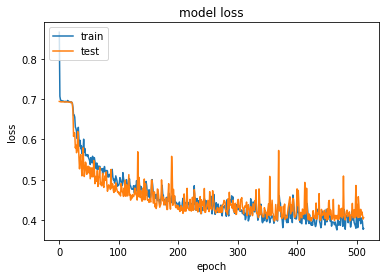

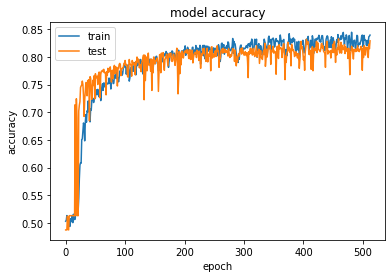

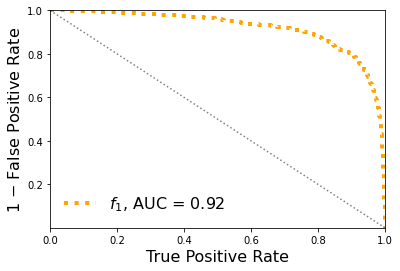

Classification score:


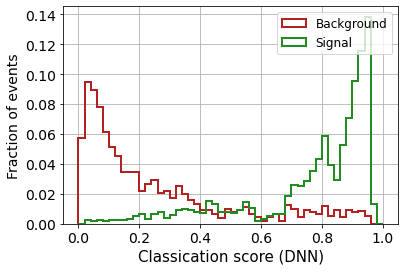


 ROC-AUC =  0.919294040521992


In [41]:

# define the keras model
model = Sequential()
model.add(Dense(128, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [42]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.919294040521992


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 256)               1440256   
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)               

50/50 [==============================] - 0s 6ms/step - loss: 0.4894 - accuracy: 0.7819 - val_loss: 0.4587 - val_accuracy: 0.7787
Epoch 96/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4750 - accuracy: 0.7879 - val_loss: 0.4656 - val_accuracy: 0.7778
Epoch 97/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4898 - accuracy: 0.7808 - val_loss: 0.4593 - val_accuracy: 0.7867
Epoch 98/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4884 - accuracy: 0.7764 - val_loss: 0.4630 - val_accuracy: 0.7849
Epoch 99/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4814 - accuracy: 0.7849 - val_loss: 0.5224 - val_accuracy: 0.7556
Epoch 100/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4825 - accuracy: 0.7825 - val_loss: 0.4538 - val_accuracy: 0.7884
Epoch 101/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4882 - accuracy: 0.7903 - val_loss: 0.4700 - val_accuracy: 0.7822
Epoch 102/1

50/50 [==============================] - 0s 6ms/step - loss: 0.4395 - accuracy: 0.8197 - val_loss: 0.4383 - val_accuracy: 0.7893
Epoch 153/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4704 - accuracy: 0.7901 - val_loss: 0.4470 - val_accuracy: 0.7947
Epoch 154/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4605 - accuracy: 0.8047 - val_loss: 0.4267 - val_accuracy: 0.8036
Epoch 155/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4525 - accuracy: 0.8107 - val_loss: 0.4400 - val_accuracy: 0.7920
Epoch 156/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4466 - accuracy: 0.8049 - val_loss: 0.4447 - val_accuracy: 0.8080
Epoch 157/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4390 - accuracy: 0.8142 - val_loss: 0.4796 - val_accuracy: 0.7796
Epoch 158/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4519 - accuracy: 0.8058 - val_loss: 0.4324 - val_accuracy: 0.8053
Epoch 1

Epoch 209/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4201 - accuracy: 0.8264 - val_loss: 0.4167 - val_accuracy: 0.8124
Epoch 210/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4165 - accuracy: 0.8326 - val_loss: 0.4842 - val_accuracy: 0.7947
Epoch 211/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4339 - accuracy: 0.8168 - val_loss: 0.4453 - val_accuracy: 0.8062
Epoch 212/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4375 - accuracy: 0.8231 - val_loss: 0.4484 - val_accuracy: 0.8000
Epoch 213/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4387 - accuracy: 0.8122 - val_loss: 0.4414 - val_accuracy: 0.7884
Epoch 214/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4288 - accuracy: 0.8171 - val_loss: 0.4345 - val_accuracy: 0.7964
Epoch 215/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4271 - accuracy: 0.8131 - val_loss: 0.4259 - val_accuracy:

Epoch 266/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4344 - accuracy: 0.8178 - val_loss: 0.4327 - val_accuracy: 0.8000
Epoch 267/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4195 - accuracy: 0.8156 - val_loss: 0.4279 - val_accuracy: 0.8107
Epoch 268/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4417 - accuracy: 0.8021 - val_loss: 0.4268 - val_accuracy: 0.7991
Epoch 269/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4672 - accuracy: 0.7991 - val_loss: 0.4201 - val_accuracy: 0.8124
Epoch 270/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3991 - accuracy: 0.8313 - val_loss: 0.4258 - val_accuracy: 0.8178
Epoch 271/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4137 - accuracy: 0.8205 - val_loss: 0.4299 - val_accuracy: 0.8080
Epoch 272/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4376 - accuracy: 0.8049 - val_loss: 0.4132 - val_accuracy:

Epoch 323/1500
50/50 [==============================] - 0s 7ms/step - loss: 0.3981 - accuracy: 0.8327 - val_loss: 0.4065 - val_accuracy: 0.8196
Epoch 324/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3983 - accuracy: 0.8280 - val_loss: 0.4285 - val_accuracy: 0.8178
Epoch 325/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4288 - accuracy: 0.8143 - val_loss: 0.4375 - val_accuracy: 0.7929
Epoch 326/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4356 - accuracy: 0.8004 - val_loss: 0.4360 - val_accuracy: 0.7938
Epoch 327/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4312 - accuracy: 0.8085 - val_loss: 0.4367 - val_accuracy: 0.8000
Epoch 328/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4176 - accuracy: 0.8131 - val_loss: 0.4239 - val_accuracy: 0.8027
Epoch 329/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4140 - accuracy: 0.8186 - val_loss: 0.4130 - val_accuracy:

Epoch 380/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4326 - accuracy: 0.8137 - val_loss: 0.4220 - val_accuracy: 0.8098
Epoch 381/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4338 - accuracy: 0.8074 - val_loss: 0.4143 - val_accuracy: 0.8213
Epoch 382/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3864 - accuracy: 0.8415 - val_loss: 0.4165 - val_accuracy: 0.8098
Epoch 383/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3928 - accuracy: 0.8299 - val_loss: 0.4430 - val_accuracy: 0.8009
Epoch 384/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4308 - accuracy: 0.8110 - val_loss: 0.4191 - val_accuracy: 0.8124
Epoch 385/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3990 - accuracy: 0.8301 - val_loss: 0.3980 - val_accuracy: 0.8222
Epoch 386/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4009 - accuracy: 0.8270 - val_loss: 0.4348 - val_accuracy:

Epoch 437/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4295 - accuracy: 0.8179 - val_loss: 0.4074 - val_accuracy: 0.8231
Epoch 438/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3887 - accuracy: 0.8379 - val_loss: 0.4074 - val_accuracy: 0.8276
Epoch 439/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3826 - accuracy: 0.8396 - val_loss: 0.4000 - val_accuracy: 0.8240
Epoch 440/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3864 - accuracy: 0.8402 - val_loss: 0.4382 - val_accuracy: 0.8027
Epoch 441/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3842 - accuracy: 0.8300 - val_loss: 0.4066 - val_accuracy: 0.8222
Epoch 442/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4037 - accuracy: 0.8244 - val_loss: 0.4617 - val_accuracy: 0.7982
Epoch 443/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4131 - accuracy: 0.8182 - val_loss: 0.4163 - val_accuracy:

Epoch 494/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4131 - accuracy: 0.8234 - val_loss: 0.3987 - val_accuracy: 0.8178
Epoch 495/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3710 - accuracy: 0.8458 - val_loss: 0.3989 - val_accuracy: 0.8284
Epoch 496/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3685 - accuracy: 0.8389 - val_loss: 0.3976 - val_accuracy: 0.8196
Epoch 497/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3786 - accuracy: 0.8416 - val_loss: 0.4226 - val_accuracy: 0.8044
Epoch 498/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3882 - accuracy: 0.8289 - val_loss: 0.3963 - val_accuracy: 0.8204
Epoch 499/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3697 - accuracy: 0.8496 - val_loss: 0.4012 - val_accuracy: 0.8187
Epoch 500/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3689 - accuracy: 0.8449 - val_loss: 0.4002 - val_accuracy:

Epoch 551/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3785 - accuracy: 0.8426 - val_loss: 0.4796 - val_accuracy: 0.7991
Epoch 552/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3832 - accuracy: 0.8425 - val_loss: 0.3985 - val_accuracy: 0.8240
Epoch 553/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3859 - accuracy: 0.8342 - val_loss: 0.4063 - val_accuracy: 0.8151
Epoch 554/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3949 - accuracy: 0.8295 - val_loss: 0.4112 - val_accuracy: 0.8293
Epoch 555/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3720 - accuracy: 0.8426 - val_loss: 0.4170 - val_accuracy: 0.8107
Epoch 556/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3826 - accuracy: 0.8373 - val_loss: 0.3943 - val_accuracy: 0.8249
Epoch 557/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3776 - accuracy: 0.8413 - val_loss: 0.4481 - val_accuracy:

Epoch 608/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3842 - accuracy: 0.8360 - val_loss: 0.4136 - val_accuracy: 0.8142
Epoch 609/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3746 - accuracy: 0.8350 - val_loss: 0.4008 - val_accuracy: 0.8213
Epoch 610/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3783 - accuracy: 0.8417 - val_loss: 0.4265 - val_accuracy: 0.8142
Epoch 611/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3741 - accuracy: 0.8402 - val_loss: 0.4117 - val_accuracy: 0.8053
Epoch 612/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3818 - accuracy: 0.8408 - val_loss: 0.3971 - val_accuracy: 0.8187
Epoch 613/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3785 - accuracy: 0.8431 - val_loss: 0.4389 - val_accuracy: 0.7938
Epoch 614/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3980 - accuracy: 0.8231 - val_loss: 0.4502 - val_accuracy:

Epoch 665/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3788 - accuracy: 0.8370 - val_loss: 0.4146 - val_accuracy: 0.8258
Epoch 666/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3652 - accuracy: 0.8550 - val_loss: 0.3986 - val_accuracy: 0.8187
Epoch 667/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3943 - accuracy: 0.8332 - val_loss: 0.4038 - val_accuracy: 0.8231
Epoch 668/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3802 - accuracy: 0.8431 - val_loss: 0.4059 - val_accuracy: 0.8053
Epoch 669/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3617 - accuracy: 0.8531 - val_loss: 0.3991 - val_accuracy: 0.8267
Epoch 670/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3886 - accuracy: 0.8338 - val_loss: 0.4019 - val_accuracy: 0.8276
Epoch 671/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3629 - accuracy: 0.8447 - val_loss: 0.4023 - val_accuracy:

Epoch 722/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3686 - accuracy: 0.8445 - val_loss: 0.3936 - val_accuracy: 0.8240
Epoch 723/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3603 - accuracy: 0.8421 - val_loss: 0.4055 - val_accuracy: 0.8231
Epoch 724/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3731 - accuracy: 0.8414 - val_loss: 0.4380 - val_accuracy: 0.8133
Epoch 725/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3655 - accuracy: 0.8507 - val_loss: 0.4208 - val_accuracy: 0.8080
Epoch 726/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3745 - accuracy: 0.8344 - val_loss: 0.4009 - val_accuracy: 0.8249
Epoch 727/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3595 - accuracy: 0.8436 - val_loss: 0.4259 - val_accuracy: 0.8044
Epoch 728/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3718 - accuracy: 0.8433 - val_loss: 0.4329 - val_accuracy:

Epoch 779/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3703 - accuracy: 0.8414 - val_loss: 0.4089 - val_accuracy: 0.8142
Epoch 780/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3620 - accuracy: 0.8494 - val_loss: 0.3986 - val_accuracy: 0.8249
Epoch 781/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3674 - accuracy: 0.8462 - val_loss: 0.3978 - val_accuracy: 0.8222
Epoch 782/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3951 - accuracy: 0.8244 - val_loss: 0.4028 - val_accuracy: 0.8240
Epoch 783/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3693 - accuracy: 0.8433 - val_loss: 0.4202 - val_accuracy: 0.8116
Epoch 784/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3758 - accuracy: 0.8461 - val_loss: 0.4255 - val_accuracy: 0.8062
Epoch 785/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3686 - accuracy: 0.8469 - val_loss: 0.3955 - val_accuracy:

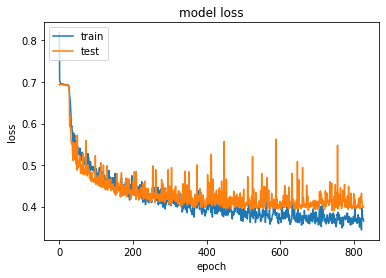

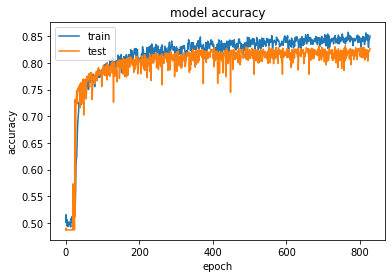

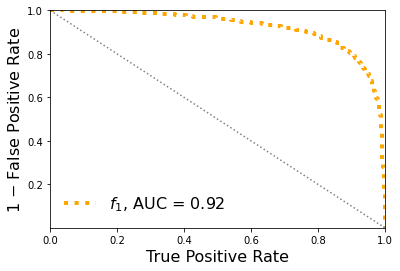

Classification score:


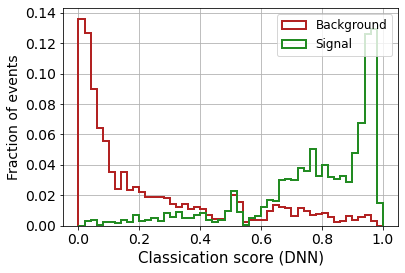


 ROC-AUC =  0.9238343269211071


In [43]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [44]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9238343269211071


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 64)                360064    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 4)               

50/50 [==============================] - 0s 2ms/step - loss: 0.4975 - accuracy: 0.7723 - val_loss: 0.4752 - val_accuracy: 0.7724
Epoch 104/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4916 - accuracy: 0.7786 - val_loss: 0.4771 - val_accuracy: 0.7813
Epoch 105/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5155 - accuracy: 0.7615 - val_loss: 0.5274 - val_accuracy: 0.7653
Epoch 106/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5145 - accuracy: 0.7778 - val_loss: 0.4926 - val_accuracy: 0.7831
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7792 - val_loss: 0.4749 - val_accuracy: 0.7804
Epoch 108/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4950 - accuracy: 0.7797 - val_loss: 0.4669 - val_accuracy: 0.7893
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.7757 - val_loss: 0.4792 - val_accuracy: 0.7813
Epoch 1

Epoch 160/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4843 - accuracy: 0.7847 - val_loss: 0.4516 - val_accuracy: 0.7991
Epoch 161/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.7857 - val_loss: 0.4520 - val_accuracy: 0.8000
Epoch 162/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5069 - accuracy: 0.7711 - val_loss: 0.4744 - val_accuracy: 0.7787
Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4755 - accuracy: 0.7858 - val_loss: 0.4493 - val_accuracy: 0.7991
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7878 - val_loss: 0.4721 - val_accuracy: 0.7716
Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.7815 - val_loss: 0.4524 - val_accuracy: 0.7929
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.7881 - val_loss: 0.4578 - val_accuracy:

Epoch 217/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.7999 - val_loss: 0.4340 - val_accuracy: 0.8071
Epoch 218/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.8175 - val_loss: 0.4294 - val_accuracy: 0.8044
Epoch 219/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4528 - accuracy: 0.7964 - val_loss: 0.4299 - val_accuracy: 0.8098
Epoch 220/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.8194 - val_loss: 0.4471 - val_accuracy: 0.7982
Epoch 221/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7985 - val_loss: 0.4386 - val_accuracy: 0.7947
Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.8131 - val_loss: 0.4413 - val_accuracy: 0.8089
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.8159 - val_loss: 0.4540 - val_accuracy:

Epoch 274/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4181 - accuracy: 0.8228 - val_loss: 0.4147 - val_accuracy: 0.8089
Epoch 275/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.8177 - val_loss: 0.4273 - val_accuracy: 0.8027
Epoch 276/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.7974 - val_loss: 0.4425 - val_accuracy: 0.7947
Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4524 - accuracy: 0.8051 - val_loss: 0.4121 - val_accuracy: 0.8098
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.8148 - val_loss: 0.4579 - val_accuracy: 0.7920
Epoch 279/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4460 - accuracy: 0.8168 - val_loss: 0.4151 - val_accuracy: 0.8133
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.8075 - val_loss: 0.4190 - val_accuracy:

Epoch 331/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8276 - val_loss: 0.4174 - val_accuracy: 0.8160
Epoch 332/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4096 - accuracy: 0.8332 - val_loss: 0.4291 - val_accuracy: 0.8142
Epoch 333/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4242 - accuracy: 0.8187 - val_loss: 0.4109 - val_accuracy: 0.8142
Epoch 334/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4062 - accuracy: 0.8270 - val_loss: 0.4039 - val_accuracy: 0.8080
Epoch 335/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.8174 - val_loss: 0.4095 - val_accuracy: 0.8133
Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4108 - accuracy: 0.8224 - val_loss: 0.4905 - val_accuracy: 0.7724
Epoch 337/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.8069 - val_loss: 0.4234 - val_accuracy:

Epoch 388/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8301 - val_loss: 0.4025 - val_accuracy: 0.8204
Epoch 389/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4122 - accuracy: 0.8330 - val_loss: 0.4021 - val_accuracy: 0.8169
Epoch 390/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4022 - accuracy: 0.8304 - val_loss: 0.4086 - val_accuracy: 0.8098
Epoch 391/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8297 - val_loss: 0.4077 - val_accuracy: 0.8116
Epoch 392/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4024 - accuracy: 0.8335 - val_loss: 0.4130 - val_accuracy: 0.8169
Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8253 - val_loss: 0.4242 - val_accuracy: 0.8107
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.8187 - val_loss: 0.4030 - val_accuracy:

Epoch 445/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3974 - accuracy: 0.8291 - val_loss: 0.4003 - val_accuracy: 0.8160
Epoch 446/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8264 - val_loss: 0.4539 - val_accuracy: 0.8027
Epoch 447/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.8112 - val_loss: 0.4132 - val_accuracy: 0.8213
Epoch 448/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4065 - accuracy: 0.8264 - val_loss: 0.4120 - val_accuracy: 0.8187
Epoch 449/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.8167 - val_loss: 0.4213 - val_accuracy: 0.8044
Epoch 450/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.8178 - val_loss: 0.4113 - val_accuracy: 0.8151
Epoch 451/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4143 - accuracy: 0.8171 - val_loss: 0.3981 - val_accuracy:

Epoch 502/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.8026 - val_loss: 0.4146 - val_accuracy: 0.8080
Epoch 503/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.8174 - val_loss: 0.4094 - val_accuracy: 0.8187
Epoch 504/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.8242 - val_loss: 0.4013 - val_accuracy: 0.8142
Epoch 505/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3965 - accuracy: 0.8316 - val_loss: 0.3989 - val_accuracy: 0.8178
Epoch 506/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8345 - val_loss: 0.4394 - val_accuracy: 0.7876
Epoch 507/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4066 - accuracy: 0.8259 - val_loss: 0.4131 - val_accuracy: 0.8071
Epoch 508/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3876 - accuracy: 0.8415 - val_loss: 0.3954 - val_accuracy:

Epoch 559/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3855 - accuracy: 0.8380 - val_loss: 0.4033 - val_accuracy: 0.8178
Epoch 560/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3967 - accuracy: 0.8343 - val_loss: 0.4123 - val_accuracy: 0.8133
Epoch 561/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.8269 - val_loss: 0.4118 - val_accuracy: 0.8142
Epoch 562/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3945 - accuracy: 0.8415 - val_loss: 0.4121 - val_accuracy: 0.8187
Epoch 563/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.8459 - val_loss: 0.4512 - val_accuracy: 0.8044
Epoch 564/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.8330 - val_loss: 0.3956 - val_accuracy: 0.8178
Epoch 565/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4040 - accuracy: 0.8290 - val_loss: 0.4687 - val_accuracy:

Epoch 616/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4031 - accuracy: 0.8355 - val_loss: 0.4112 - val_accuracy: 0.8204
Epoch 617/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8379 - val_loss: 0.4191 - val_accuracy: 0.8053
Epoch 618/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3802 - accuracy: 0.8394 - val_loss: 0.4050 - val_accuracy: 0.8240
Epoch 619/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8381 - val_loss: 0.4074 - val_accuracy: 0.8062
Epoch 620/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.8234 - val_loss: 0.3974 - val_accuracy: 0.8151
Epoch 621/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4049 - accuracy: 0.8227 - val_loss: 0.4103 - val_accuracy: 0.8187
Epoch 622/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8390 - val_loss: 0.4148 - val_accuracy:

Epoch 673/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.8344 - val_loss: 0.4115 - val_accuracy: 0.8187
Epoch 674/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3891 - accuracy: 0.8442 - val_loss: 0.3974 - val_accuracy: 0.8240
Epoch 675/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3803 - accuracy: 0.8428 - val_loss: 0.4012 - val_accuracy: 0.8222
Epoch 676/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3875 - accuracy: 0.8427 - val_loss: 0.3957 - val_accuracy: 0.8222
Epoch 677/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.8414 - val_loss: 0.4031 - val_accuracy: 0.8204
Epoch 678/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8472 - val_loss: 0.4096 - val_accuracy: 0.8089
Epoch 679/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8371 - val_loss: 0.4173 - val_accuracy:

Epoch 730/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3787 - accuracy: 0.8387 - val_loss: 0.4082 - val_accuracy: 0.8196
Epoch 731/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3854 - accuracy: 0.8266 - val_loss: 0.3981 - val_accuracy: 0.8142
Epoch 732/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.8357 - val_loss: 0.4091 - val_accuracy: 0.8169
Epoch 733/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3734 - accuracy: 0.8414 - val_loss: 0.4168 - val_accuracy: 0.8231
Epoch 734/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8451 - val_loss: 0.3992 - val_accuracy: 0.8107
Epoch 735/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3862 - accuracy: 0.8370 - val_loss: 0.4288 - val_accuracy: 0.8142
Epoch 736/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3763 - accuracy: 0.8357 - val_loss: 0.4058 - val_accuracy:

Epoch 787/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3861 - accuracy: 0.8338 - val_loss: 0.4894 - val_accuracy: 0.8062
Epoch 788/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3808 - accuracy: 0.8312 - val_loss: 0.4183 - val_accuracy: 0.8133
Epoch 789/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3764 - accuracy: 0.8498 - val_loss: 0.4056 - val_accuracy: 0.8213
Epoch 790/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3544 - accuracy: 0.8478 - val_loss: 0.4107 - val_accuracy: 0.8196
Epoch 791/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8542 - val_loss: 0.4089 - val_accuracy: 0.8204
Epoch 792/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.8549 - val_loss: 0.4171 - val_accuracy: 0.8107
Epoch 793/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4035 - accuracy: 0.8278 - val_loss: 0.4084 - val_accuracy:

Epoch 844/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3728 - accuracy: 0.8392 - val_loss: 0.4035 - val_accuracy: 0.8116
Epoch 845/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3821 - accuracy: 0.8308 - val_loss: 0.4121 - val_accuracy: 0.8107
Epoch 846/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3591 - accuracy: 0.8519 - val_loss: 0.4803 - val_accuracy: 0.7893
Epoch 847/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8067 - val_loss: 0.4274 - val_accuracy: 0.8036
Epoch 848/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3961 - accuracy: 0.8262 - val_loss: 0.4153 - val_accuracy: 0.8187
Epoch 849/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3791 - accuracy: 0.8408 - val_loss: 0.4063 - val_accuracy: 0.8213
Epoch 850/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3635 - accuracy: 0.8434 - val_loss: 0.4028 - val_accuracy:

Epoch 901/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3889 - accuracy: 0.8340 - val_loss: 0.4166 - val_accuracy: 0.8027
Epoch 902/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3978 - accuracy: 0.8284 - val_loss: 0.4404 - val_accuracy: 0.8222
Epoch 903/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8425 - val_loss: 0.4012 - val_accuracy: 0.8231
Epoch 904/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3850 - accuracy: 0.8455 - val_loss: 0.4677 - val_accuracy: 0.8222
Epoch 905/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3955 - accuracy: 0.8346 - val_loss: 0.4185 - val_accuracy: 0.8089
Epoch 906/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3835 - accuracy: 0.8398 - val_loss: 0.4141 - val_accuracy: 0.8098
Epoch 907/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3667 - accuracy: 0.8394 - val_loss: 0.4170 - val_accuracy:

Epoch 958/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8477 - val_loss: 0.4058 - val_accuracy: 0.8213
Epoch 959/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3522 - accuracy: 0.8504 - val_loss: 0.3925 - val_accuracy: 0.8213
Epoch 960/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3650 - accuracy: 0.8412 - val_loss: 0.4249 - val_accuracy: 0.8187
Epoch 961/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.8430 - val_loss: 0.4022 - val_accuracy: 0.8222
Epoch 962/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3743 - accuracy: 0.8448 - val_loss: 0.4244 - val_accuracy: 0.8053
Epoch 963/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8409 - val_loss: 0.4014 - val_accuracy: 0.8311
Epoch 964/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3602 - accuracy: 0.8462 - val_loss: 0.4050 - val_accuracy:

Epoch 1015/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3566 - accuracy: 0.8428 - val_loss: 0.3996 - val_accuracy: 0.8213
Epoch 1016/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3622 - accuracy: 0.8426 - val_loss: 0.4164 - val_accuracy: 0.7956
Epoch 1017/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8426 - val_loss: 0.4006 - val_accuracy: 0.8258
Epoch 1018/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.8547 - val_loss: 0.4265 - val_accuracy: 0.8116
Epoch 1019/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3786 - accuracy: 0.8381 - val_loss: 0.4103 - val_accuracy: 0.8213
Epoch 1020/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3631 - accuracy: 0.8424 - val_loss: 0.4010 - val_accuracy: 0.8284
Epoch 1021/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.3607 - accuracy: 0.8457 - val_loss: 0.4032 - val_ac

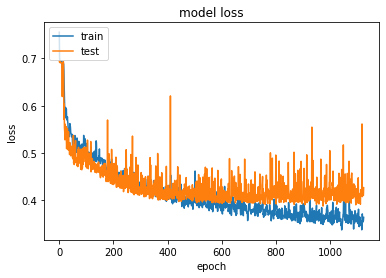

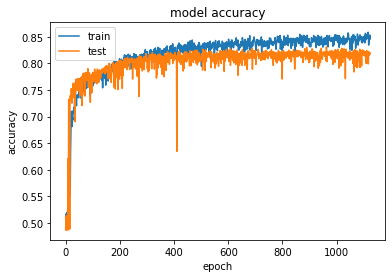

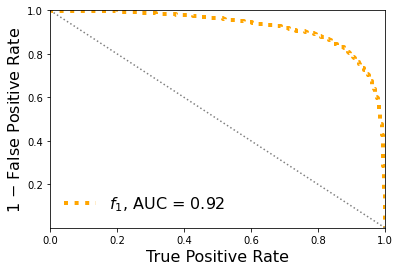

Classification score:


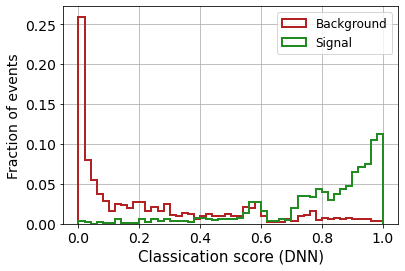


 ROC-AUC =  0.9234745354721078


In [137]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [138]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9234745354721078


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               720128    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1

Epoch 44/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5657 - accuracy: 0.7159 - val_loss: 0.5143 - val_accuracy: 0.7609
Epoch 45/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5428 - accuracy: 0.7390 - val_loss: 0.5037 - val_accuracy: 0.7644
Epoch 46/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5631 - accuracy: 0.7209 - val_loss: 0.5150 - val_accuracy: 0.7609
Epoch 47/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5683 - accuracy: 0.7117 - val_loss: 0.4995 - val_accuracy: 0.7627
Epoch 48/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5337 - accuracy: 0.7441 - val_loss: 0.5096 - val_accuracy: 0.7458
Epoch 49/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5241 - accuracy: 0.7529 - val_loss: 0.5084 - val_accuracy: 0.7387
Epoch 50/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5238 - accuracy: 0.7587 - val_loss: 0.5135 - val_accuracy: 0.7422

Epoch 158/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4883 - accuracy: 0.7712 - val_loss: 0.4769 - val_accuracy: 0.7876
Epoch 159/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4975 - accuracy: 0.7668 - val_loss: 0.4798 - val_accuracy: 0.7822
Epoch 160/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.5001 - accuracy: 0.7766 - val_loss: 0.4632 - val_accuracy: 0.7876
Epoch 161/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4911 - accuracy: 0.7732 - val_loss: 0.6051 - val_accuracy: 0.7476
Epoch 162/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.5156 - accuracy: 0.7634 - val_loss: 0.4659 - val_accuracy: 0.7893
Epoch 163/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4889 - accuracy: 0.7766 - val_loss: 0.4605 - val_accuracy: 0.7893
Epoch 164/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4716 - accuracy: 0.7932 - val_loss: 0.4621 - val_accuracy:

Epoch 215/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4727 - accuracy: 0.7828 - val_loss: 0.4581 - val_accuracy: 0.7973
Epoch 216/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4661 - accuracy: 0.7904 - val_loss: 0.4592 - val_accuracy: 0.7920
Epoch 217/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4605 - accuracy: 0.8001 - val_loss: 0.4411 - val_accuracy: 0.8000
Epoch 218/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4552 - accuracy: 0.7964 - val_loss: 0.4531 - val_accuracy: 0.7956
Epoch 219/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.7958 - val_loss: 0.4507 - val_accuracy: 0.7867
Epoch 220/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.7984 - val_loss: 0.4527 - val_accuracy: 0.7893
Epoch 221/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4751 - accuracy: 0.7824 - val_loss: 0.4503 - val_accuracy:

Epoch 272/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4544 - accuracy: 0.8064 - val_loss: 0.4327 - val_accuracy: 0.8018
Epoch 273/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4400 - accuracy: 0.7993 - val_loss: 0.4275 - val_accuracy: 0.8071
Epoch 274/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4416 - accuracy: 0.8041 - val_loss: 0.4245 - val_accuracy: 0.8098
Epoch 275/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4229 - accuracy: 0.8191 - val_loss: 0.4661 - val_accuracy: 0.7644
Epoch 276/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4646 - accuracy: 0.7961 - val_loss: 0.4420 - val_accuracy: 0.7982
Epoch 277/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4635 - accuracy: 0.7983 - val_loss: 0.4437 - val_accuracy: 0.7973
Epoch 278/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4589 - accuracy: 0.7977 - val_loss: 0.4301 - val_accuracy:

Epoch 329/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4450 - accuracy: 0.8036 - val_loss: 0.4225 - val_accuracy: 0.7982
Epoch 330/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4270 - accuracy: 0.8158 - val_loss: 0.4147 - val_accuracy: 0.8116
Epoch 331/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4219 - accuracy: 0.8196 - val_loss: 0.4263 - val_accuracy: 0.8062
Epoch 332/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4228 - accuracy: 0.8128 - val_loss: 0.4506 - val_accuracy: 0.7929
Epoch 333/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4320 - accuracy: 0.8179 - val_loss: 0.4128 - val_accuracy: 0.8196
Epoch 334/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3882 - accuracy: 0.8322 - val_loss: 0.4086 - val_accuracy: 0.8089
Epoch 335/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.8161 - val_loss: 0.4681 - val_accuracy:

Epoch 386/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4058 - accuracy: 0.8289 - val_loss: 0.4989 - val_accuracy: 0.7893
Epoch 387/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4310 - accuracy: 0.8117 - val_loss: 0.4557 - val_accuracy: 0.8196
Epoch 388/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4070 - accuracy: 0.8232 - val_loss: 0.4234 - val_accuracy: 0.8018
Epoch 389/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4007 - accuracy: 0.8309 - val_loss: 0.4208 - val_accuracy: 0.8036
Epoch 390/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3991 - accuracy: 0.8303 - val_loss: 0.4130 - val_accuracy: 0.8089
Epoch 391/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4110 - accuracy: 0.8217 - val_loss: 0.4283 - val_accuracy: 0.7991
Epoch 392/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4281 - accuracy: 0.8147 - val_loss: 0.4718 - val_accuracy:

Epoch 443/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4210 - accuracy: 0.8126 - val_loss: 0.4129 - val_accuracy: 0.8160
Epoch 444/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4028 - accuracy: 0.8338 - val_loss: 0.4060 - val_accuracy: 0.8107
Epoch 445/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4102 - accuracy: 0.8254 - val_loss: 0.4067 - val_accuracy: 0.8160
Epoch 446/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4142 - accuracy: 0.8265 - val_loss: 0.4047 - val_accuracy: 0.8142
Epoch 447/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4063 - accuracy: 0.8254 - val_loss: 0.4077 - val_accuracy: 0.8187
Epoch 448/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3976 - accuracy: 0.8348 - val_loss: 0.4282 - val_accuracy: 0.8071
Epoch 449/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.8314 - val_loss: 0.4058 - val_accuracy:

Epoch 500/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4010 - accuracy: 0.8299 - val_loss: 0.4083 - val_accuracy: 0.8089
Epoch 501/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3839 - accuracy: 0.8408 - val_loss: 0.4442 - val_accuracy: 0.7956
Epoch 502/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.4272 - accuracy: 0.8226 - val_loss: 0.4030 - val_accuracy: 0.8124
Epoch 503/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3941 - accuracy: 0.8394 - val_loss: 0.4021 - val_accuracy: 0.8160
Epoch 504/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4289 - accuracy: 0.8081 - val_loss: 0.4054 - val_accuracy: 0.8196
Epoch 505/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3738 - accuracy: 0.8445 - val_loss: 0.4003 - val_accuracy: 0.8160
Epoch 506/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3931 - accuracy: 0.8332 - val_loss: 0.4645 - val_accuracy:

Epoch 557/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3867 - accuracy: 0.8327 - val_loss: 0.4548 - val_accuracy: 0.8160
Epoch 558/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4509 - accuracy: 0.7993 - val_loss: 0.4011 - val_accuracy: 0.8196
Epoch 559/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3984 - accuracy: 0.8299 - val_loss: 0.4209 - val_accuracy: 0.8187
Epoch 560/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3827 - accuracy: 0.8405 - val_loss: 0.4349 - val_accuracy: 0.8027
Epoch 561/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.4048 - accuracy: 0.8228 - val_loss: 0.4107 - val_accuracy: 0.8124
Epoch 562/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3845 - accuracy: 0.8386 - val_loss: 0.4286 - val_accuracy: 0.8036
Epoch 563/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3785 - accuracy: 0.8364 - val_loss: 0.4467 - val_accuracy:

Epoch 614/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3715 - accuracy: 0.8430 - val_loss: 0.4015 - val_accuracy: 0.8187
Epoch 615/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3982 - accuracy: 0.8306 - val_loss: 0.4051 - val_accuracy: 0.8231
Epoch 616/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3720 - accuracy: 0.8479 - val_loss: 0.4137 - val_accuracy: 0.8231
Epoch 617/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3915 - accuracy: 0.8338 - val_loss: 0.4217 - val_accuracy: 0.8240
Epoch 618/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3782 - accuracy: 0.8433 - val_loss: 0.4026 - val_accuracy: 0.8178
Epoch 619/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3833 - accuracy: 0.8292 - val_loss: 0.4439 - val_accuracy: 0.8089
Epoch 620/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3889 - accuracy: 0.8312 - val_loss: 0.3991 - val_accuracy:

Epoch 671/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3821 - accuracy: 0.8415 - val_loss: 0.3956 - val_accuracy: 0.8276
Epoch 672/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3675 - accuracy: 0.8430 - val_loss: 0.3931 - val_accuracy: 0.8231
Epoch 673/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3624 - accuracy: 0.8486 - val_loss: 0.3935 - val_accuracy: 0.8276
Epoch 674/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3663 - accuracy: 0.8462 - val_loss: 0.4037 - val_accuracy: 0.8080
Epoch 675/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3830 - accuracy: 0.8396 - val_loss: 0.3976 - val_accuracy: 0.8116
Epoch 676/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3789 - accuracy: 0.8360 - val_loss: 0.4122 - val_accuracy: 0.8071
Epoch 677/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3871 - accuracy: 0.8320 - val_loss: 0.4266 - val_accuracy:

Epoch 728/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3773 - accuracy: 0.8418 - val_loss: 0.4345 - val_accuracy: 0.8187
Epoch 729/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3645 - accuracy: 0.8474 - val_loss: 0.3991 - val_accuracy: 0.8231
Epoch 730/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.8526 - val_loss: 0.3995 - val_accuracy: 0.8204
Epoch 731/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.3795 - accuracy: 0.8385 - val_loss: 0.4017 - val_accuracy: 0.8089
Epoch 732/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3894 - accuracy: 0.8398 - val_loss: 0.4039 - val_accuracy: 0.8133
Epoch 733/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3781 - accuracy: 0.8385 - val_loss: 0.4077 - val_accuracy: 0.8160
Epoch 734/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.3887 - accuracy: 0.8358 - val_loss: 0.4340 - val_accuracy:

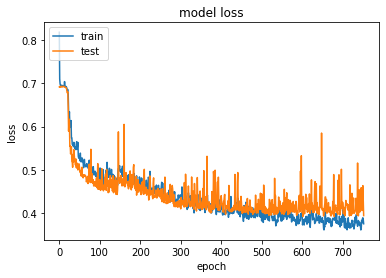

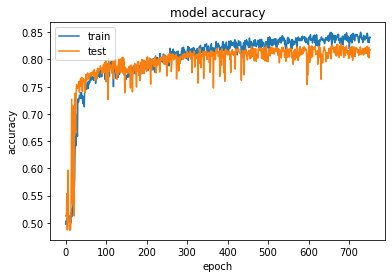

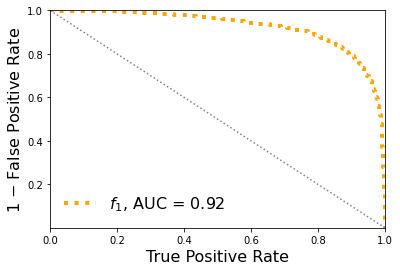

Classification score:


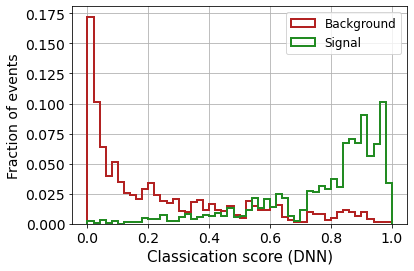


 ROC-AUC =  0.9228970765984472


In [33]:

# define the keras model
model = Sequential()
model.add(Dense(128, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [34]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9228970765984472


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               1440256   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

50/50 [==============================] - 0s 6ms/step - loss: 0.5275 - accuracy: 0.7569 - val_loss: 0.4952 - val_accuracy: 0.7573
Epoch 42/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.5321 - accuracy: 0.7492 - val_loss: 0.4881 - val_accuracy: 0.7751
Epoch 43/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.5144 - accuracy: 0.7563 - val_loss: 0.5086 - val_accuracy: 0.7671
Epoch 44/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.5265 - accuracy: 0.7554 - val_loss: 0.5023 - val_accuracy: 0.7609
Epoch 45/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.5186 - accuracy: 0.7564 - val_loss: 0.4904 - val_accuracy: 0.7680
Epoch 46/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.5181 - accuracy: 0.7582 - val_loss: 0.4960 - val_accuracy: 0.7644
Epoch 47/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.5104 - accuracy: 0.7620 - val_loss: 0.5032 - val_accuracy: 0.7707
Epoch 48/1500

50/50 [==============================] - 0s 6ms/step - loss: 0.4598 - accuracy: 0.7967 - val_loss: 0.5082 - val_accuracy: 0.7502
Epoch 156/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4948 - accuracy: 0.7700 - val_loss: 0.4563 - val_accuracy: 0.7884
Epoch 157/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4716 - accuracy: 0.7882 - val_loss: 0.4496 - val_accuracy: 0.8000
Epoch 158/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4647 - accuracy: 0.7912 - val_loss: 0.4493 - val_accuracy: 0.8044
Epoch 159/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4634 - accuracy: 0.7941 - val_loss: 0.4803 - val_accuracy: 0.7938
Epoch 160/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4953 - accuracy: 0.7738 - val_loss: 0.4645 - val_accuracy: 0.7796
Epoch 161/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4778 - accuracy: 0.7907 - val_loss: 0.4466 - val_accuracy: 0.7964
Epoch 1

Epoch 212/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4304 - accuracy: 0.8149 - val_loss: 0.4131 - val_accuracy: 0.8089
Epoch 213/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4383 - accuracy: 0.8052 - val_loss: 0.4223 - val_accuracy: 0.8036
Epoch 214/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4306 - accuracy: 0.8180 - val_loss: 0.4434 - val_accuracy: 0.7831
Epoch 215/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4174 - accuracy: 0.8146 - val_loss: 0.4228 - val_accuracy: 0.8080
Epoch 216/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4383 - accuracy: 0.8148 - val_loss: 0.5399 - val_accuracy: 0.7733
Epoch 217/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4659 - accuracy: 0.7941 - val_loss: 0.4246 - val_accuracy: 0.8107
Epoch 218/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4146 - accuracy: 0.8201 - val_loss: 0.4516 - val_accuracy:

Epoch 269/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4010 - accuracy: 0.8359 - val_loss: 0.4036 - val_accuracy: 0.8196
Epoch 270/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4031 - accuracy: 0.8315 - val_loss: 0.4154 - val_accuracy: 0.8196
Epoch 271/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3996 - accuracy: 0.8382 - val_loss: 0.4129 - val_accuracy: 0.8107
Epoch 272/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4224 - accuracy: 0.8120 - val_loss: 0.4735 - val_accuracy: 0.7884
Epoch 273/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4388 - accuracy: 0.8159 - val_loss: 0.4310 - val_accuracy: 0.8000
Epoch 274/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4098 - accuracy: 0.8188 - val_loss: 0.5024 - val_accuracy: 0.7769
Epoch 275/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4120 - accuracy: 0.8251 - val_loss: 0.4199 - val_accuracy:

Epoch 326/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4064 - accuracy: 0.8300 - val_loss: 0.4028 - val_accuracy: 0.8098
Epoch 327/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4259 - accuracy: 0.8159 - val_loss: 0.3945 - val_accuracy: 0.8160
Epoch 328/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3926 - accuracy: 0.8369 - val_loss: 0.3977 - val_accuracy: 0.8187
Epoch 329/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4051 - accuracy: 0.8327 - val_loss: 0.4104 - val_accuracy: 0.8124
Epoch 330/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3984 - accuracy: 0.8328 - val_loss: 0.4125 - val_accuracy: 0.8098
Epoch 331/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4081 - accuracy: 0.8288 - val_loss: 0.4061 - val_accuracy: 0.8160
Epoch 332/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4126 - accuracy: 0.8174 - val_loss: 0.4309 - val_accuracy:

Epoch 383/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4050 - accuracy: 0.8238 - val_loss: 0.3941 - val_accuracy: 0.8196
Epoch 384/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3924 - accuracy: 0.8345 - val_loss: 0.4051 - val_accuracy: 0.8071
Epoch 385/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3792 - accuracy: 0.8395 - val_loss: 0.3938 - val_accuracy: 0.8142
Epoch 386/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3916 - accuracy: 0.8268 - val_loss: 0.3962 - val_accuracy: 0.8116
Epoch 387/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3759 - accuracy: 0.8414 - val_loss: 0.4126 - val_accuracy: 0.8222
Epoch 388/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3857 - accuracy: 0.8346 - val_loss: 0.4064 - val_accuracy: 0.8089
Epoch 389/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3985 - accuracy: 0.8339 - val_loss: 0.4061 - val_accuracy:

Epoch 440/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3800 - accuracy: 0.8435 - val_loss: 0.4221 - val_accuracy: 0.8187
Epoch 441/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3630 - accuracy: 0.8530 - val_loss: 0.4010 - val_accuracy: 0.8222
Epoch 442/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3794 - accuracy: 0.8327 - val_loss: 0.4728 - val_accuracy: 0.7956
Epoch 443/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3920 - accuracy: 0.8325 - val_loss: 0.4053 - val_accuracy: 0.8009
Epoch 444/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3766 - accuracy: 0.8432 - val_loss: 0.3944 - val_accuracy: 0.8258
Epoch 445/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3985 - accuracy: 0.8244 - val_loss: 0.4068 - val_accuracy: 0.8116
Epoch 446/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3901 - accuracy: 0.8357 - val_loss: 0.4050 - val_accuracy:

Epoch 497/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3854 - accuracy: 0.8419 - val_loss: 0.3963 - val_accuracy: 0.8302
Epoch 498/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3655 - accuracy: 0.8473 - val_loss: 0.4001 - val_accuracy: 0.8204
Epoch 499/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3962 - accuracy: 0.8341 - val_loss: 0.4242 - val_accuracy: 0.8098
Epoch 500/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3852 - accuracy: 0.8340 - val_loss: 0.4710 - val_accuracy: 0.7751
Epoch 501/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3901 - accuracy: 0.8380 - val_loss: 0.3910 - val_accuracy: 0.8116
Epoch 502/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3700 - accuracy: 0.8468 - val_loss: 0.4112 - val_accuracy: 0.8231
Epoch 503/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3940 - accuracy: 0.8362 - val_loss: 0.4067 - val_accuracy:

Epoch 554/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3911 - accuracy: 0.8339 - val_loss: 0.4029 - val_accuracy: 0.8160
Epoch 555/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3740 - accuracy: 0.8479 - val_loss: 0.4579 - val_accuracy: 0.8187
Epoch 556/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3859 - accuracy: 0.8423 - val_loss: 0.3940 - val_accuracy: 0.8249
Epoch 557/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3693 - accuracy: 0.8458 - val_loss: 0.3938 - val_accuracy: 0.8142
Epoch 558/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3861 - accuracy: 0.8302 - val_loss: 0.3914 - val_accuracy: 0.8231
Epoch 559/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3843 - accuracy: 0.8365 - val_loss: 0.4312 - val_accuracy: 0.8124
Epoch 560/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3738 - accuracy: 0.8486 - val_loss: 0.4066 - val_accuracy:

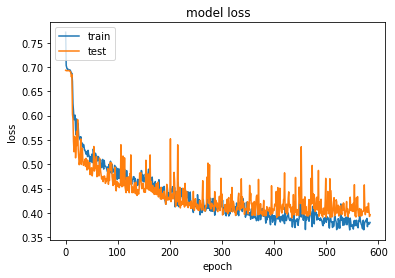

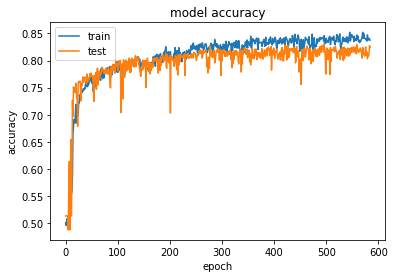

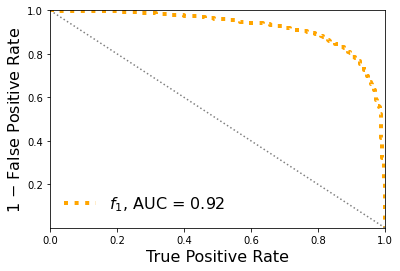

Classification score:


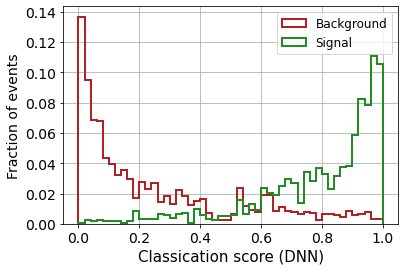


 ROC-AUC =  0.9231339499723434


In [35]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [36]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9231339499723434


##### Activation ReLU

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 16)                90016     
_________________________________________________________________
dropout_69 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_70 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 5         
Total params: 90,089
Trainable params: 90,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
50/50 [==============================] - 1s 5ms/step - loss: 0.7132 - accuracy: 0.4986 - val_loss: 0.6

50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 110/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 111/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 112/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 113/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4903 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 114/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 1

Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 167/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 168/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 169/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 170/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 171/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6931 - val_accuracy:

Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 224/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 225/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 226/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4855 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 227/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 228/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy:

Epoch 279/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5124 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 281/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 282/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4892 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 283/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 284/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 285/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy:

Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 337/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 338/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 339/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 340/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 341/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 342/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy:

Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4886 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 395/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 396/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 397/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 398/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 399/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy:

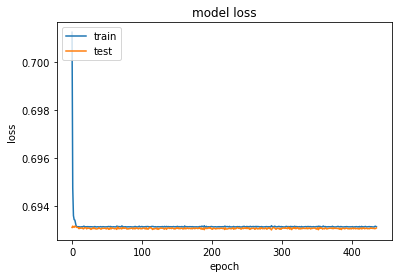

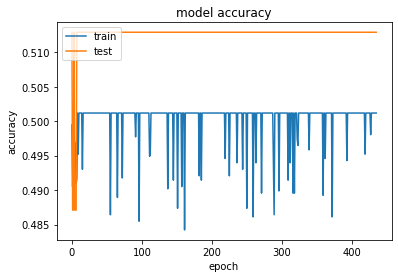

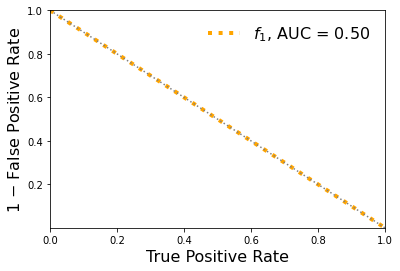

Classification score:


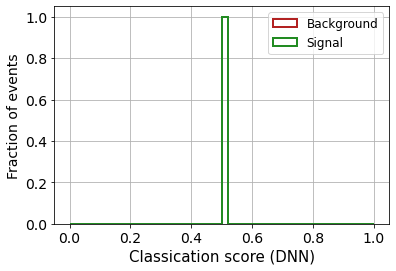


 ROC-AUC =  0.5


In [67]:

# define the keras model
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X_mon_train_1D.shape[1],)))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [68]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.5


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 32)                180032    
_________________________________________________________________
dropout_51 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_52 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_53 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)               

50/50 [==============================] - 0s 2ms/step - loss: 0.5809 - accuracy: 0.7171 - val_loss: 0.4895 - val_accuracy: 0.8000
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.7261 - val_loss: 0.4893 - val_accuracy: 0.8071
Epoch 108/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5482 - accuracy: 0.7445 - val_loss: 0.4846 - val_accuracy: 0.8036
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5540 - accuracy: 0.7418 - val_loss: 0.4908 - val_accuracy: 0.8027
Epoch 110/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5382 - accuracy: 0.7493 - val_loss: 0.4779 - val_accuracy: 0.8036
Epoch 111/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5555 - accuracy: 0.7343 - val_loss: 0.5009 - val_accuracy: 0.8044
Epoch 112/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5546 - accuracy: 0.7326 - val_loss: 0.4877 - val_accuracy: 0.7920
Epoch 1

Epoch 163/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5372 - accuracy: 0.7535 - val_loss: 0.4720 - val_accuracy: 0.8124
Epoch 164/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5457 - accuracy: 0.7518 - val_loss: 0.5203 - val_accuracy: 0.7867
Epoch 165/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5506 - accuracy: 0.7482 - val_loss: 0.4781 - val_accuracy: 0.8116
Epoch 166/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5441 - accuracy: 0.7438 - val_loss: 0.4731 - val_accuracy: 0.8018
Epoch 167/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.7402 - val_loss: 0.4936 - val_accuracy: 0.8053
Epoch 168/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5385 - accuracy: 0.7502 - val_loss: 0.4799 - val_accuracy: 0.8178
Epoch 169/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5418 - accuracy: 0.7477 - val_loss: 0.4729 - val_accuracy:

Epoch 220/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5463 - accuracy: 0.7531 - val_loss: 0.5757 - val_accuracy: 0.7244
Epoch 221/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5653 - accuracy: 0.7278 - val_loss: 0.4783 - val_accuracy: 0.8151
Epoch 222/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5255 - accuracy: 0.7634 - val_loss: 0.5492 - val_accuracy: 0.7493
Epoch 223/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5522 - accuracy: 0.7474 - val_loss: 0.4747 - val_accuracy: 0.8222
Epoch 224/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.7529 - val_loss: 0.4685 - val_accuracy: 0.8124
Epoch 225/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5429 - accuracy: 0.7527 - val_loss: 0.4676 - val_accuracy: 0.8142
Epoch 226/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5576 - accuracy: 0.7399 - val_loss: 0.4725 - val_accuracy:

Epoch 277/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5390 - accuracy: 0.7526 - val_loss: 0.4815 - val_accuracy: 0.8062
Epoch 278/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5469 - accuracy: 0.7484 - val_loss: 0.4758 - val_accuracy: 0.8151
Epoch 279/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.7624 - val_loss: 0.5093 - val_accuracy: 0.7902
Epoch 280/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.7437 - val_loss: 0.4771 - val_accuracy: 0.8169
Epoch 281/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5209 - accuracy: 0.7663 - val_loss: 0.4654 - val_accuracy: 0.8178
Epoch 282/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5310 - accuracy: 0.7559 - val_loss: 0.4936 - val_accuracy: 0.7947
Epoch 283/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.7455 - val_loss: 0.4829 - val_accuracy:

Epoch 334/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5314 - accuracy: 0.7573 - val_loss: 0.4789 - val_accuracy: 0.8107
Epoch 335/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5331 - accuracy: 0.7507 - val_loss: 0.4634 - val_accuracy: 0.8196
Epoch 336/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.7544 - val_loss: 0.5110 - val_accuracy: 0.7760
Epoch 337/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5306 - accuracy: 0.7604 - val_loss: 0.4882 - val_accuracy: 0.7982
Epoch 338/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5352 - accuracy: 0.7555 - val_loss: 0.4696 - val_accuracy: 0.8080
Epoch 339/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5347 - accuracy: 0.7578 - val_loss: 0.4641 - val_accuracy: 0.8178
Epoch 340/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5200 - accuracy: 0.7653 - val_loss: 0.5044 - val_accuracy:

Epoch 391/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.7620 - val_loss: 0.4627 - val_accuracy: 0.8249
Epoch 392/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5411 - accuracy: 0.7529 - val_loss: 0.4671 - val_accuracy: 0.8222
Epoch 393/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5364 - accuracy: 0.7523 - val_loss: 0.4630 - val_accuracy: 0.8249
Epoch 394/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5329 - accuracy: 0.7586 - val_loss: 0.4625 - val_accuracy: 0.8258
Epoch 395/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.7510 - val_loss: 0.4954 - val_accuracy: 0.7973
Epoch 396/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5274 - accuracy: 0.7607 - val_loss: 0.4939 - val_accuracy: 0.7964
Epoch 397/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.7579 - val_loss: 0.4630 - val_accuracy:

Epoch 448/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5450 - accuracy: 0.7545 - val_loss: 0.5015 - val_accuracy: 0.7956
Epoch 449/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5455 - accuracy: 0.7484 - val_loss: 0.4680 - val_accuracy: 0.8222
Epoch 450/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5370 - accuracy: 0.7514 - val_loss: 0.4752 - val_accuracy: 0.8124
Epoch 451/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5436 - accuracy: 0.7495 - val_loss: 0.4679 - val_accuracy: 0.8213
Epoch 452/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5272 - accuracy: 0.7555 - val_loss: 0.4626 - val_accuracy: 0.8187
Epoch 453/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5326 - accuracy: 0.7553 - val_loss: 0.4659 - val_accuracy: 0.8231
Epoch 454/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5257 - accuracy: 0.7643 - val_loss: 0.5087 - val_accuracy:

Epoch 505/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5355 - accuracy: 0.7581 - val_loss: 0.4733 - val_accuracy: 0.8160
Epoch 506/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5152 - accuracy: 0.7779 - val_loss: 0.4624 - val_accuracy: 0.8196
Epoch 507/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5303 - accuracy: 0.7622 - val_loss: 0.4607 - val_accuracy: 0.8222
Epoch 508/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5435 - accuracy: 0.7470 - val_loss: 0.4629 - val_accuracy: 0.8258
Epoch 509/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.7756 - val_loss: 0.4601 - val_accuracy: 0.8258
Epoch 510/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5322 - accuracy: 0.7556 - val_loss: 0.4636 - val_accuracy: 0.8240
Epoch 511/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5268 - accuracy: 0.7645 - val_loss: 0.4965 - val_accuracy:

Epoch 562/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5223 - accuracy: 0.7637 - val_loss: 0.4611 - val_accuracy: 0.8240
Epoch 563/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5194 - accuracy: 0.7620 - val_loss: 0.4606 - val_accuracy: 0.8240
Epoch 564/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5292 - accuracy: 0.7605 - val_loss: 0.4612 - val_accuracy: 0.8293
Epoch 565/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5309 - accuracy: 0.7600 - val_loss: 0.4717 - val_accuracy: 0.8169
Epoch 566/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5310 - accuracy: 0.7555 - val_loss: 0.4712 - val_accuracy: 0.7991
Epoch 567/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7370 - val_loss: 0.4649 - val_accuracy: 0.8187
Epoch 568/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5224 - accuracy: 0.7633 - val_loss: 0.4628 - val_accuracy:

Epoch 619/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5233 - accuracy: 0.7697 - val_loss: 0.4709 - val_accuracy: 0.8178
Epoch 620/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5180 - accuracy: 0.7601 - val_loss: 0.5524 - val_accuracy: 0.7396
Epoch 621/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5488 - accuracy: 0.7494 - val_loss: 0.4721 - val_accuracy: 0.7911
Epoch 622/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5514 - accuracy: 0.7377 - val_loss: 0.5028 - val_accuracy: 0.7991
Epoch 623/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.7525 - val_loss: 0.4699 - val_accuracy: 0.8204
Epoch 624/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.7608 - val_loss: 0.4818 - val_accuracy: 0.8027
Epoch 625/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.5165 - accuracy: 0.7708 - val_loss: 0.4725 - val_accuracy:

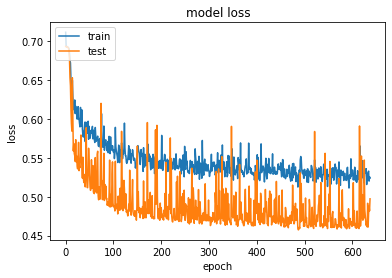

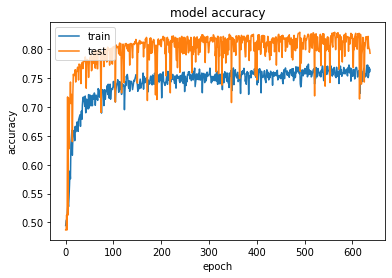

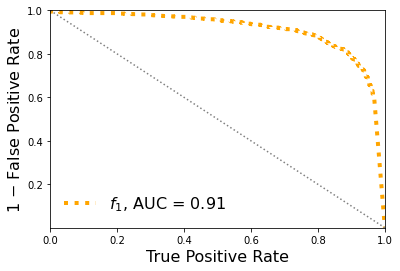

Classification score:


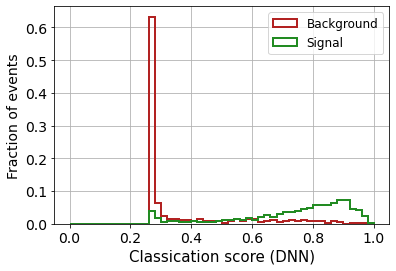


 ROC-AUC =  0.9091619420031549


In [59]:

# define the keras model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_mon_train_1D.shape[1],)))
model.add(Dropout(0.20))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [60]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9091619420031549


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 64)                360064    
_________________________________________________________________
dropout_71 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_72 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_73 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 4)               

50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 105/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 106/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5119 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 107/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 108/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 109/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 110/1500
50/50 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 1

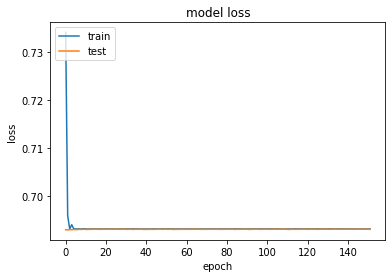

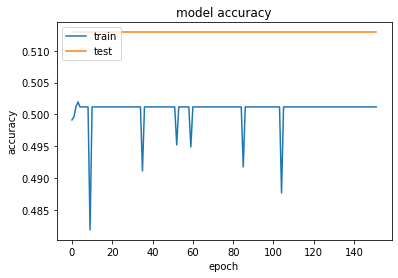

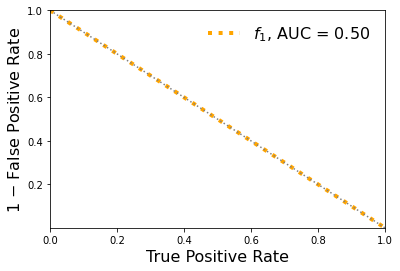

Classification score:


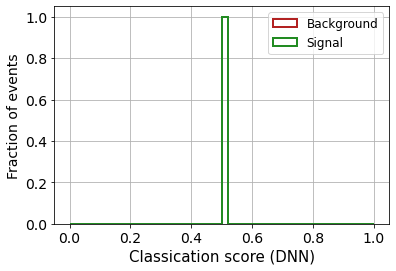


 ROC-AUC =  0.5


In [69]:

# define the keras model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_mon_train_1D.shape[1],)))
model.add(Dropout(0.20))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [70]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.5


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 128)               720128    
_________________________________________________________________
dropout_75 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_76 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_77 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 16)              

Epoch 46/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 47/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 48/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 49/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 50/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 51/1500
50/50 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5030 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 52/1500
50/50 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5096 - val_loss: 0.6931 - val_accuracy: 0.5129

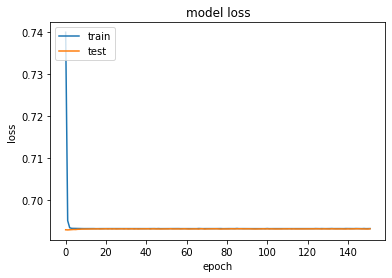

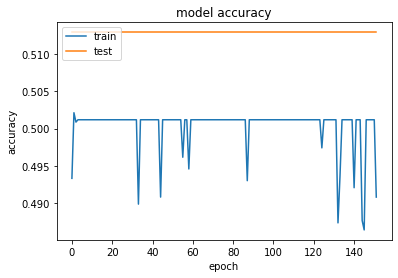

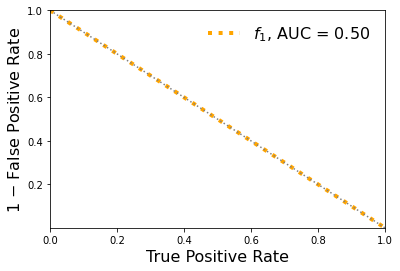

Classification score:


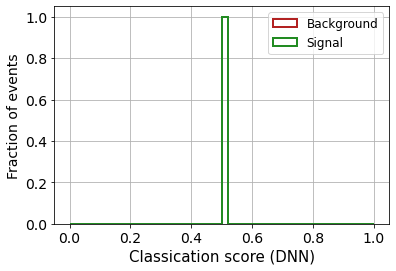


 ROC-AUC =  0.5


In [71]:

# define the keras model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_mon_train_1D.shape[1],)))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [72]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.5


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 256)               1440256   
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_81 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 32)              

Epoch 44/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 45/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4913 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 46/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 47/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 48/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 49/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 50/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4974 - val_loss: 0.6931 - val_accuracy: 0.5129

Epoch 158/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.5129
Epoch 159/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5129
Epoch 160/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5134 - val_loss: 0.6930 - val_accuracy: 0.5129
Epoch 161/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6930 - val_accuracy: 0.5129
Epoch 162/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5129
Restoring model weights from the end of the best epoch.
Epoch 00162: early stopping


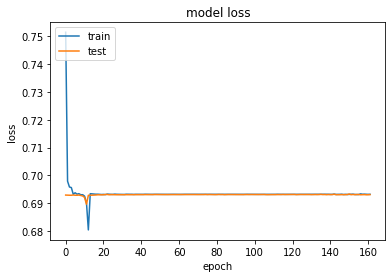

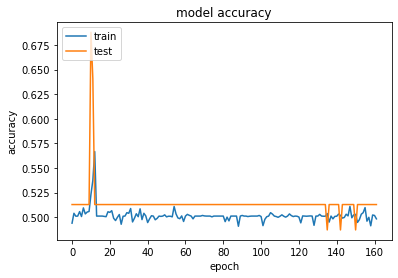

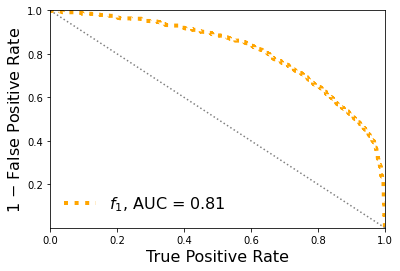

Classification score:


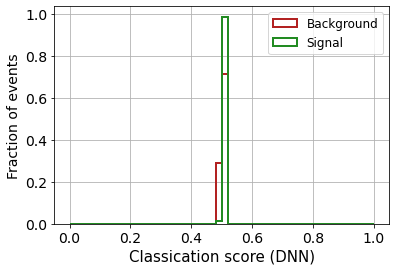


 ROC-AUC =  0.8131321958289799


In [73]:

# define the keras model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_mon_train_1D.shape[1],)))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [74]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.8131321958289799


### CNN
Several options, the best:

model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]), strides = (1,1),kernel_regularizer=l2(0.005)))

model.add(keras.layers.LeakyReLU(alpha=0.05))

model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.20))

model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))

model.add(keras.layers.LeakyReLU(alpha=0.05)) 

model.add(Dropout(0.20))

model.add(Dense(1, activation='sigmoid'))

##### 2 conv layers

Epoch 1/500
50/50 [==============================] - 6s 96ms/step - loss: 1.0473 - accuracy: 0.4992 - val_loss: 0.8043 - val_accuracy: 0.5129
Epoch 2/500
50/50 [==============================] - 5s 91ms/step - loss: 0.8066 - accuracy: 0.5356 - val_loss: 0.7336 - val_accuracy: 0.7511
Epoch 3/500
50/50 [==============================] - 5s 90ms/step - loss: 0.7425 - accuracy: 0.6363 - val_loss: 0.6383 - val_accuracy: 0.7547
Epoch 4/500
50/50 [==============================] - 5s 90ms/step - loss: 0.6579 - accuracy: 0.7303 - val_loss: 0.5811 - val_accuracy: 0.7724
Epoch 5/500
50/50 [==============================] - 5s 91ms/step - loss: 0.5963 - accuracy: 0.7740 - val_loss: 0.5797 - val_accuracy: 0.7796
Epoch 6/500
50/50 [==============================] - 5s 91ms/step - loss: 0.5818 - accuracy: 0.7789 - val_loss: 0.5483 - val_accuracy: 0.8009
Epoch 7/500
50/50 [==============================] - 5s 90ms/step - loss: 0.5510 - accuracy: 0.8023 - val_loss: 0.5959 - val_accuracy: 0.7564
Epoch 

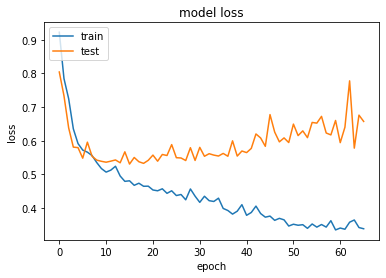

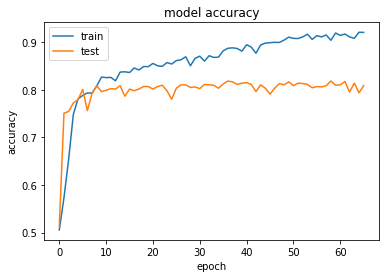

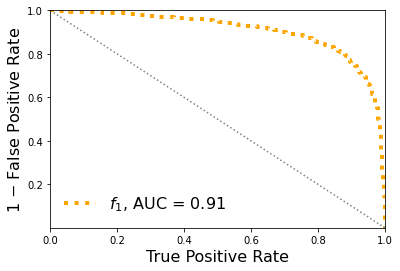

Classification score:


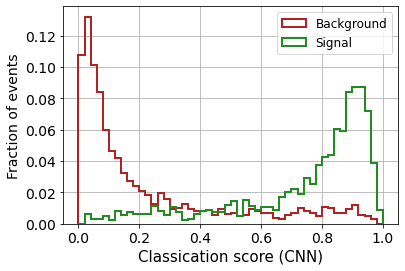


 ROC-AUC =  0.9058850869645383


In [89]:

# define the keras model
model = Sequential()
model.add(Conv2D(8, (2,2), strides = (1,1), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]) ,kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv2D(8, (2,2), kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [90]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9058850869645383


Epoch 1/500
50/50 [==============================] - 12s 226ms/step - loss: 4.4112 - accuracy: 0.4977 - val_loss: 0.8715 - val_accuracy: 0.5173
Epoch 2/500
50/50 [==============================] - 11s 221ms/step - loss: 0.9656 - accuracy: 0.5310 - val_loss: 0.8550 - val_accuracy: 0.5582
Epoch 3/500
50/50 [==============================] - 11s 221ms/step - loss: 0.8974 - accuracy: 0.5698 - val_loss: 0.7736 - val_accuracy: 0.6764
Epoch 4/500
50/50 [==============================] - 11s 222ms/step - loss: 0.7621 - accuracy: 0.6772 - val_loss: 0.6898 - val_accuracy: 0.7387
Epoch 5/500
50/50 [==============================] - 11s 222ms/step - loss: 0.6855 - accuracy: 0.7442 - val_loss: 0.6678 - val_accuracy: 0.7582
Epoch 6/500
50/50 [==============================] - 11s 222ms/step - loss: 0.6583 - accuracy: 0.7572 - val_loss: 0.6455 - val_accuracy: 0.7573
Epoch 7/500
50/50 [==============================] - 11s 222ms/step - loss: 0.6443 - accuracy: 0.7604 - val_loss: 0.6372 - val_accuracy:

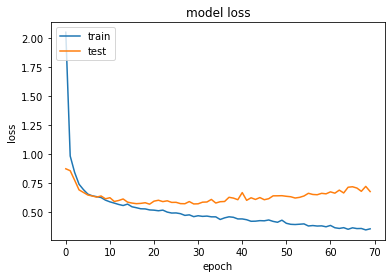

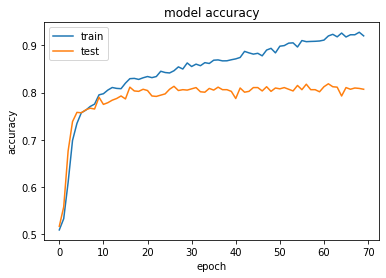

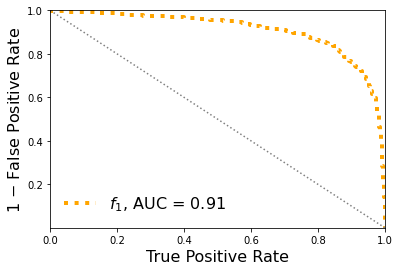

Classification score:


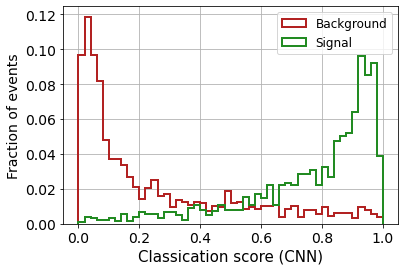


 ROC-AUC =  0.9090150164915085


In [87]:

# define the keras model
model = Sequential()
model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]) ,kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv2D(16, (3,3), kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [88]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9090150164915085


Epoch 1/500
50/50 [==============================] - 13s 235ms/step - loss: 1.8697 - accuracy: 0.5051 - val_loss: 0.8724 - val_accuracy: 0.5129
Epoch 2/500
50/50 [==============================] - 11s 228ms/step - loss: 0.8589 - accuracy: 0.5331 - val_loss: 0.7238 - val_accuracy: 0.7227
Epoch 3/500
50/50 [==============================] - 11s 226ms/step - loss: 0.7469 - accuracy: 0.6731 - val_loss: 0.6855 - val_accuracy: 0.7556
Epoch 4/500
50/50 [==============================] - 11s 226ms/step - loss: 0.6956 - accuracy: 0.7389 - val_loss: 0.6743 - val_accuracy: 0.7564
Epoch 5/500
50/50 [==============================] - 11s 229ms/step - loss: 0.6592 - accuracy: 0.7600 - val_loss: 0.6214 - val_accuracy: 0.7636
Epoch 6/500
50/50 [==============================] - 11s 228ms/step - loss: 0.6299 - accuracy: 0.7781 - val_loss: 0.6062 - val_accuracy: 0.7831
Epoch 7/500
50/50 [==============================] - 11s 230ms/step - loss: 0.5994 - accuracy: 0.7985 - val_loss: 0.6044 - val_accuracy:

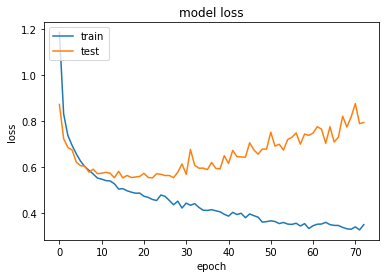

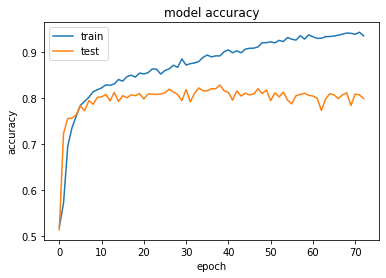

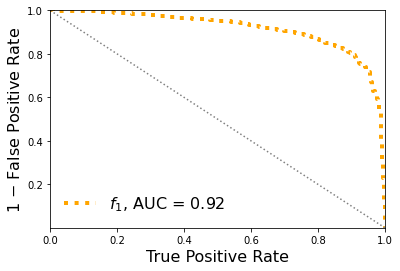

Classification score:


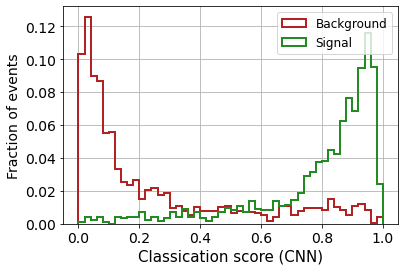


 ROC-AUC =  0.9150373619732449


In [85]:

# define the keras model
model = Sequential()
model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]) ,kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv2D(16, (3,3), kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [86]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9150373619732449


Epoch 1/500
50/50 [==============================] - 10s 176ms/step - loss: 0.8536 - accuracy: 0.5010 - val_loss: 0.7965 - val_accuracy: 0.5849
Epoch 2/500
50/50 [==============================] - 8s 169ms/step - loss: 0.7715 - accuracy: 0.6017 - val_loss: 0.6383 - val_accuracy: 0.7360
Epoch 3/500
50/50 [==============================] - 8s 170ms/step - loss: 0.6935 - accuracy: 0.7080 - val_loss: 0.6374 - val_accuracy: 0.7458
Epoch 4/500
50/50 [==============================] - 9s 171ms/step - loss: 0.6287 - accuracy: 0.7444 - val_loss: 0.6026 - val_accuracy: 0.7618
Epoch 5/500
50/50 [==============================] - 8s 170ms/step - loss: 0.6116 - accuracy: 0.7722 - val_loss: 0.5903 - val_accuracy: 0.7618
Epoch 6/500
50/50 [==============================] - 8s 170ms/step - loss: 0.5890 - accuracy: 0.7679 - val_loss: 0.5618 - val_accuracy: 0.7804
Epoch 7/500
50/50 [==============================] - 8s 170ms/step - loss: 0.5652 - accuracy: 0.7828 - val_loss: 0.5557 - val_accuracy: 0.787

Epoch 58/500
50/50 [==============================] - 9s 179ms/step - loss: 0.3131 - accuracy: 0.9423 - val_loss: 0.7216 - val_accuracy: 0.8089
Epoch 59/500
50/50 [==============================] - 9s 177ms/step - loss: 0.3209 - accuracy: 0.9417 - val_loss: 0.7959 - val_accuracy: 0.8062
Epoch 60/500
50/50 [==============================] - 9s 176ms/step - loss: 0.3390 - accuracy: 0.9366 - val_loss: 0.7459 - val_accuracy: 0.8062
Epoch 61/500
50/50 [==============================] - 9s 173ms/step - loss: 0.3269 - accuracy: 0.9397 - val_loss: 0.7791 - val_accuracy: 0.8027
Epoch 62/500
50/50 [==============================] - 9s 175ms/step - loss: 0.3196 - accuracy: 0.9454 - val_loss: 0.7475 - val_accuracy: 0.8142
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping


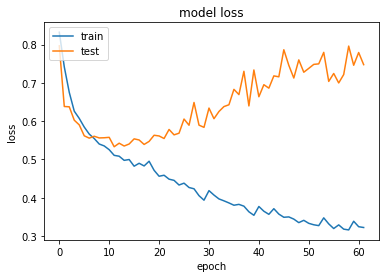

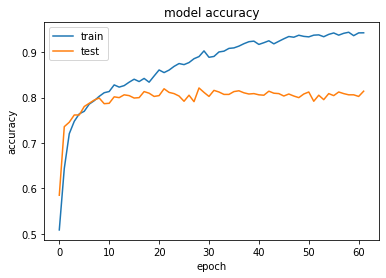

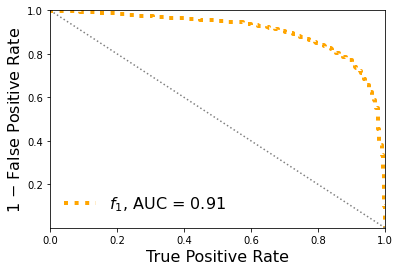

Classification score:


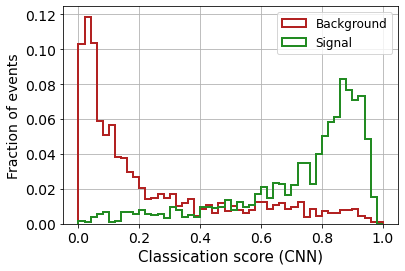


 ROC-AUC =  0.9051091666154508


In [83]:

# define the keras model
model = Sequential()
model.add(Conv2D(16, (3,3), strides = (1,1), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]) ,kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv2D(8, (3,3), kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [84]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9051091666154508


Epoch 1/500
50/50 [==============================] - 7s 123ms/step - loss: 1.3059 - accuracy: 0.5176 - val_loss: 0.7193 - val_accuracy: 0.7564
Epoch 2/500
50/50 [==============================] - 6s 118ms/step - loss: 0.6963 - accuracy: 0.6822 - val_loss: 0.6215 - val_accuracy: 0.7591
Epoch 3/500
50/50 [==============================] - 6s 118ms/step - loss: 0.6267 - accuracy: 0.7368 - val_loss: 0.5820 - val_accuracy: 0.7653
Epoch 4/500
50/50 [==============================] - 6s 118ms/step - loss: 0.6049 - accuracy: 0.7443 - val_loss: 0.5883 - val_accuracy: 0.7547
Epoch 5/500
50/50 [==============================] - 6s 118ms/step - loss: 0.5711 - accuracy: 0.7761 - val_loss: 0.5561 - val_accuracy: 0.7716
Epoch 6/500
50/50 [==============================] - 6s 118ms/step - loss: 0.5601 - accuracy: 0.7806 - val_loss: 0.5455 - val_accuracy: 0.7920
Epoch 7/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5494 - accuracy: 0.7889 - val_loss: 0.5497 - val_accuracy: 0.7733

Epoch 58/500
50/50 [==============================] - 6s 117ms/step - loss: 0.3272 - accuracy: 0.9165 - val_loss: 0.6496 - val_accuracy: 0.7911
Epoch 59/500
50/50 [==============================] - 6s 118ms/step - loss: 0.3140 - accuracy: 0.9231 - val_loss: 0.6576 - val_accuracy: 0.7982
Epoch 60/500
50/50 [==============================] - 6s 118ms/step - loss: 0.3219 - accuracy: 0.9230 - val_loss: 0.6256 - val_accuracy: 0.8027
Epoch 61/500
50/50 [==============================] - 6s 118ms/step - loss: 0.3427 - accuracy: 0.9066 - val_loss: 0.6361 - val_accuracy: 0.7902
Epoch 62/500
50/50 [==============================] - 6s 118ms/step - loss: 0.3316 - accuracy: 0.9173 - val_loss: 0.7068 - val_accuracy: 0.7956
Epoch 63/500
50/50 [==============================] - 6s 118ms/step - loss: 0.3112 - accuracy: 0.9238 - val_loss: 0.6441 - val_accuracy: 0.8098
Epoch 64/500
50/50 [==============================] - 6s 118ms/step - loss: 0.3064 - accuracy: 0.9306 - val_loss: 0.6436 - val_accuracy:

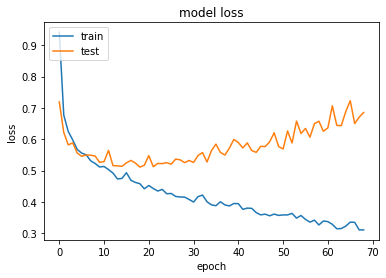

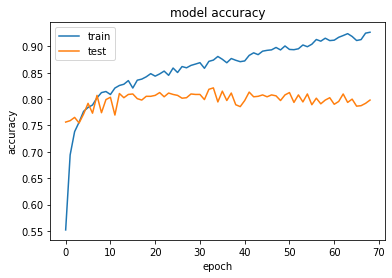

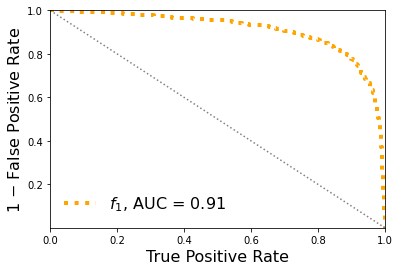

Classification score:


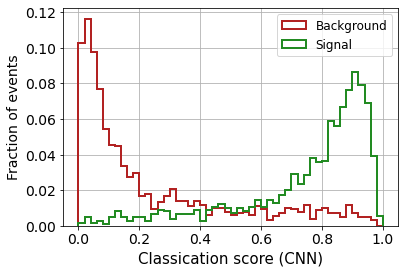


 ROC-AUC =  0.9097153934402721


In [82]:

# define the keras model
model = Sequential()
model.add(Conv2D(8, (3,3), strides = (1,1), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]) ,kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv2D(8, (3,3), kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [ ]:
print('\n ROC-AUC = ', roc_auc_cnn)

Epoch 1/500
50/50 [==============================] - 7s 127ms/step - loss: 0.8591 - accuracy: 0.4944 - val_loss: 0.7803 - val_accuracy: 0.5129
Epoch 2/500
50/50 [==============================] - 6s 118ms/step - loss: 0.7690 - accuracy: 0.5516 - val_loss: 0.6499 - val_accuracy: 0.7538
Epoch 3/500
50/50 [==============================] - 6s 118ms/step - loss: 0.6535 - accuracy: 0.7052 - val_loss: 0.5749 - val_accuracy: 0.7582
Epoch 4/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5925 - accuracy: 0.7706 - val_loss: 0.5702 - val_accuracy: 0.7742
Epoch 5/500
50/50 [==============================] - 6s 120ms/step - loss: 0.5701 - accuracy: 0.7784 - val_loss: 0.5689 - val_accuracy: 0.7609
Epoch 6/500
50/50 [==============================] - 6s 126ms/step - loss: 0.5522 - accuracy: 0.7877 - val_loss: 0.5461 - val_accuracy: 0.7751
Epoch 7/500
50/50 [==============================] - 6s 126ms/step - loss: 0.5375 - accuracy: 0.8001 - val_loss: 0.5646 - val_accuracy: 0.7840

Epoch 58/500
50/50 [==============================] - 6s 118ms/step - loss: 0.2960 - accuracy: 0.9466 - val_loss: 0.8142 - val_accuracy: 0.7902
Epoch 59/500
50/50 [==============================] - 6s 119ms/step - loss: 0.3286 - accuracy: 0.9350 - val_loss: 0.8133 - val_accuracy: 0.7982
Epoch 60/500
50/50 [==============================] - 6s 119ms/step - loss: 0.3015 - accuracy: 0.9445 - val_loss: 0.8187 - val_accuracy: 0.7964
Epoch 61/500
50/50 [==============================] - 6s 119ms/step - loss: 0.3041 - accuracy: 0.9438 - val_loss: 0.7381 - val_accuracy: 0.8000
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping


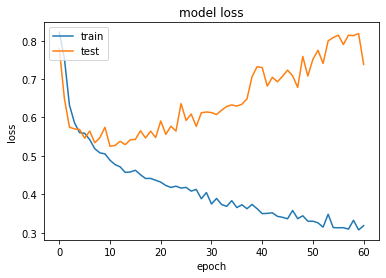

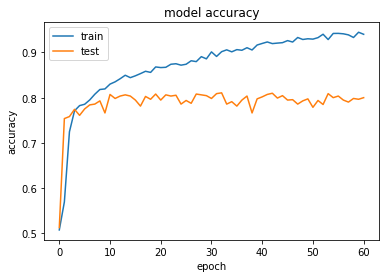

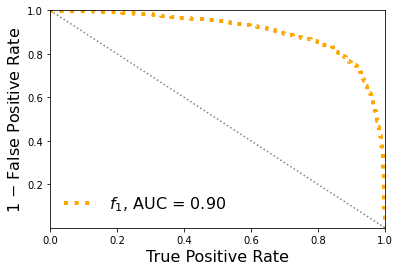

Classification score:


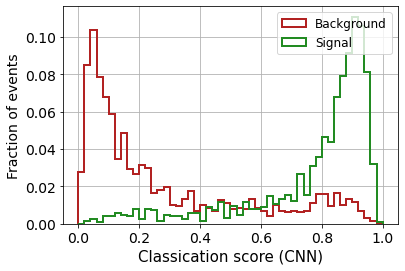


 ROC-AUC =  0.9048255587650831


In [80]:

# define the keras model
model = Sequential()
model.add(Conv2D(8, (3,3), strides = (1,1), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]) ,kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv2D(8, (3,3), kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.2)) 

model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [81]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9048255587650831


Epoch 1/500
50/50 [==============================] - 8s 126ms/step - loss: 1.3676 - accuracy: 0.4890 - val_loss: 0.8375 - val_accuracy: 0.7040
Epoch 2/500
50/50 [==============================] - 6s 121ms/step - loss: 0.8391 - accuracy: 0.4927 - val_loss: 0.8148 - val_accuracy: 0.6293
Epoch 3/500
50/50 [==============================] - 6s 120ms/step - loss: 0.8111 - accuracy: 0.5129 - val_loss: 0.8050 - val_accuracy: 0.6498
Epoch 4/500
50/50 [==============================] - 6s 119ms/step - loss: 0.7901 - accuracy: 0.5473 - val_loss: 0.7437 - val_accuracy: 0.7458
Epoch 5/500
50/50 [==============================] - 6s 124ms/step - loss: 0.7592 - accuracy: 0.6403 - val_loss: 0.6531 - val_accuracy: 0.7413
Epoch 6/500
50/50 [==============================] - 6s 122ms/step - loss: 0.7096 - accuracy: 0.6746 - val_loss: 0.6260 - val_accuracy: 0.7493
Epoch 7/500
50/50 [==============================] - 6s 122ms/step - loss: 0.7031 - accuracy: 0.6882 - val_loss: 0.6130 - val_accuracy: 0.7627

Epoch 58/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5397 - accuracy: 0.8279 - val_loss: 0.5901 - val_accuracy: 0.8178
Epoch 59/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5253 - accuracy: 0.8363 - val_loss: 0.5799 - val_accuracy: 0.8044
Epoch 60/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5253 - accuracy: 0.8406 - val_loss: 0.5777 - val_accuracy: 0.8187
Epoch 61/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5242 - accuracy: 0.8370 - val_loss: 0.5685 - val_accuracy: 0.8187
Epoch 62/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5211 - accuracy: 0.8405 - val_loss: 0.5760 - val_accuracy: 0.8107
Epoch 63/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5142 - accuracy: 0.8440 - val_loss: 0.5882 - val_accuracy: 0.8027
Epoch 64/500
50/50 [==============================] - 6s 119ms/step - loss: 0.5407 - accuracy: 0.8304 - val_loss: 0.5820 - val_accuracy:

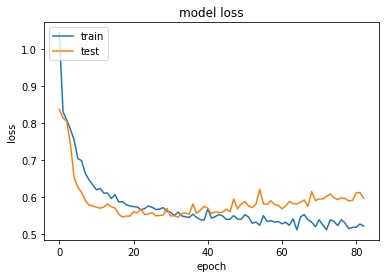

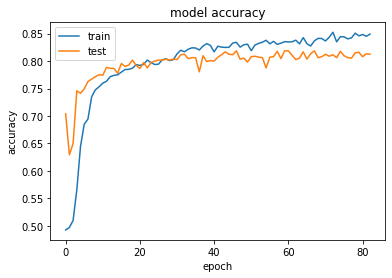

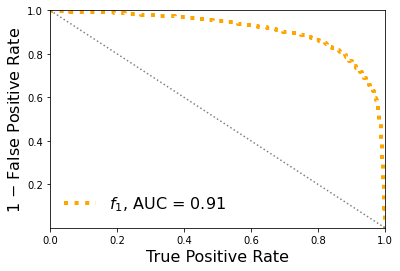

Classification score:


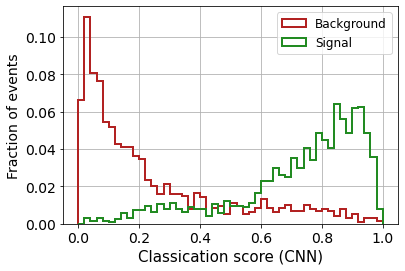


 ROC-AUC =  0.9093037459283387


In [78]:

# define the keras model
model = Sequential()
model.add(Conv2D(8, (3,3), strides = (1,1), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]) ,kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv2D(8, (3,3), kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.5)) 

model.add(Dense(8, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))    
model.add(Dropout(0.5)) 

model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [79]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9093037459283387


#####  1 conv layer

Epoch 1/500
50/50 [==============================] - 4s 72ms/step - loss: 1.5618 - accuracy: 0.5165 - val_loss: 0.7388 - val_accuracy: 0.4871
Epoch 2/500
50/50 [==============================] - 3s 67ms/step - loss: 0.7007 - accuracy: 0.6458 - val_loss: 0.5787 - val_accuracy: 0.7564
Epoch 3/500
50/50 [==============================] - 3s 67ms/step - loss: 0.5854 - accuracy: 0.7588 - val_loss: 0.5472 - val_accuracy: 0.7689
Epoch 4/500
50/50 [==============================] - 3s 67ms/step - loss: 0.5277 - accuracy: 0.7923 - val_loss: 0.5273 - val_accuracy: 0.7822
Epoch 5/500
50/50 [==============================] - 3s 67ms/step - loss: 0.5041 - accuracy: 0.8078 - val_loss: 0.5225 - val_accuracy: 0.7822
Epoch 6/500
50/50 [==============================] - 3s 67ms/step - loss: 0.4798 - accuracy: 0.8253 - val_loss: 0.5205 - val_accuracy: 0.7920
Epoch 7/500
50/50 [==============================] - 3s 67ms/step - loss: 0.4956 - accuracy: 0.8096 - val_loss: 0.5239 - val_accuracy: 0.7982
Epoch 

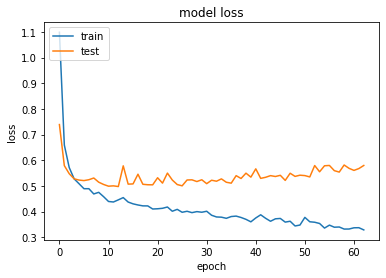

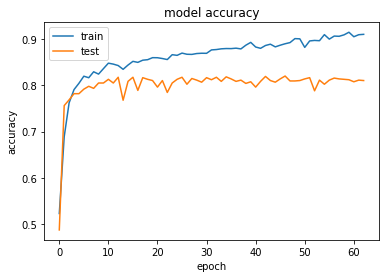

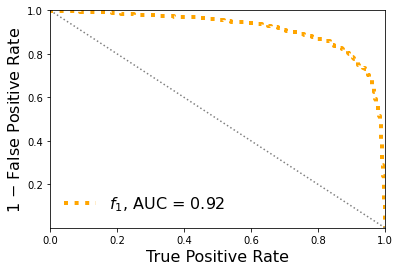

Classification score:


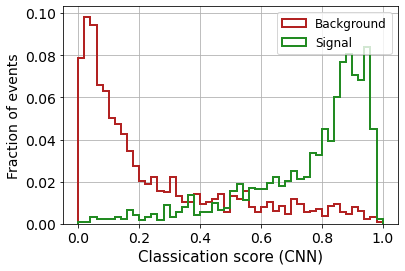


 ROC-AUC =  0.9159426023805134


In [91]:

# define the keras model
model = Sequential()
model.add(Conv2D(8, (3,3), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]), strides = (1,1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [92]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9159426023805134


Epoch 1/500
50/50 [==============================] - 7s 118ms/step - loss: 4.1506 - accuracy: 0.5158 - val_loss: 0.7538 - val_accuracy: 0.7084
Epoch 2/500
50/50 [==============================] - 6s 113ms/step - loss: 0.8304 - accuracy: 0.5937 - val_loss: 0.6857 - val_accuracy: 0.7440
Epoch 3/500
50/50 [==============================] - 6s 115ms/step - loss: 0.7053 - accuracy: 0.7021 - val_loss: 0.6197 - val_accuracy: 0.7556
Epoch 4/500
50/50 [==============================] - 6s 116ms/step - loss: 0.6262 - accuracy: 0.7527 - val_loss: 0.6154 - val_accuracy: 0.7636
Epoch 5/500
50/50 [==============================] - 6s 122ms/step - loss: 0.6012 - accuracy: 0.7647 - val_loss: 0.5861 - val_accuracy: 0.7822
Epoch 6/500
50/50 [==============================] - 6s 121ms/step - loss: 0.5739 - accuracy: 0.7810 - val_loss: 0.5682 - val_accuracy: 0.7964
Epoch 7/500
50/50 [==============================] - 6s 123ms/step - loss: 0.5491 - accuracy: 0.7924 - val_loss: 0.5577 - val_accuracy: 0.7804

Epoch 58/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3796 - accuracy: 0.8835 - val_loss: 0.5760 - val_accuracy: 0.8142
Epoch 59/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3766 - accuracy: 0.8885 - val_loss: 0.5427 - val_accuracy: 0.8169
Epoch 60/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3731 - accuracy: 0.8932 - val_loss: 0.5586 - val_accuracy: 0.8116
Epoch 61/500
50/50 [==============================] - 6s 124ms/step - loss: 0.3714 - accuracy: 0.8952 - val_loss: 0.6215 - val_accuracy: 0.8044
Epoch 62/500
50/50 [==============================] - 6s 123ms/step - loss: 0.3857 - accuracy: 0.8853 - val_loss: 0.5438 - val_accuracy: 0.8196
Epoch 63/500
50/50 [==============================] - 6s 123ms/step - loss: 0.3780 - accuracy: 0.8862 - val_loss: 0.5422 - val_accuracy: 0.8053
Epoch 64/500
50/50 [==============================] - 6s 122ms/step - loss: 0.3812 - accuracy: 0.8854 - val_loss: 0.5537 - val_accuracy:

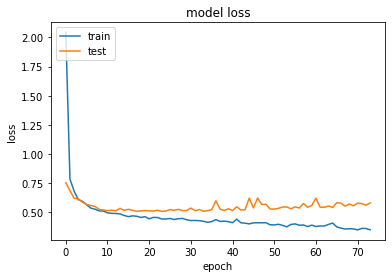

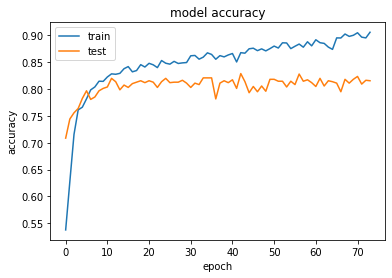

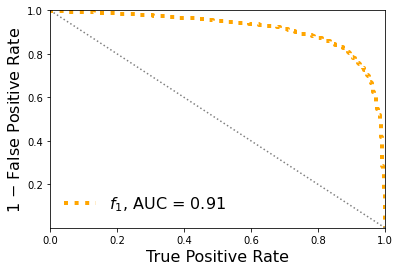

Classification score:


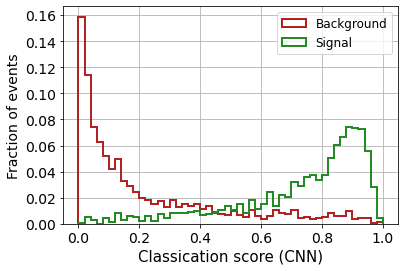


 ROC-AUC =  0.9149330096490688


In [130]:

# define the keras model
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]), strides = (1,1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [131]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9149330096490688


Epoch 1/500
50/50 [==============================] - 12s 227ms/step - loss: 3.7076 - accuracy: 0.5597 - val_loss: 0.6155 - val_accuracy: 0.7396
Epoch 2/500
50/50 [==============================] - 11s 222ms/step - loss: 0.6089 - accuracy: 0.7526 - val_loss: 0.5650 - val_accuracy: 0.7778
Epoch 3/500
50/50 [==============================] - 11s 223ms/step - loss: 0.5685 - accuracy: 0.7685 - val_loss: 0.5619 - val_accuracy: 0.7831
Epoch 4/500
50/50 [==============================] - 11s 222ms/step - loss: 0.5415 - accuracy: 0.7941 - val_loss: 0.5259 - val_accuracy: 0.7964
Epoch 5/500
50/50 [==============================] - 11s 222ms/step - loss: 0.5062 - accuracy: 0.8182 - val_loss: 0.5162 - val_accuracy: 0.8053
Epoch 6/500
50/50 [==============================] - 11s 222ms/step - loss: 0.5143 - accuracy: 0.8068 - val_loss: 0.6124 - val_accuracy: 0.7493
Epoch 7/500
50/50 [==============================] - 11s 221ms/step - loss: 0.5176 - accuracy: 0.8070 - val_loss: 0.5370 - val_accuracy:

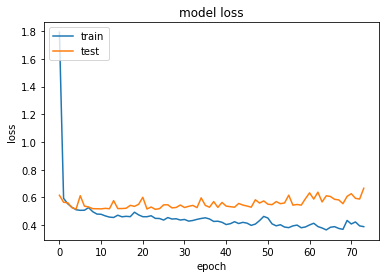

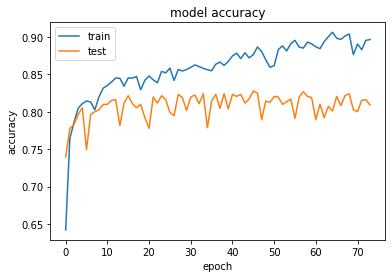

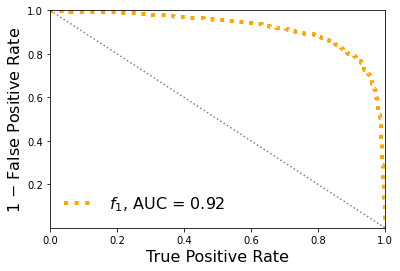

Classification score:


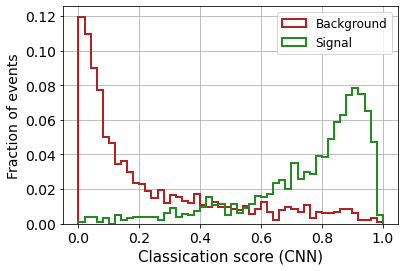


 ROC-AUC =  0.91784463155307


In [93]:

# define the keras model
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]), strides = (1,1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [94]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.91784463155307


Epoch 1/500
50/50 [==============================] - 7s 118ms/step - loss: 5.6711 - accuracy: 0.4907 - val_loss: 0.8270 - val_accuracy: 0.5129
Epoch 2/500
50/50 [==============================] - 6s 112ms/step - loss: 1.1648 - accuracy: 0.5188 - val_loss: 0.7956 - val_accuracy: 0.6009
Epoch 3/500
50/50 [==============================] - 6s 114ms/step - loss: 1.0068 - accuracy: 0.5415 - val_loss: 0.7308 - val_accuracy: 0.6853
Epoch 4/500
50/50 [==============================] - 6s 113ms/step - loss: 0.7999 - accuracy: 0.6333 - val_loss: 0.6719 - val_accuracy: 0.7689
Epoch 5/500
50/50 [==============================] - 6s 114ms/step - loss: 0.7120 - accuracy: 0.7053 - val_loss: 0.7077 - val_accuracy: 0.7662
Epoch 6/500
50/50 [==============================] - 6s 112ms/step - loss: 0.7107 - accuracy: 0.7041 - val_loss: 0.6384 - val_accuracy: 0.7644
Epoch 7/500
50/50 [==============================] - 6s 113ms/step - loss: 0.6478 - accuracy: 0.7480 - val_loss: 0.6390 - val_accuracy: 0.7538

Epoch 58/500
50/50 [==============================] - 6s 114ms/step - loss: 0.3991 - accuracy: 0.8691 - val_loss: 0.5262 - val_accuracy: 0.8160
Epoch 59/500
50/50 [==============================] - 6s 115ms/step - loss: 0.4011 - accuracy: 0.8714 - val_loss: 0.5113 - val_accuracy: 0.8169
Epoch 60/500
50/50 [==============================] - 6s 115ms/step - loss: 0.4277 - accuracy: 0.8575 - val_loss: 0.5286 - val_accuracy: 0.8107
Epoch 61/500
50/50 [==============================] - 6s 114ms/step - loss: 0.4136 - accuracy: 0.8588 - val_loss: 0.5394 - val_accuracy: 0.8027
Epoch 62/500
50/50 [==============================] - 6s 114ms/step - loss: 0.4007 - accuracy: 0.8689 - val_loss: 0.5120 - val_accuracy: 0.8124
Epoch 63/500
50/50 [==============================] - 6s 114ms/step - loss: 0.3964 - accuracy: 0.8640 - val_loss: 0.5362 - val_accuracy: 0.8133
Epoch 64/500
50/50 [==============================] - 6s 114ms/step - loss: 0.4039 - accuracy: 0.8641 - val_loss: 0.5323 - val_accuracy:

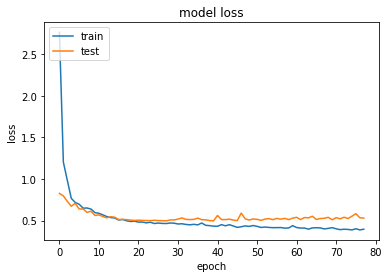

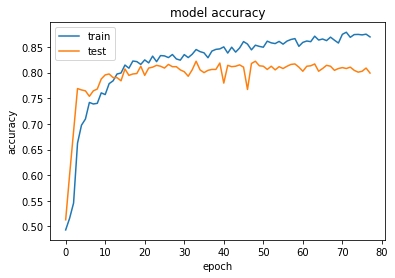

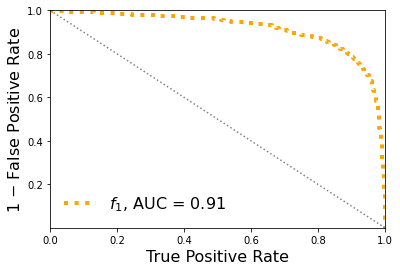

Classification score:


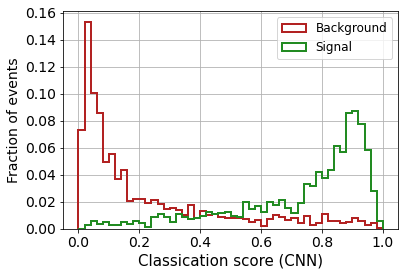


 ROC-AUC =  0.9147960072111937


In [95]:

# define the keras model
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]), strides = (1,1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [96]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9147960072111937


Epoch 1/500
50/50 [==============================] - 7s 128ms/step - loss: 7.9583 - accuracy: 0.4905 - val_loss: 0.8223 - val_accuracy: 0.6142
Epoch 2/500
50/50 [==============================] - 6s 122ms/step - loss: 0.9040 - accuracy: 0.5204 - val_loss: 0.7834 - val_accuracy: 0.7271
Epoch 3/500
50/50 [==============================] - 6s 123ms/step - loss: 0.8186 - accuracy: 0.5609 - val_loss: 0.7914 - val_accuracy: 0.4898
Epoch 4/500
50/50 [==============================] - 6s 123ms/step - loss: 0.8324 - accuracy: 0.5319 - val_loss: 0.7672 - val_accuracy: 0.7307
Epoch 5/500
50/50 [==============================] - 6s 124ms/step - loss: 0.7710 - accuracy: 0.6334 - val_loss: 0.7438 - val_accuracy: 0.7316
Epoch 6/500
50/50 [==============================] - 6s 123ms/step - loss: 0.7261 - accuracy: 0.7017 - val_loss: 0.6123 - val_accuracy: 0.7493
Epoch 7/500
50/50 [==============================] - 6s 123ms/step - loss: 0.6964 - accuracy: 0.6844 - val_loss: 0.6073 - val_accuracy: 0.7547

Epoch 58/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3856 - accuracy: 0.8904 - val_loss: 0.5385 - val_accuracy: 0.8116
Epoch 59/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3784 - accuracy: 0.8835 - val_loss: 0.5502 - val_accuracy: 0.8062
Epoch 60/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3780 - accuracy: 0.8900 - val_loss: 0.5349 - val_accuracy: 0.8062
Epoch 61/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3868 - accuracy: 0.8890 - val_loss: 0.5696 - val_accuracy: 0.8098
Epoch 62/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3962 - accuracy: 0.8776 - val_loss: 0.5641 - val_accuracy: 0.8196
Epoch 63/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3701 - accuracy: 0.8946 - val_loss: 0.5353 - val_accuracy: 0.8151
Epoch 64/500
50/50 [==============================] - 6s 121ms/step - loss: 0.3777 - accuracy: 0.8907 - val_loss: 0.5560 - val_accuracy:

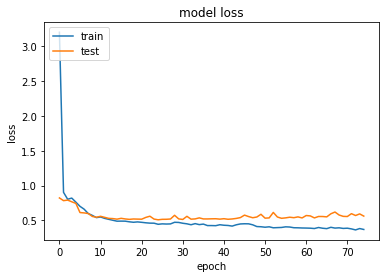

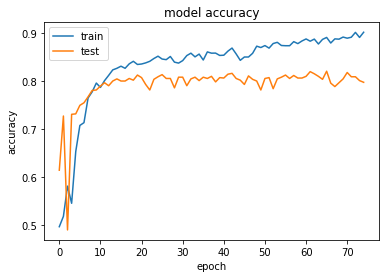

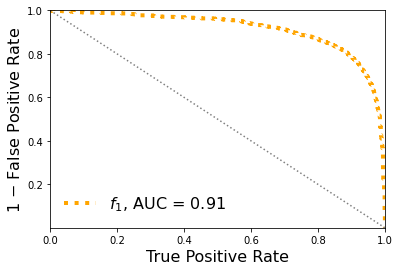

Classification score:


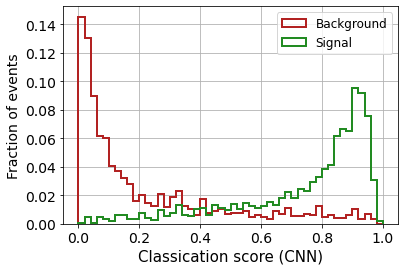


 ROC-AUC =  0.9139269380083175


In [97]:

# define the keras model
model = Sequential()
model.add(Conv2D(16, (4,4), input_shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]), strides = (1,1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling2D((2,2), strides = (1,1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [98]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9139269380083175


## 2. only time diff

In [18]:
# concatenate the data

# all the background features
X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))

# all the signal features
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')



X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)



# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)



X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)



print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 1)
X_mon_S.shape:  (5000, 1)

X_mon5.shape:  (10000, 1)

X_mon5_train :  (6375, 1)
y_mon5_train :  (6375,)
X_mon5_val :  (1125, 1)
y_mon5_val :  (1125,)
X_mon5_test :  (2500, 1)
y_mon5_test :  (2500,)



In [19]:
X_mon_train_1D = np.concatenate([X_mon_train_1D, X_mon5_train],axis=1)
X_mon_test_1D = np.concatenate([X_mon_test_1D, X_mon5_test],axis=1)
X_mon_val_1D = np.concatenate([X_mon_val_1D, X_mon5_val],axis=1)




print('')
print('X_mon_train_1D : ', X_mon_train_1D.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val_1D : ', X_mon_val_1D.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test_1D : ', X_mon_test_1D.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train_1D :  (6375, 5626)
y_mon_train :  (6375,)
X_mon_val_1D :  (1125, 5626)
y_mon_val :  (1125,)
X_mon_test_1D :  (2500, 5626)
y_mon_test :  (2500,)



### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68857	validation_1-logloss:0.68900
[1]	validation_0-logloss:0.68417	validation_1-logloss:0.68506
[2]	validation_0-logloss:0.67976	validation_1-logloss:0.68109
[3]	validation_0-logloss:0.67546	validation_1-logloss:0.67727
[4]	validation_0-logloss:0.67127	validation_1-logloss:0.67358
[5]	validation_0-logloss:0.66712	validation_1-logloss:0.66987
[6]	validation_0-logloss:0.66305	validation_1-logloss:0.66622
[7]	validation_0-logloss:0.65906	validation_1-logloss:0.66259
[8]	validation_0-logloss:0.65511	validation_1-logloss:0.65906
[9]	validation_0-logloss:0.65123	validation_1-logloss:0.65564
[10]	validation_0-logloss:0.64743	validation_1-logloss:0.65232
[11]	validation_0-logloss:0.64367	validation_1-logloss:0.64899
[12]	validation_0-logloss:0.63998	validation_1-logloss:0.64574
[13]	validation_0-logloss:0.63635	validation_1-logloss:0.64260
[14]	validation_0-logloss:0.63276	validation_1-logloss:0.63944
[15]	validation_0-logloss:0.62920	validation_1-logloss:0.63633
[1

[130]	validation_0-logloss:0.40394	validation_1-logloss:0.46738
[131]	validation_0-logloss:0.40283	validation_1-logloss:0.46675
[132]	validation_0-logloss:0.40165	validation_1-logloss:0.46601
[133]	validation_0-logloss:0.40059	validation_1-logloss:0.46539
[134]	validation_0-logloss:0.39952	validation_1-logloss:0.46473
[135]	validation_0-logloss:0.39843	validation_1-logloss:0.46403
[136]	validation_0-logloss:0.39732	validation_1-logloss:0.46341
[137]	validation_0-logloss:0.39617	validation_1-logloss:0.46274
[138]	validation_0-logloss:0.39510	validation_1-logloss:0.46202
[139]	validation_0-logloss:0.39408	validation_1-logloss:0.46144
[140]	validation_0-logloss:0.39304	validation_1-logloss:0.46085
[141]	validation_0-logloss:0.39193	validation_1-logloss:0.46023
[142]	validation_0-logloss:0.39090	validation_1-logloss:0.45963
[143]	validation_0-logloss:0.38994	validation_1-logloss:0.45907
[144]	validation_0-logloss:0.38899	validation_1-logloss:0.45838
[145]	validation_0-logloss:0.38797	valid

[259]	validation_0-logloss:0.29893	validation_1-logloss:0.41507
[260]	validation_0-logloss:0.29829	validation_1-logloss:0.41482
[261]	validation_0-logloss:0.29771	validation_1-logloss:0.41446
[262]	validation_0-logloss:0.29711	validation_1-logloss:0.41420
[263]	validation_0-logloss:0.29655	validation_1-logloss:0.41391
[264]	validation_0-logloss:0.29593	validation_1-logloss:0.41371
[265]	validation_0-logloss:0.29533	validation_1-logloss:0.41344
[266]	validation_0-logloss:0.29473	validation_1-logloss:0.41308
[267]	validation_0-logloss:0.29413	validation_1-logloss:0.41285
[268]	validation_0-logloss:0.29352	validation_1-logloss:0.41263
[269]	validation_0-logloss:0.29303	validation_1-logloss:0.41248
[270]	validation_0-logloss:0.29241	validation_1-logloss:0.41235
[271]	validation_0-logloss:0.29183	validation_1-logloss:0.41223
[272]	validation_0-logloss:0.29124	validation_1-logloss:0.41196
[273]	validation_0-logloss:0.29068	validation_1-logloss:0.41172
[274]	validation_0-logloss:0.29011	valid

[388]	validation_0-logloss:0.23343	validation_1-logloss:0.39249
[389]	validation_0-logloss:0.23298	validation_1-logloss:0.39232
[390]	validation_0-logloss:0.23255	validation_1-logloss:0.39213
[391]	validation_0-logloss:0.23212	validation_1-logloss:0.39199
[392]	validation_0-logloss:0.23171	validation_1-logloss:0.39178
[393]	validation_0-logloss:0.23131	validation_1-logloss:0.39165
[394]	validation_0-logloss:0.23088	validation_1-logloss:0.39150
[395]	validation_0-logloss:0.23049	validation_1-logloss:0.39130
[396]	validation_0-logloss:0.23004	validation_1-logloss:0.39120
[397]	validation_0-logloss:0.22964	validation_1-logloss:0.39115
[398]	validation_0-logloss:0.22921	validation_1-logloss:0.39101
[399]	validation_0-logloss:0.22879	validation_1-logloss:0.39085
[400]	validation_0-logloss:0.22835	validation_1-logloss:0.39063
[401]	validation_0-logloss:0.22796	validation_1-logloss:0.39052
[402]	validation_0-logloss:0.22757	validation_1-logloss:0.39037
[403]	validation_0-logloss:0.22715	valid

[517]	validation_0-logloss:0.18632	validation_1-logloss:0.37587
[518]	validation_0-logloss:0.18599	validation_1-logloss:0.37582
[519]	validation_0-logloss:0.18571	validation_1-logloss:0.37571
[520]	validation_0-logloss:0.18537	validation_1-logloss:0.37568
[521]	validation_0-logloss:0.18503	validation_1-logloss:0.37554
[522]	validation_0-logloss:0.18471	validation_1-logloss:0.37543
[523]	validation_0-logloss:0.18439	validation_1-logloss:0.37532
[524]	validation_0-logloss:0.18410	validation_1-logloss:0.37523
[525]	validation_0-logloss:0.18379	validation_1-logloss:0.37517
[526]	validation_0-logloss:0.18349	validation_1-logloss:0.37504
[527]	validation_0-logloss:0.18316	validation_1-logloss:0.37491
[528]	validation_0-logloss:0.18284	validation_1-logloss:0.37476
[529]	validation_0-logloss:0.18257	validation_1-logloss:0.37464
[530]	validation_0-logloss:0.18227	validation_1-logloss:0.37461
[531]	validation_0-logloss:0.18193	validation_1-logloss:0.37453
[532]	validation_0-logloss:0.18161	valid

[646]	validation_0-logloss:0.15040	validation_1-logloss:0.36513
[647]	validation_0-logloss:0.15016	validation_1-logloss:0.36509
[648]	validation_0-logloss:0.14993	validation_1-logloss:0.36507
[649]	validation_0-logloss:0.14970	validation_1-logloss:0.36496
[650]	validation_0-logloss:0.14946	validation_1-logloss:0.36489
[651]	validation_0-logloss:0.14920	validation_1-logloss:0.36480
[652]	validation_0-logloss:0.14891	validation_1-logloss:0.36467
[653]	validation_0-logloss:0.14869	validation_1-logloss:0.36458
[654]	validation_0-logloss:0.14843	validation_1-logloss:0.36452
[655]	validation_0-logloss:0.14819	validation_1-logloss:0.36449
[656]	validation_0-logloss:0.14797	validation_1-logloss:0.36450
[657]	validation_0-logloss:0.14774	validation_1-logloss:0.36455
[658]	validation_0-logloss:0.14751	validation_1-logloss:0.36448
[659]	validation_0-logloss:0.14730	validation_1-logloss:0.36447
[660]	validation_0-logloss:0.14705	validation_1-logloss:0.36442
[661]	validation_0-logloss:0.14681	valid

[775]	validation_0-logloss:0.12346	validation_1-logloss:0.35795
[776]	validation_0-logloss:0.12326	validation_1-logloss:0.35792
[777]	validation_0-logloss:0.12306	validation_1-logloss:0.35781
[778]	validation_0-logloss:0.12288	validation_1-logloss:0.35776
[779]	validation_0-logloss:0.12271	validation_1-logloss:0.35776
[780]	validation_0-logloss:0.12254	validation_1-logloss:0.35772
[781]	validation_0-logloss:0.12234	validation_1-logloss:0.35762
[782]	validation_0-logloss:0.12214	validation_1-logloss:0.35755
[783]	validation_0-logloss:0.12197	validation_1-logloss:0.35754
[784]	validation_0-logloss:0.12178	validation_1-logloss:0.35747
[785]	validation_0-logloss:0.12158	validation_1-logloss:0.35739
[786]	validation_0-logloss:0.12145	validation_1-logloss:0.35732
[787]	validation_0-logloss:0.12130	validation_1-logloss:0.35735
[788]	validation_0-logloss:0.12108	validation_1-logloss:0.35725
[789]	validation_0-logloss:0.12092	validation_1-logloss:0.35729
[790]	validation_0-logloss:0.12073	valid

[904]	validation_0-logloss:0.10214	validation_1-logloss:0.35335
[905]	validation_0-logloss:0.10199	validation_1-logloss:0.35330
[906]	validation_0-logloss:0.10187	validation_1-logloss:0.35329
[907]	validation_0-logloss:0.10169	validation_1-logloss:0.35335
[908]	validation_0-logloss:0.10157	validation_1-logloss:0.35333
[909]	validation_0-logloss:0.10143	validation_1-logloss:0.35331
[910]	validation_0-logloss:0.10129	validation_1-logloss:0.35325
[911]	validation_0-logloss:0.10112	validation_1-logloss:0.35319
[912]	validation_0-logloss:0.10098	validation_1-logloss:0.35309
[913]	validation_0-logloss:0.10081	validation_1-logloss:0.35306
[914]	validation_0-logloss:0.10070	validation_1-logloss:0.35301
[915]	validation_0-logloss:0.10057	validation_1-logloss:0.35296
[916]	validation_0-logloss:0.10046	validation_1-logloss:0.35285
[917]	validation_0-logloss:0.10033	validation_1-logloss:0.35282
[918]	validation_0-logloss:0.10018	validation_1-logloss:0.35273
[919]	validation_0-logloss:0.10004	valid

[1032]	validation_0-logloss:0.08550	validation_1-logloss:0.34943
[1033]	validation_0-logloss:0.08539	validation_1-logloss:0.34941
[1034]	validation_0-logloss:0.08525	validation_1-logloss:0.34947
[1035]	validation_0-logloss:0.08513	validation_1-logloss:0.34941
[1036]	validation_0-logloss:0.08502	validation_1-logloss:0.34929
[1037]	validation_0-logloss:0.08496	validation_1-logloss:0.34928
[1038]	validation_0-logloss:0.08486	validation_1-logloss:0.34926
[1039]	validation_0-logloss:0.08473	validation_1-logloss:0.34925
[1040]	validation_0-logloss:0.08464	validation_1-logloss:0.34919
[1041]	validation_0-logloss:0.08454	validation_1-logloss:0.34926
[1042]	validation_0-logloss:0.08444	validation_1-logloss:0.34919
[1043]	validation_0-logloss:0.08431	validation_1-logloss:0.34920
[1044]	validation_0-logloss:0.08419	validation_1-logloss:0.34924
[1045]	validation_0-logloss:0.08407	validation_1-logloss:0.34923
[1046]	validation_0-logloss:0.08395	validation_1-logloss:0.34922
[1047]	validation_0-loglo

[1159]	validation_0-logloss:0.07237	validation_1-logloss:0.34737
[1160]	validation_0-logloss:0.07225	validation_1-logloss:0.34733
[1161]	validation_0-logloss:0.07216	validation_1-logloss:0.34729
[1162]	validation_0-logloss:0.07207	validation_1-logloss:0.34731
[1163]	validation_0-logloss:0.07197	validation_1-logloss:0.34727
[1164]	validation_0-logloss:0.07190	validation_1-logloss:0.34726
[1165]	validation_0-logloss:0.07180	validation_1-logloss:0.34730
[1166]	validation_0-logloss:0.07170	validation_1-logloss:0.34729
[1167]	validation_0-logloss:0.07160	validation_1-logloss:0.34726
[1168]	validation_0-logloss:0.07151	validation_1-logloss:0.34731
[1169]	validation_0-logloss:0.07142	validation_1-logloss:0.34727
[1170]	validation_0-logloss:0.07133	validation_1-logloss:0.34719
[1171]	validation_0-logloss:0.07123	validation_1-logloss:0.34712
[1172]	validation_0-logloss:0.07112	validation_1-logloss:0.34707
[1173]	validation_0-logloss:0.07104	validation_1-logloss:0.34703
[1174]	validation_0-loglo

[1286]	validation_0-logloss:0.06161	validation_1-logloss:0.34624
[1287]	validation_0-logloss:0.06152	validation_1-logloss:0.34624
[1288]	validation_0-logloss:0.06144	validation_1-logloss:0.34621
[1289]	validation_0-logloss:0.06138	validation_1-logloss:0.34628
[1290]	validation_0-logloss:0.06131	validation_1-logloss:0.34625
[1291]	validation_0-logloss:0.06122	validation_1-logloss:0.34623
[1292]	validation_0-logloss:0.06114	validation_1-logloss:0.34615
[1293]	validation_0-logloss:0.06107	validation_1-logloss:0.34603
[1294]	validation_0-logloss:0.06098	validation_1-logloss:0.34599
[1295]	validation_0-logloss:0.06091	validation_1-logloss:0.34602
[1296]	validation_0-logloss:0.06082	validation_1-logloss:0.34598
[1297]	validation_0-logloss:0.06073	validation_1-logloss:0.34593
[1298]	validation_0-logloss:0.06064	validation_1-logloss:0.34595
[1299]	validation_0-logloss:0.06058	validation_1-logloss:0.34594
[1300]	validation_0-logloss:0.06050	validation_1-logloss:0.34591
[1301]	validation_0-loglo

[1413]	validation_0-logloss:0.05253	validation_1-logloss:0.34509
[1414]	validation_0-logloss:0.05246	validation_1-logloss:0.34508
[1415]	validation_0-logloss:0.05241	validation_1-logloss:0.34508
[1416]	validation_0-logloss:0.05235	validation_1-logloss:0.34506
[1417]	validation_0-logloss:0.05228	validation_1-logloss:0.34504
[1418]	validation_0-logloss:0.05223	validation_1-logloss:0.34504
[1419]	validation_0-logloss:0.05217	validation_1-logloss:0.34509
[1420]	validation_0-logloss:0.05209	validation_1-logloss:0.34508
[1421]	validation_0-logloss:0.05203	validation_1-logloss:0.34499
[1422]	validation_0-logloss:0.05198	validation_1-logloss:0.34500
[1423]	validation_0-logloss:0.05191	validation_1-logloss:0.34498
[1424]	validation_0-logloss:0.05185	validation_1-logloss:0.34497
[1425]	validation_0-logloss:0.05180	validation_1-logloss:0.34492
[1426]	validation_0-logloss:0.05174	validation_1-logloss:0.34490
[1427]	validation_0-logloss:0.05167	validation_1-logloss:0.34486
[1428]	validation_0-loglo

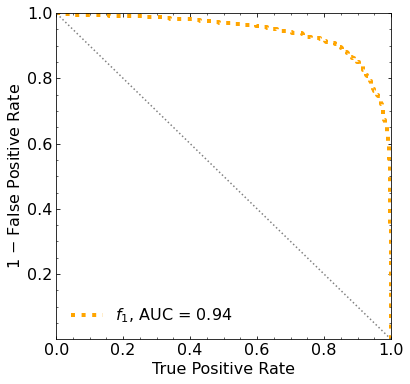

Classification score:


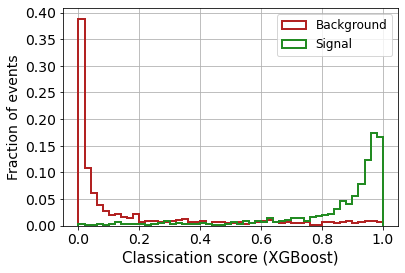


 ROC-AUC =  0.9420249216397271


In [20]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_1D,y_mon_train,eval_set=[(X_mon_train_1D, y_mon_train), (X_mon_val_1D, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_1D).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [21]:
np.savetxt('rocs/roc_imagesdt.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9420249216397271


### DNN

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 256)               1440512   
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_116 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_68 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_139 (Dense)            (None, 64)              

50/50 [==============================] - 0s 6ms/step - loss: 0.4102 - accuracy: 0.8290 - val_loss: 0.3840 - val_accuracy: 0.8391
Epoch 96/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4127 - accuracy: 0.8352 - val_loss: 0.4211 - val_accuracy: 0.8293
Epoch 97/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4231 - accuracy: 0.8233 - val_loss: 0.3812 - val_accuracy: 0.8373
Epoch 98/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3998 - accuracy: 0.8304 - val_loss: 0.3975 - val_accuracy: 0.8391
Epoch 99/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4110 - accuracy: 0.8331 - val_loss: 0.3999 - val_accuracy: 0.8400
Epoch 100/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3962 - accuracy: 0.8338 - val_loss: 0.3686 - val_accuracy: 0.8427
Epoch 101/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.4236 - accuracy: 0.8217 - val_loss: 0.3772 - val_accuracy: 0.8391
Epoch 102/1

50/50 [==============================] - 0s 5ms/step - loss: 0.3372 - accuracy: 0.8687 - val_loss: 0.3448 - val_accuracy: 0.8507
Epoch 153/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3371 - accuracy: 0.8691 - val_loss: 0.4119 - val_accuracy: 0.8098
Epoch 154/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3480 - accuracy: 0.8635 - val_loss: 0.3440 - val_accuracy: 0.8578
Epoch 155/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3478 - accuracy: 0.8627 - val_loss: 0.4032 - val_accuracy: 0.8133
Epoch 156/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3717 - accuracy: 0.8534 - val_loss: 0.3456 - val_accuracy: 0.8533
Epoch 157/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3495 - accuracy: 0.8682 - val_loss: 0.3335 - val_accuracy: 0.8622
Epoch 158/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3638 - accuracy: 0.8569 - val_loss: 0.3389 - val_accuracy: 0.8471
Epoch 1

Epoch 209/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3709 - accuracy: 0.8427 - val_loss: 0.3351 - val_accuracy: 0.8640
Epoch 210/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3398 - accuracy: 0.8628 - val_loss: 0.3454 - val_accuracy: 0.8480
Epoch 211/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3640 - accuracy: 0.8542 - val_loss: 0.3463 - val_accuracy: 0.8551
Epoch 212/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3540 - accuracy: 0.8583 - val_loss: 0.3258 - val_accuracy: 0.8693
Epoch 213/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3128 - accuracy: 0.8850 - val_loss: 0.3256 - val_accuracy: 0.8516
Epoch 214/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3649 - accuracy: 0.8604 - val_loss: 0.3331 - val_accuracy: 0.8569
Epoch 215/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3422 - accuracy: 0.8626 - val_loss: 0.3130 - val_accuracy:

Epoch 266/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3114 - accuracy: 0.8751 - val_loss: 0.3116 - val_accuracy: 0.8649
Epoch 267/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3405 - accuracy: 0.8669 - val_loss: 0.3468 - val_accuracy: 0.8640
Epoch 268/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3396 - accuracy: 0.8708 - val_loss: 0.3160 - val_accuracy: 0.8738
Epoch 269/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3379 - accuracy: 0.8639 - val_loss: 0.4214 - val_accuracy: 0.8338
Epoch 270/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3454 - accuracy: 0.8699 - val_loss: 0.3057 - val_accuracy: 0.8720
Epoch 271/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3208 - accuracy: 0.8747 - val_loss: 0.3385 - val_accuracy: 0.8631
Epoch 272/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3297 - accuracy: 0.8705 - val_loss: 0.3201 - val_accuracy:

Epoch 323/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3129 - accuracy: 0.8796 - val_loss: 0.3350 - val_accuracy: 0.8729
Epoch 324/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3280 - accuracy: 0.8676 - val_loss: 0.2995 - val_accuracy: 0.8693
Epoch 325/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3227 - accuracy: 0.8770 - val_loss: 0.2938 - val_accuracy: 0.8773
Epoch 326/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3239 - accuracy: 0.8776 - val_loss: 0.3229 - val_accuracy: 0.8551
Epoch 327/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3302 - accuracy: 0.8736 - val_loss: 0.3214 - val_accuracy: 0.8542
Epoch 328/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3342 - accuracy: 0.8607 - val_loss: 0.3055 - val_accuracy: 0.8782
Epoch 329/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3039 - accuracy: 0.8825 - val_loss: 0.3136 - val_accuracy:

Epoch 380/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2967 - accuracy: 0.8810 - val_loss: 0.3541 - val_accuracy: 0.8284
Epoch 381/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3001 - accuracy: 0.8760 - val_loss: 0.3073 - val_accuracy: 0.8622
Epoch 382/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3096 - accuracy: 0.8701 - val_loss: 0.2990 - val_accuracy: 0.8702
Epoch 383/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2985 - accuracy: 0.8866 - val_loss: 0.4725 - val_accuracy: 0.7796
Epoch 384/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3599 - accuracy: 0.8514 - val_loss: 0.3036 - val_accuracy: 0.8827
Epoch 385/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2989 - accuracy: 0.8871 - val_loss: 0.3022 - val_accuracy: 0.8791
Epoch 386/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2909 - accuracy: 0.8825 - val_loss: 0.2909 - val_accuracy:

Epoch 437/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2867 - accuracy: 0.8844 - val_loss: 0.3000 - val_accuracy: 0.8711
Epoch 438/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2826 - accuracy: 0.8890 - val_loss: 0.3161 - val_accuracy: 0.8693
Epoch 439/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2944 - accuracy: 0.8854 - val_loss: 0.3355 - val_accuracy: 0.8560
Epoch 440/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3083 - accuracy: 0.8744 - val_loss: 0.3187 - val_accuracy: 0.8622
Epoch 441/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2983 - accuracy: 0.8753 - val_loss: 0.3074 - val_accuracy: 0.8711
Epoch 442/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2842 - accuracy: 0.8853 - val_loss: 0.2899 - val_accuracy: 0.8756
Epoch 443/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2996 - accuracy: 0.8829 - val_loss: 0.3409 - val_accuracy:

Epoch 494/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.3226 - accuracy: 0.8632 - val_loss: 0.3208 - val_accuracy: 0.8640
Epoch 495/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3014 - accuracy: 0.8835 - val_loss: 0.3066 - val_accuracy: 0.8631
Epoch 496/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.3261 - accuracy: 0.8721 - val_loss: 0.3476 - val_accuracy: 0.8640
Epoch 497/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2859 - accuracy: 0.8816 - val_loss: 0.2923 - val_accuracy: 0.8791
Epoch 498/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2651 - accuracy: 0.8989 - val_loss: 0.2956 - val_accuracy: 0.8809
Epoch 499/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2750 - accuracy: 0.8879 - val_loss: 0.2962 - val_accuracy: 0.8791
Epoch 500/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2858 - accuracy: 0.8861 - val_loss: 0.2915 - val_accuracy:

Epoch 551/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2693 - accuracy: 0.8955 - val_loss: 0.2916 - val_accuracy: 0.8720
Epoch 552/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2651 - accuracy: 0.8987 - val_loss: 0.3005 - val_accuracy: 0.8729
Epoch 553/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2774 - accuracy: 0.8920 - val_loss: 0.3043 - val_accuracy: 0.8693
Epoch 554/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2700 - accuracy: 0.8967 - val_loss: 0.2895 - val_accuracy: 0.8764
Epoch 555/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2788 - accuracy: 0.8916 - val_loss: 0.2954 - val_accuracy: 0.8729
Epoch 556/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2747 - accuracy: 0.8860 - val_loss: 0.2880 - val_accuracy: 0.8782
Epoch 557/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2816 - accuracy: 0.8838 - val_loss: 0.3432 - val_accuracy:

Epoch 608/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2779 - accuracy: 0.8894 - val_loss: 0.2882 - val_accuracy: 0.8711
Epoch 609/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2885 - accuracy: 0.8887 - val_loss: 0.3134 - val_accuracy: 0.8693
Epoch 610/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2856 - accuracy: 0.8890 - val_loss: 0.3035 - val_accuracy: 0.8720
Epoch 611/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2732 - accuracy: 0.8922 - val_loss: 0.3782 - val_accuracy: 0.8631
Epoch 612/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2691 - accuracy: 0.8896 - val_loss: 0.2909 - val_accuracy: 0.8800
Epoch 613/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2490 - accuracy: 0.8996 - val_loss: 0.3025 - val_accuracy: 0.8693
Epoch 614/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2858 - accuracy: 0.8891 - val_loss: 0.3041 - val_accuracy:

Epoch 665/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2699 - accuracy: 0.8870 - val_loss: 0.3019 - val_accuracy: 0.8729
Epoch 666/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2869 - accuracy: 0.8826 - val_loss: 0.3096 - val_accuracy: 0.8640
Epoch 667/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2628 - accuracy: 0.8957 - val_loss: 0.3194 - val_accuracy: 0.8764
Epoch 668/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2749 - accuracy: 0.8924 - val_loss: 0.2979 - val_accuracy: 0.8676
Epoch 669/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2741 - accuracy: 0.8824 - val_loss: 0.2902 - val_accuracy: 0.8773
Epoch 670/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2639 - accuracy: 0.8949 - val_loss: 0.2935 - val_accuracy: 0.8747
Epoch 671/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2827 - accuracy: 0.8827 - val_loss: 0.3134 - val_accuracy:

Epoch 722/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2454 - accuracy: 0.9065 - val_loss: 0.2843 - val_accuracy: 0.8764
Epoch 723/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2538 - accuracy: 0.9035 - val_loss: 0.2942 - val_accuracy: 0.8756
Epoch 724/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2737 - accuracy: 0.8909 - val_loss: 0.2868 - val_accuracy: 0.8756
Epoch 725/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2681 - accuracy: 0.8919 - val_loss: 0.2948 - val_accuracy: 0.8756
Epoch 726/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2576 - accuracy: 0.8991 - val_loss: 0.2795 - val_accuracy: 0.8773
Epoch 727/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2543 - accuracy: 0.8937 - val_loss: 0.3027 - val_accuracy: 0.8702
Epoch 728/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2568 - accuracy: 0.8895 - val_loss: 0.2949 - val_accuracy:

Epoch 779/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2582 - accuracy: 0.8995 - val_loss: 0.2930 - val_accuracy: 0.8764
Epoch 780/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2727 - accuracy: 0.8908 - val_loss: 0.3448 - val_accuracy: 0.8578
Epoch 781/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2737 - accuracy: 0.8893 - val_loss: 0.3066 - val_accuracy: 0.8711
Epoch 782/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2437 - accuracy: 0.9021 - val_loss: 0.3305 - val_accuracy: 0.8311
Epoch 783/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2695 - accuracy: 0.8902 - val_loss: 0.2966 - val_accuracy: 0.8667
Epoch 784/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2584 - accuracy: 0.8989 - val_loss: 0.3321 - val_accuracy: 0.8720
Epoch 785/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2528 - accuracy: 0.9030 - val_loss: 0.3482 - val_accuracy:

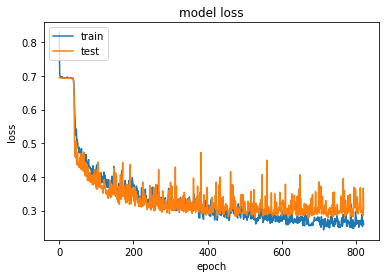

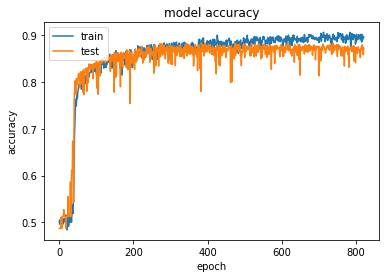

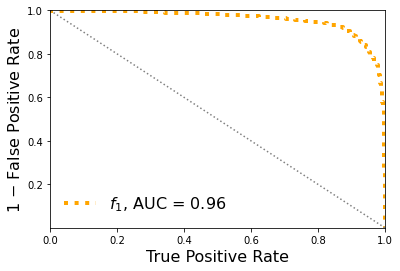

Classification score:


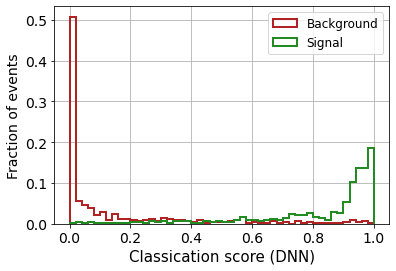


 ROC-AUC =  0.9583666236453403


In [103]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [104]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9583666236453403


### CNN

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 5,311,265
Trainable params: 5,311,265
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/500
50/50 [==============================] - 8s 162ms/step - loss: 0.9019 - accuracy: 0.6253 - val_loss: 0.5054 - val_accuracy: 0.7538
Epoch 2/500
50/50 [==============================] - 8s 159ms/step - loss: 0.4697 - accuracy: 0.7820 - val_loss: 0.4438 - val_accuracy: 0.8071
Epoch 3/500
50/50 [==============================] - 8s 159ms/step - loss: 0.4265 - accuracy: 0.8061 - val_loss: 0.4025 - val_accuracy: 0.8169
Epoch 4/500
50/50 [==============================] - 8s 159ms/step - loss: 0.3681 - accuracy: 0.8441 - val_loss: 0.3731 - val_accuracy: 0.8329
Epoch 5/500
50/50 [=====================

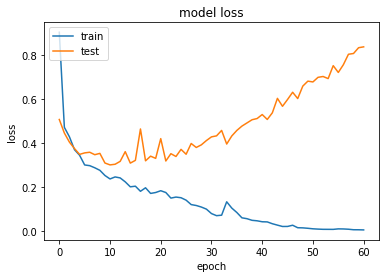

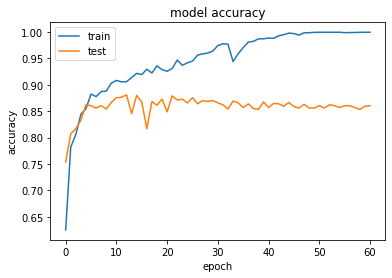

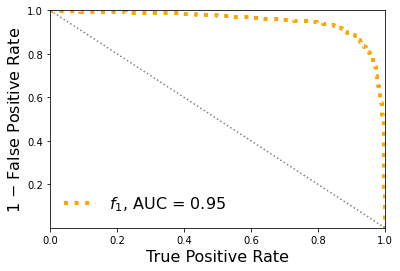

Classification score:


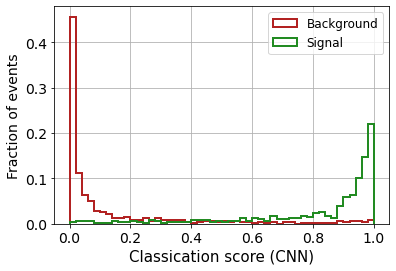


 ROC-AUC =  0.9514364769631041


In [105]:
##########
# images #
##########

input_2d = Input(shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]))

# Conv1D network
conv2d = Conv2D(32, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = MaxPooling2D((2,2), strides = (1,1))(conv2d)

conv2d = Dropout(0.20)(conv2d)
conv2d = Flatten()(conv2d)

conv2d = Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = Dropout(0.2)(conv2d)



############
# features #
############

input_1d = Input(shape=(X_mon5_train.shape[1]))



# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv2d, input_1d])


# Dense layers
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_2d, input_1d], outputs=output)

# Print the model summary
model.summary()




# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit([X_mon_train,X_mon5_train],
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon_val,X_mon5_val], y_mon_val),
                    shuffle=True)



# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict([X_mon_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [106]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9514364769631041


## 3. All compressed features

In [22]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 17)
X_mon_S.shape:  (5000, 17)

X_mon5.shape:  (10000, 17)

X_mon5_train :  (6375, 17)
y_mon5_train :  (6375,)
X_mon5_val :  (1125, 17)
y_mon5_val :  (1125,)
X_mon5_test :  (2500, 17)
y_mon5_test :  (2500,)



In [23]:
X_mon_train_1D = np.concatenate([X_mon_train_1D, X_mon5_train],axis=1)
X_mon_test_1D = np.concatenate([X_mon_test_1D, X_mon5_test],axis=1)
X_mon_val_1D = np.concatenate([X_mon_val_1D, X_mon5_val],axis=1)




print('')
print('X_mon_train_1D : ', X_mon_train_1D.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val_1D : ', X_mon_val_1D.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test_1D : ', X_mon_test_1D.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train_1D :  (6375, 5643)
y_mon_train :  (6375,)
X_mon_val_1D :  (1125, 5643)
y_mon_val :  (1125,)
X_mon_test_1D :  (2500, 5643)
y_mon_test :  (2500,)



### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68630	validation_1-logloss:0.68683
[1]	validation_0-logloss:0.67959	validation_1-logloss:0.68064
[2]	validation_0-logloss:0.67301	validation_1-logloss:0.67458
[3]	validation_0-logloss:0.66650	validation_1-logloss:0.66861
[4]	validation_0-logloss:0.66016	validation_1-logloss:0.66279
[5]	validation_0-logloss:0.65391	validation_1-logloss:0.65707
[6]	validation_0-logloss:0.64781	validation_1-logloss:0.65150
[7]	validation_0-logloss:0.64179	validation_1-logloss:0.64600
[8]	validation_0-logloss:0.63587	validation_1-logloss:0.64060
[9]	validation_0-logloss:0.63014	validation_1-logloss:0.63533
[10]	validation_0-logloss:0.62443	validation_1-logloss:0.63014
[11]	validation_0-logloss:0.61890	validation_1-logloss:0.62506
[12]	validation_0-logloss:0.61340	validation_1-logloss:0.62003
[13]	validation_0-logloss:0.60806	validation_1-logloss:0.61514
[14]	validation_0-logloss:0.60277	validation_1-logloss:0.61035
[15]	validation_0-logloss:0.59761	validation_1-logloss:0.60570
[1

[130]	validation_0-logloss:0.28801	validation_1-logloss:0.34148
[131]	validation_0-logloss:0.28669	validation_1-logloss:0.34040
[132]	validation_0-logloss:0.28544	validation_1-logloss:0.33950
[133]	validation_0-logloss:0.28407	validation_1-logloss:0.33844
[134]	validation_0-logloss:0.28271	validation_1-logloss:0.33735
[135]	validation_0-logloss:0.28141	validation_1-logloss:0.33636
[136]	validation_0-logloss:0.28018	validation_1-logloss:0.33536
[137]	validation_0-logloss:0.27890	validation_1-logloss:0.33447
[138]	validation_0-logloss:0.27759	validation_1-logloss:0.33346
[139]	validation_0-logloss:0.27641	validation_1-logloss:0.33261
[140]	validation_0-logloss:0.27520	validation_1-logloss:0.33163
[141]	validation_0-logloss:0.27401	validation_1-logloss:0.33077
[142]	validation_0-logloss:0.27279	validation_1-logloss:0.32978
[143]	validation_0-logloss:0.27163	validation_1-logloss:0.32902
[144]	validation_0-logloss:0.27038	validation_1-logloss:0.32807
[145]	validation_0-logloss:0.26921	valid

[259]	validation_0-logloss:0.18371	validation_1-logloss:0.26744
[260]	validation_0-logloss:0.18320	validation_1-logloss:0.26707
[261]	validation_0-logloss:0.18270	validation_1-logloss:0.26672
[262]	validation_0-logloss:0.18219	validation_1-logloss:0.26650
[263]	validation_0-logloss:0.18174	validation_1-logloss:0.26625
[264]	validation_0-logloss:0.18128	validation_1-logloss:0.26609
[265]	validation_0-logloss:0.18081	validation_1-logloss:0.26574
[266]	validation_0-logloss:0.18028	validation_1-logloss:0.26543
[267]	validation_0-logloss:0.17988	validation_1-logloss:0.26519
[268]	validation_0-logloss:0.17941	validation_1-logloss:0.26497
[269]	validation_0-logloss:0.17898	validation_1-logloss:0.26482
[270]	validation_0-logloss:0.17853	validation_1-logloss:0.26449
[271]	validation_0-logloss:0.17807	validation_1-logloss:0.26421
[272]	validation_0-logloss:0.17762	validation_1-logloss:0.26393
[273]	validation_0-logloss:0.17718	validation_1-logloss:0.26362
[274]	validation_0-logloss:0.17676	valid

[388]	validation_0-logloss:0.13863	validation_1-logloss:0.24647
[389]	validation_0-logloss:0.13839	validation_1-logloss:0.24635
[390]	validation_0-logloss:0.13808	validation_1-logloss:0.24630
[391]	validation_0-logloss:0.13784	validation_1-logloss:0.24616
[392]	validation_0-logloss:0.13760	validation_1-logloss:0.24614
[393]	validation_0-logloss:0.13732	validation_1-logloss:0.24604
[394]	validation_0-logloss:0.13703	validation_1-logloss:0.24583
[395]	validation_0-logloss:0.13676	validation_1-logloss:0.24583
[396]	validation_0-logloss:0.13650	validation_1-logloss:0.24580
[397]	validation_0-logloss:0.13624	validation_1-logloss:0.24578
[398]	validation_0-logloss:0.13602	validation_1-logloss:0.24577
[399]	validation_0-logloss:0.13578	validation_1-logloss:0.24576
[400]	validation_0-logloss:0.13549	validation_1-logloss:0.24561
[401]	validation_0-logloss:0.13528	validation_1-logloss:0.24555
[402]	validation_0-logloss:0.13509	validation_1-logloss:0.24553
[403]	validation_0-logloss:0.13482	valid

[517]	validation_0-logloss:0.11183	validation_1-logloss:0.24160
[518]	validation_0-logloss:0.11159	validation_1-logloss:0.24150
[519]	validation_0-logloss:0.11142	validation_1-logloss:0.24147
[520]	validation_0-logloss:0.11125	validation_1-logloss:0.24138
[521]	validation_0-logloss:0.11111	validation_1-logloss:0.24136
[522]	validation_0-logloss:0.11093	validation_1-logloss:0.24132
[523]	validation_0-logloss:0.11078	validation_1-logloss:0.24137
[524]	validation_0-logloss:0.11063	validation_1-logloss:0.24135
[525]	validation_0-logloss:0.11039	validation_1-logloss:0.24129
[526]	validation_0-logloss:0.11024	validation_1-logloss:0.24125
[527]	validation_0-logloss:0.11003	validation_1-logloss:0.24117
[528]	validation_0-logloss:0.10985	validation_1-logloss:0.24116
[529]	validation_0-logloss:0.10970	validation_1-logloss:0.24116
[530]	validation_0-logloss:0.10957	validation_1-logloss:0.24115
[531]	validation_0-logloss:0.10944	validation_1-logloss:0.24113
[532]	validation_0-logloss:0.10923	valid

[646]	validation_0-logloss:0.09257	validation_1-logloss:0.23867
[647]	validation_0-logloss:0.09249	validation_1-logloss:0.23865
[648]	validation_0-logloss:0.09232	validation_1-logloss:0.23866
[649]	validation_0-logloss:0.09216	validation_1-logloss:0.23866
[650]	validation_0-logloss:0.09203	validation_1-logloss:0.23857
[651]	validation_0-logloss:0.09192	validation_1-logloss:0.23858
[652]	validation_0-logloss:0.09183	validation_1-logloss:0.23855
[653]	validation_0-logloss:0.09168	validation_1-logloss:0.23856
[654]	validation_0-logloss:0.09152	validation_1-logloss:0.23867
[655]	validation_0-logloss:0.09136	validation_1-logloss:0.23868
[656]	validation_0-logloss:0.09126	validation_1-logloss:0.23867
[657]	validation_0-logloss:0.09117	validation_1-logloss:0.23864
[658]	validation_0-logloss:0.09103	validation_1-logloss:0.23868
[659]	validation_0-logloss:0.09087	validation_1-logloss:0.23868
[660]	validation_0-logloss:0.09073	validation_1-logloss:0.23872
[661]	validation_0-logloss:0.09060	valid

[775]	validation_0-logloss:0.07742	validation_1-logloss:0.23813
[776]	validation_0-logloss:0.07730	validation_1-logloss:0.23813
[777]	validation_0-logloss:0.07715	validation_1-logloss:0.23821
[778]	validation_0-logloss:0.07701	validation_1-logloss:0.23820
[779]	validation_0-logloss:0.07692	validation_1-logloss:0.23824
[780]	validation_0-logloss:0.07684	validation_1-logloss:0.23824
[781]	validation_0-logloss:0.07674	validation_1-logloss:0.23822
[782]	validation_0-logloss:0.07669	validation_1-logloss:0.23820
[783]	validation_0-logloss:0.07657	validation_1-logloss:0.23809
[784]	validation_0-logloss:0.07645	validation_1-logloss:0.23803
[785]	validation_0-logloss:0.07637	validation_1-logloss:0.23807
[786]	validation_0-logloss:0.07625	validation_1-logloss:0.23813
[787]	validation_0-logloss:0.07615	validation_1-logloss:0.23816
[788]	validation_0-logloss:0.07607	validation_1-logloss:0.23814
[789]	validation_0-logloss:0.07597	validation_1-logloss:0.23810
[790]	validation_0-logloss:0.07587	valid

[904]	validation_0-logloss:0.06529	validation_1-logloss:0.23732
[905]	validation_0-logloss:0.06522	validation_1-logloss:0.23731
[906]	validation_0-logloss:0.06515	validation_1-logloss:0.23735
[907]	validation_0-logloss:0.06509	validation_1-logloss:0.23738
[908]	validation_0-logloss:0.06499	validation_1-logloss:0.23732
[909]	validation_0-logloss:0.06494	validation_1-logloss:0.23727
[910]	validation_0-logloss:0.06484	validation_1-logloss:0.23732
[911]	validation_0-logloss:0.06474	validation_1-logloss:0.23731
[912]	validation_0-logloss:0.06465	validation_1-logloss:0.23727
[913]	validation_0-logloss:0.06458	validation_1-logloss:0.23733
[914]	validation_0-logloss:0.06447	validation_1-logloss:0.23735
[915]	validation_0-logloss:0.06441	validation_1-logloss:0.23733
[916]	validation_0-logloss:0.06431	validation_1-logloss:0.23731
[917]	validation_0-logloss:0.06424	validation_1-logloss:0.23737
[918]	validation_0-logloss:0.06414	validation_1-logloss:0.23735
[919]	validation_0-logloss:0.06406	valid

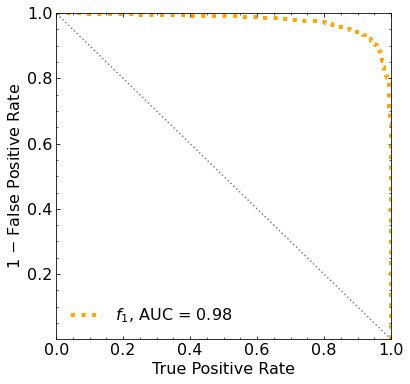

Classification score:


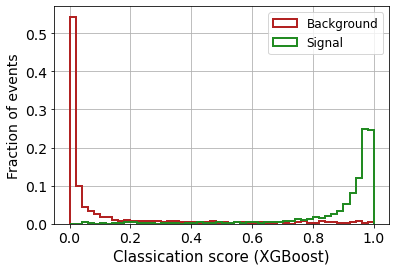


 ROC-AUC =  0.9765988312539693


In [24]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train_1D,y_mon_train,eval_set=[(X_mon_train_1D, y_mon_train), (X_mon_val_1D, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test_1D).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [25]:
np.savetxt('rocs/roc_images17feats.txt', [tpr_mon_xg, fpr_mon_xg])

print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9765988312539693


In [111]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  16 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  16
range of our data:  [[0, 1]]


In [112]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0055


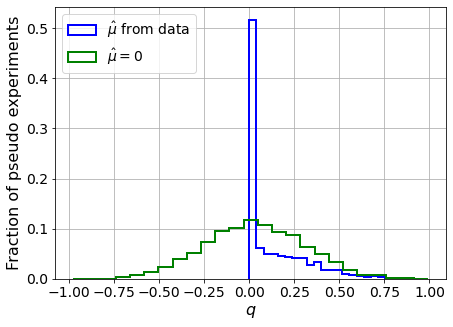

muhat mean:  0.11066818683344608
Z_bins:  0.16594918023195585
std Z_bins:  0.520545778816559
Z_bins mu=0:  0.16297457775382349
std Z_bins mu=0:  0.8543422425355857

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0065


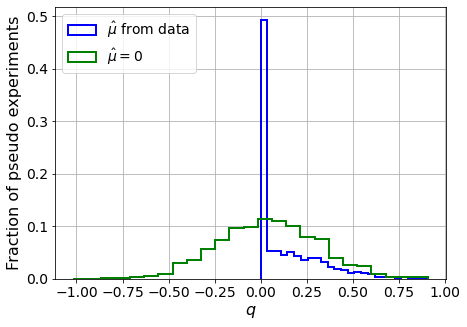

muhat mean:  -0.06370474347525505
Z_bins:  0.20678384487098836
std Z_bins:  0.4214293110606298
Z_bins mu=0:  0.20678384487098836
std Z_bins mu=0:  0.6595247924358345

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.005


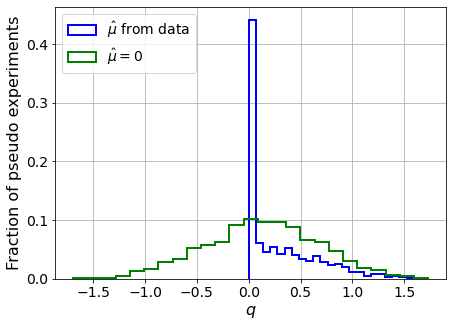

muhat mean:  0.06033710797547646
Z_bins:  0.36324990815156694
std Z_bins:  0.4952946736730545
Z_bins mu=0:  0.3624080490080057
std Z_bins mu=0:  0.7627998472599222

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.007


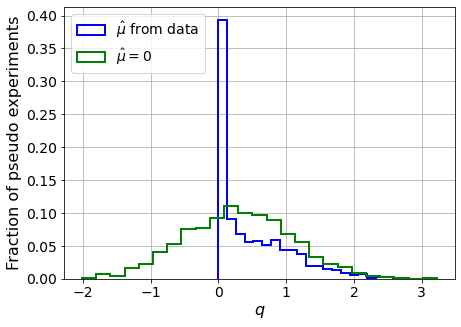

muhat mean:  0.04045126654857055
Z_bins:  0.5413180628455289
std Z_bins:  0.5132152282988647
Z_bins mu=0:  0.5407013226010616
std Z_bins mu=0:  0.7290783024129556

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.006


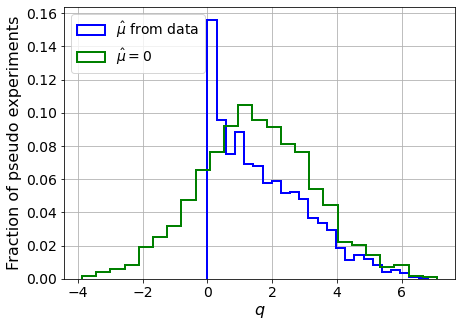

muhat mean:  0.024154780533797555
Z_bins:  1.2230842493418879
std Z_bins:  0.5786734129615301
Z_bins mu=0:  1.2220890107534363
std Z_bins mu=0:  0.7251948416462545

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0055


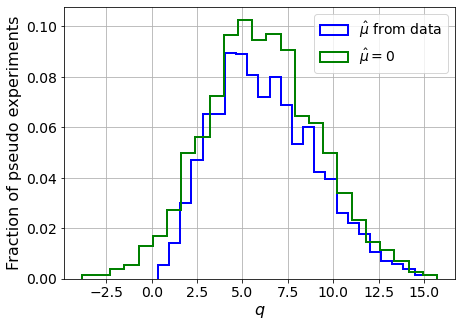

muhat mean:  -0.0010932107972313812
Z_bins:  2.4462745893349367
std Z_bins:  0.5733984273666776
Z_bins mu=0:  2.4460779565655475
std Z_bins mu=0:  0.6371980603888036

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0035


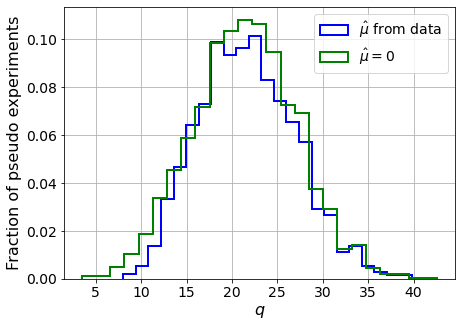

muhat mean:  0.004469415321621579
Z_bins:  4.6311990514847805
std Z_bins:  0.5762506278856524
Z_bins mu=0:  4.629662638357975
std Z_bins mu=0:  0.616156484939969

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0075


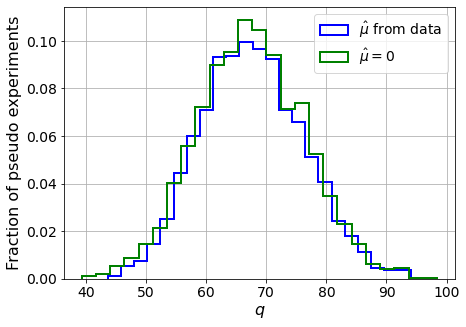

muhat mean:  0.0002549289582391857
Z_bins:  8.204518939819938
std Z_bins:  0.5193632805441086
Z_bins mu=0:  8.204404023614135
std Z_bins mu=0:  0.5395942132588657

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0055


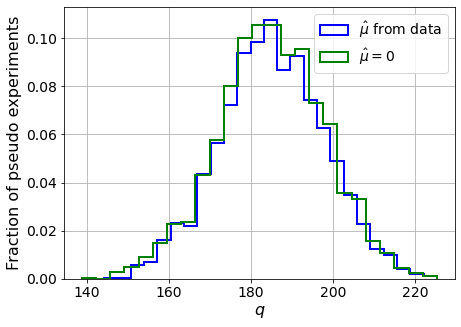

muhat mean:  -0.0006449222975010553
Z_bins:  13.59549673047749
std Z_bins:  0.4661031405886933
Z_bins mu=0:  13.594477523710648
std Z_bins mu=0:  0.47882700430528574

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.007


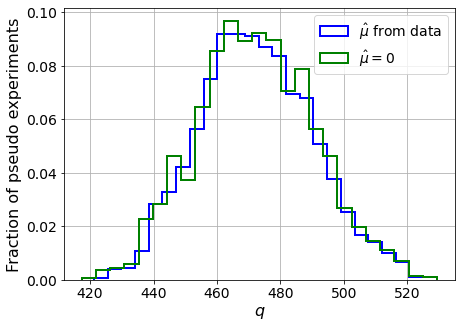

muhat mean:  -6.962309293673481e-06
Z_bins:  21.722065820942426
std Z_bins:  0.41590374839153643
Z_bins mu=0:  21.721770264437808
std Z_bins mu=0:  0.42334917360256413

--------


 FINAL RESULT:

[[0.16594918023195585, 0.520545778816559, 0.11066818683344608, 0.16297457775382349, 0.8543422425355857], [0.20678384487098836, 0.4214293110606298, -0.06370474347525505, 0.20678384487098836, 0.6595247924358345], [0.36324990815156694, 0.4952946736730545, 0.06033710797547646, 0.3624080490080057, 0.7627998472599222], [0.5413180628455289, 0.5132152282988647, 0.04045126654857055, 0.5407013226010616, 0.7290783024129556], [1.2230842493418879, 0.5786734129615301, 0.024154780533797555, 1.2220890107534363, 0.7251948416462545], [2.4462745893349367, 0.5733984273666776, -0.0010932107972313812, 2.4460779565655475, 0.6371980603888036], [4.6311990514847805, 0.5762506278856524, 0.004469415321621579, 4.629662638357975, 0.616156484939969], [8.204518939819938, 0.5193632805441086, 0.0002549289582391857, 8.204404023

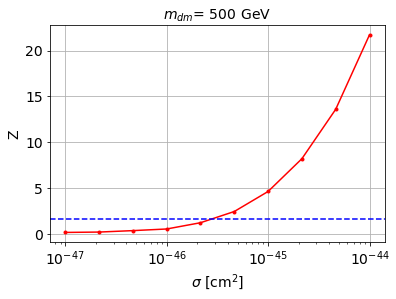


cross_BL_164:  2.798643856347853e-46
cross_BL_164_up:  1.82462654554755e-46
cross_BL_164_down:  4.013079420554403e-46


In [113]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 256)               1444864   
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_126 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_127 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 64)              

50/50 [==============================] - 0s 6ms/step - loss: 0.2223 - accuracy: 0.9128 - val_loss: 0.2079 - val_accuracy: 0.9111
Epoch 96/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2113 - accuracy: 0.9201 - val_loss: 0.2051 - val_accuracy: 0.9102
Epoch 97/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2081 - accuracy: 0.9241 - val_loss: 0.2042 - val_accuracy: 0.9173
Epoch 98/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1973 - accuracy: 0.9245 - val_loss: 0.1940 - val_accuracy: 0.9164
Epoch 99/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2040 - accuracy: 0.9284 - val_loss: 0.1936 - val_accuracy: 0.9191
Epoch 100/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2078 - accuracy: 0.9187 - val_loss: 0.1911 - val_accuracy: 0.9164
Epoch 101/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.2010 - accuracy: 0.9230 - val_loss: 0.2199 - val_accuracy: 0.9084
Epoch 102/1

50/50 [==============================] - 0s 6ms/step - loss: 0.1958 - accuracy: 0.9298 - val_loss: 0.2255 - val_accuracy: 0.9120
Epoch 153/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1953 - accuracy: 0.9295 - val_loss: 0.1867 - val_accuracy: 0.9227
Epoch 154/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.1778 - accuracy: 0.9302 - val_loss: 0.1885 - val_accuracy: 0.9262
Epoch 155/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.2027 - accuracy: 0.9260 - val_loss: 0.2010 - val_accuracy: 0.9049
Epoch 156/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1773 - accuracy: 0.9288 - val_loss: 0.1905 - val_accuracy: 0.9218
Epoch 157/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1938 - accuracy: 0.9279 - val_loss: 0.1911 - val_accuracy: 0.9227
Epoch 158/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.1921 - accuracy: 0.9271 - val_loss: 0.1910 - val_accuracy: 0.9156
Epoch 1

Epoch 209/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1765 - accuracy: 0.9358 - val_loss: 0.1806 - val_accuracy: 0.9209
Epoch 210/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1724 - accuracy: 0.9326 - val_loss: 0.1875 - val_accuracy: 0.9218
Epoch 211/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1785 - accuracy: 0.9298 - val_loss: 0.1844 - val_accuracy: 0.9156
Epoch 212/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1867 - accuracy: 0.9291 - val_loss: 0.2002 - val_accuracy: 0.9138
Epoch 213/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1903 - accuracy: 0.9330 - val_loss: 0.2237 - val_accuracy: 0.8996
Epoch 214/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.1829 - accuracy: 0.9307 - val_loss: 0.1840 - val_accuracy: 0.9244
Epoch 215/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1869 - accuracy: 0.9299 - val_loss: 0.1901 - val_accuracy:

Epoch 266/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1767 - accuracy: 0.9385 - val_loss: 0.2140 - val_accuracy: 0.9058
Epoch 267/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1782 - accuracy: 0.9307 - val_loss: 0.1864 - val_accuracy: 0.9244
Epoch 268/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.1754 - accuracy: 0.9279 - val_loss: 0.1892 - val_accuracy: 0.9164
Epoch 269/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.1688 - accuracy: 0.9355 - val_loss: 0.1926 - val_accuracy: 0.9173
Epoch 270/1500
50/50 [==============================] - 0s 6ms/step - loss: 0.1727 - accuracy: 0.9380 - val_loss: 0.1779 - val_accuracy: 0.9262
Epoch 271/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.1637 - accuracy: 0.9357 - val_loss: 0.1923 - val_accuracy: 0.9164
Epoch 272/1500
50/50 [==============================] - 0s 5ms/step - loss: 0.1833 - accuracy: 0.9334 - val_loss: 0.1961 - val_accuracy:

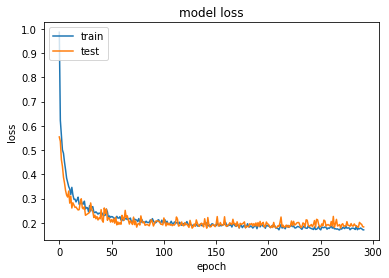

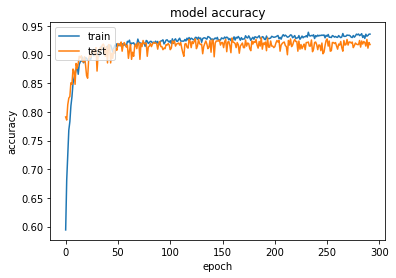

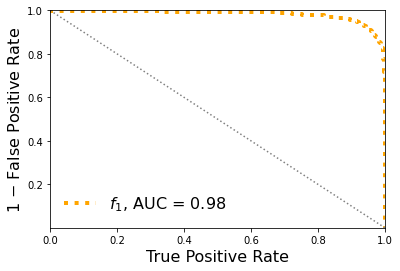

Classification score:


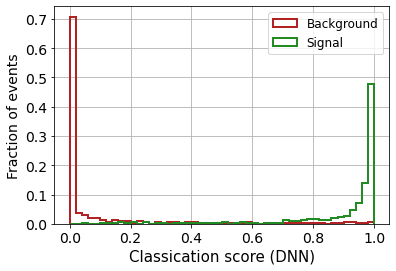


 ROC-AUC =  0.9820942935283633


In [114]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train_1D.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train_1D,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_1D, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test_1D)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [115]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9820942935283633


### CNN

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 5,311,777
Trainable params: 5,311,777
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/500
50/50 [==============================] - 8s 163ms/step - loss: 11.0877 - accuracy: 0.7180 - val_loss: 0.7943 - val_accuracy: 0.7662
Epoch 2/500
50/50 [==============================] - 8s 160ms/step - loss: 0.7106 - accuracy: 0.8108 - val_loss: 0.5773 - val_accuracy: 0.8169
Epoch 3/500
50/50 [==============================] - 8s 160ms/step - loss: 0.4844 - accuracy: 0.8285 - val_loss: 0.4533 - val_accuracy: 0.8382
Epoch 4/500
50/50 [==============================] - 8s 160ms/step - loss: 0.4378 - accuracy: 0.8427 - val_loss: 0.3944 - val_accuracy: 0.8604
Epoch 5/500
50/50 [==================

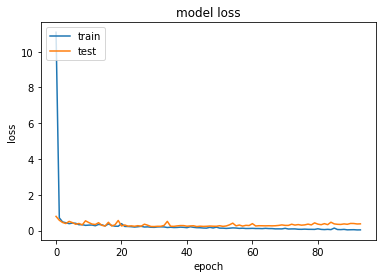

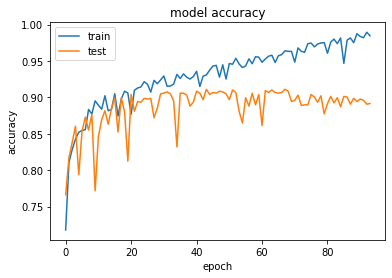

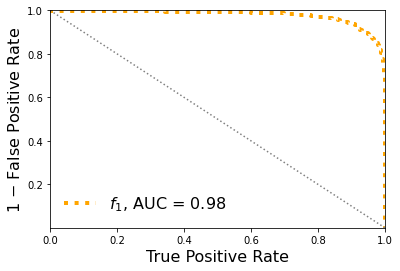

Classification score:


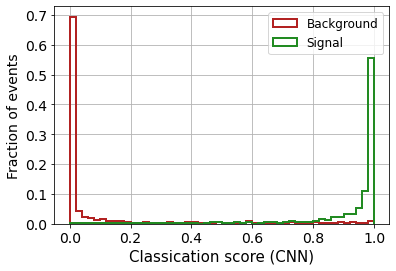


 ROC-AUC =  0.9771199526765411


In [116]:
##########
# images #
##########

input_2d = Input(shape=(X_mon_train.shape[1],X_mon_train.shape[2],X_mon_train.shape[3]))

# Conv1D network
conv2d = Conv2D(32, (3,3), strides = (1,1),kernel_regularizer=l2(0.005))(input_2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = MaxPooling2D((2,2), strides = (1,1))(conv2d)

conv2d = Dropout(0.20)(conv2d)
conv2d = Flatten()(conv2d)

conv2d = Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001))(conv2d)
conv2d = keras.layers.LeakyReLU(alpha=0.05)(conv2d)
conv2d = Dropout(0.2)(conv2d)



############
# features #
############

input_1d = Input(shape=(X_mon5_train.shape[1]))



# Concatenate the outputs from Conv2D and Conv1D networks
combined = concatenate([conv2d, input_1d])


# Dense layers
dense = Dense(32, activation='relu')(combined)
dense = Dropout(0.20)(dense)
dense = Dense(16, activation='relu')(dense)
dense = Dropout(0.20)(dense)
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=[input_2d, input_1d], outputs=output)

# Print the model summary
model.summary()




# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit([X_mon_train,X_mon5_train],
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=([X_mon_val,X_mon5_val], y_mon_val),
                    shuffle=True)



# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict([X_mon_test,X_mon5_test])

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [117]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9771199526765411
